# Annotation with CellAssign

## Assigning single-cell RNA-seq data to known cell types

CellAssign is a probabilistic model that uses prior knowledge of cell-type marker genes to annotate scRNA data into predefined cell types. Unlike other methods for assigning cell types, CellAssign does not require labeled single cell data and only needs to know whether or not each given gene is a marker of each cell type. The original paper and R code are linked below.

Paper: [Probabilistic cell-type assignment of single-cell RNA-seq for tumor microenvironment profiling, *Nature Methods 2019*](https://www.nature.com/articles/s41592-019-0529-1)

Code: https://github.com/Irrationone/cellassign

This notebook will demonstrate how to use CellAssign on follicular lymphoma and HGSC scRNA data.

```{note}
Running the following cell will install tutorial dependencies on Google Colab only. It will have no effect on environments other than Google Colab.
```

In [1]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

/env/lib/python3.11/site-packages/scvi_colab/_core.py:41: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


In [2]:
import os
import tempfile

import gdown
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scanpy as sc
import scvi
import seaborn as sns
import torch
from scvi.external import CellAssign

In [3]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)print("Last run with numpy version:", np.__version__)

Seed set to 0


Last run with scvi-tools version: 1.1.0


```{note}
You can modify `save_dir` below to change where the data files for this tutorial are saved.
```

In [4]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

To demonstrate CellAssign, we use the data from the original publication, which we converted into h5ad format. The data are originally available from here:

https://zenodo.org/record/3372746

In [5]:
def download_data(save_path: str):
    sce_follicular_path = os.path.join(save_path, "sce_follicular.h5ad")
    sce_hgsc_path = os.path.join(save_path, "sce_hgsc.h5ad")
    fl_celltype_path = os.path.join(save_path, "fl_celltype.csv")
    hgsc_celltype_path = os.path.join(save_path, "hgsc_celltype.csv")

    gdown.download(
        "https://drive.google.com/uc?id=10l6m2KKKioCZnQlRHomheappHh-jTFmx",
        sce_follicular_path,
        quiet=False,
    )
    gdown.download(
        "https://drive.google.com/uc?id=1Pae7VEcoZbKRvtllGAEWG4SOLWSjjtCO",
        sce_hgsc_path,
        quiet=False,
    )
    gdown.download(
        "https://drive.google.com/uc?id=1tJSOI9ve0i78WmszMLx2ul8F8tGycBTd",
        fl_celltype_path,
        quiet=False,
    )
    gdown.download(
        "https://drive.google.com/uc?id=1Mk5uPdnPC4IMRnuG5N4uFvypT8hPdJ74",
        hgsc_celltype_path,
        quiet=False,
    )

    return (
        sce_follicular_path,
        sce_hgsc_path,
        fl_celltype_path,
        hgsc_celltype_path,
    )

In [6]:
(
    sce_follicular_path,
    sce_hgsc_path,
    fl_celltype_path,
    hgsc_celltype_path,
) = download_data(save_dir.name)

Downloading...
From: https://drive.google.com/uc?id=10l6m2KKKioCZnQlRHomheappHh-jTFmx
To: /tmp/tmp5zq3j4r6/sce_follicular.h5ad



  0%|          | 0.00/83.0M [00:00<?, ?B/s]


100%|██████████| 83.0M/83.0M [00:00<00:00, 2.83GB/s]

Downloading...
From (original): https://drive.google.com/uc?id=1Pae7VEcoZbKRvtllGAEWG4SOLWSjjtCO
From (redirected): https://drive.google.com/uc?id=1Pae7VEcoZbKRvtllGAEWG4SOLWSjjtCO&confirm=t&uuid=9245f7eb-9847-4657-9519-50b9b7722fa9
To: /tmp/tmp5zq3j4r6/sce_hgsc.h5ad



  0%|          | 0.00/110M [00:00<?, ?B/s]


100%|██████████| 110M/110M [00:00<00:00, 2.83GB/s]

Downloading...
From: https://drive.google.com/uc?id=1tJSOI9ve0i78WmszMLx2ul8F8tGycBTd
To: /tmp/tmp5zq3j4r6/fl_celltype.csv



  0%|          | 0.00/446 [00:00<?, ?B/s]


100%|██████████| 446/446 [00:00<00:00, 848kB/s]

Downloading...
From: https://drive.google.com/uc?id=1Mk5uPdnPC4IMRnuG5N4uFvypT8hPdJ74
To: /tmp/tmp5zq3j4r6/hgsc_celltype.csv



  0%|          | 0.00/1.16k [00:00<?, ?B/s]


100%|██████████| 1.16k/1.16k [00:00<00:00, 2.14MB/s]

## Follicular Lymphoma Data

Load follicular lymphoma data and marker gene matrix (see Supplementary Table 2 from the original paper).

In [7]:
follicular_adata = sc.read(sce_follicular_path)
fl_celltype_markers = pd.read_csv(fl_celltype_path, index_col=0)

follicular_adata.obs.index = follicular_adata.obs.index.astype("str")
follicular_adata.var.index = follicular_adata.var.index.astype("str")
follicular_adata.var_names_make_unique()
follicular_adata.obs_names_make_unique()

follicular_adata

/env/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


/env/lib/python3.11/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/env/lib/python3.11/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 9156 × 33694
    obs: 'Sample', 'dataset', 'patient', 'timepoint', 'progression_status', 'patient_progression', 'sample_barcode', 'is_cell_control', 'total_features_by_counts', 'log10_total_features_by_counts', 'total_counts', 'log10_total_counts', 'pct_counts_in_top_50_features', 'pct_counts_in_top_100_features', 'pct_counts_in_top_200_features', 'pct_counts_in_top_500_features', 'total_features_by_counts_endogenous', 'log10_total_features_by_counts_endogenous', 'total_counts_endogenous', 'log10_total_counts_endogenous', 'pct_counts_endogenous', 'pct_counts_in_top_50_features_endogenous', 'pct_counts_in_top_100_features_endogenous', 'pct_counts_in_top_200_features_endogenous', 'pct_counts_in_top_500_features_endogenous', 'total_features_by_counts_feature_control', 'log10_total_features_by_counts_feature_control', 'total_counts_feature_control', 'log10_total_counts_feature_control', 'pct_counts_feature_control', 'pct_counts_in_top_50_features_featur

### Create and fit CellAssign model

The anndata object and cell type marker matrix should contain the same genes, so we index into `adata` to include only the genes from `marker_gene_mat`.

In [8]:
follicular_bdata = follicular_adata[:, fl_celltype_markers.index].copy()

Then we setup anndata and initialize a `CellAssign` model. Here we set the `size_factor_key` to "size_factor", which is a column in `bdata.obs`.

```{note}
A size factor may be defined manually as scaled library size (total UMI count) and should not be placed on the log scale, as the model will do this manually. The library size should be computed before any gene subsetting (in this case, technically, a few notebook cells up).
```

This can be acheived as follows:

```python
lib_size = adata.X.sum(1)
adata.obs["size_factor"] = lib_size / np.mean(lib_size)
```

In [9]:
scvi.external.CellAssign.setup_anndata(follicular_bdata, size_factor_key="size_factor")

<frozen abc>:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.



In [10]:
follicular_model = CellAssign(follicular_bdata, fl_celltype_markers)
follicular_model.train()

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
/env/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.



Training:   0%|          | 0/400 [00:00<?, ?it/s]


Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]


Epoch 1/400:   0%|          | 1/400 [00:00<02:07,  3.13it/s]


Epoch 1/400:   0%|          | 1/400 [00:00<02:07,  3.13it/s, v_num=1, train_loss_step=87.3, train_loss_epoch=93]


Epoch 2/400:   0%|          | 1/400 [00:00<02:07,  3.13it/s, v_num=1, train_loss_step=87.3, train_loss_epoch=93]


Epoch 2/400:   0%|          | 2/400 [00:00<02:07,  3.13it/s, v_num=1, train_loss_step=84.9, train_loss_epoch=84.8]


Epoch 3/400:   0%|          | 2/400 [00:00<02:07,  3.13it/s, v_num=1, train_loss_step=84.9, train_loss_epoch=84.8]


Epoch 3/400:   1%|          | 3/400 [00:00<00:48,  8.27it/s, v_num=1, train_loss_step=84.9, train_loss_epoch=84.8]


Epoch 3/400:   1%|          | 3/400 [00:00<00:48,  8.27it/s, v_num=1, train_loss_step=81.9, train_loss_epoch=81.1]


Epoch 4/400:   1%|          | 3/400 [00:00<00:48,  8.27it/s, v_num=1, train_loss_step=81.9, train_loss_epoch=81.1]


Epoch 4/400:   1%|          | 4/400 [00:00<00:47,  8.27it/s, v_num=1, train_loss_step=70.9, train_loss_epoch=77.5]


Epoch 5/400:   1%|          | 4/400 [00:00<00:47,  8.27it/s, v_num=1, train_loss_step=70.9, train_loss_epoch=77.5]


Epoch 5/400:   1%|▏         | 5/400 [00:00<00:33, 11.83it/s, v_num=1, train_loss_step=70.9, train_loss_epoch=77.5]


Epoch 5/400:   1%|▏         | 5/400 [00:00<00:33, 11.83it/s, v_num=1, train_loss_step=74, train_loss_epoch=74.1]  


Epoch 6/400:   1%|▏         | 5/400 [00:00<00:33, 11.83it/s, v_num=1, train_loss_step=74, train_loss_epoch=74.1]


Epoch 6/400:   2%|▏         | 6/400 [00:00<00:33, 11.83it/s, v_num=1, train_loss_step=65.3, train_loss_epoch=70.8]


Epoch 7/400:   2%|▏         | 6/400 [00:00<00:33, 11.83it/s, v_num=1, train_loss_step=65.3, train_loss_epoch=70.8]


Epoch 7/400:   2%|▏         | 7/400 [00:00<00:27, 14.29it/s, v_num=1, train_loss_step=65.3, train_loss_epoch=70.8]


Epoch 7/400:   2%|▏         | 7/400 [00:00<00:27, 14.29it/s, v_num=1, train_loss_step=63, train_loss_epoch=67.5]  


Epoch 8/400:   2%|▏         | 7/400 [00:00<00:27, 14.29it/s, v_num=1, train_loss_step=63, train_loss_epoch=67.5]


Epoch 8/400:   2%|▏         | 8/400 [00:00<00:27, 14.29it/s, v_num=1, train_loss_step=64.5, train_loss_epoch=63.8]


Epoch 9/400:   2%|▏         | 8/400 [00:00<00:27, 14.29it/s, v_num=1, train_loss_step=64.5, train_loss_epoch=63.8]


Epoch 9/400:   2%|▏         | 9/400 [00:00<00:24, 15.98it/s, v_num=1, train_loss_step=64.5, train_loss_epoch=63.8]


Epoch 9/400:   2%|▏         | 9/400 [00:00<00:24, 15.98it/s, v_num=1, train_loss_step=55.4, train_loss_epoch=59.3]


Epoch 10/400:   2%|▏         | 9/400 [00:00<00:24, 15.98it/s, v_num=1, train_loss_step=55.4, train_loss_epoch=59.3]


Epoch 10/400:   2%|▎         | 10/400 [00:00<00:24, 15.98it/s, v_num=1, train_loss_step=52, train_loss_epoch=54.4] 


Epoch 11/400:   2%|▎         | 10/400 [00:00<00:24, 15.98it/s, v_num=1, train_loss_step=52, train_loss_epoch=54.4]


Epoch 11/400:   3%|▎         | 11/400 [00:00<00:22, 17.19it/s, v_num=1, train_loss_step=52, train_loss_epoch=54.4]


Epoch 11/400:   3%|▎         | 11/400 [00:00<00:22, 17.19it/s, v_num=1, train_loss_step=47.1, train_loss_epoch=50.6]


Epoch 12/400:   3%|▎         | 11/400 [00:00<00:22, 17.19it/s, v_num=1, train_loss_step=47.1, train_loss_epoch=50.6]


Epoch 12/400:   3%|▎         | 12/400 [00:00<00:22, 17.19it/s, v_num=1, train_loss_step=48.3, train_loss_epoch=47.5]


Epoch 13/400:   3%|▎         | 12/400 [00:00<00:22, 17.19it/s, v_num=1, train_loss_step=48.3, train_loss_epoch=47.5]


Epoch 13/400:   3%|▎         | 13/400 [00:00<00:22, 17.19it/s, v_num=1, train_loss_step=43.8, train_loss_epoch=44.9]


Epoch 14/400:   3%|▎         | 13/400 [00:00<00:22, 17.19it/s, v_num=1, train_loss_step=43.8, train_loss_epoch=44.9]


Epoch 14/400:   4%|▎         | 14/400 [00:00<00:21, 18.31it/s, v_num=1, train_loss_step=43.8, train_loss_epoch=44.9]


Epoch 14/400:   4%|▎         | 14/400 [00:00<00:21, 18.31it/s, v_num=1, train_loss_step=43.8, train_loss_epoch=42.7]


Epoch 15/400:   4%|▎         | 14/400 [00:00<00:21, 18.31it/s, v_num=1, train_loss_step=43.8, train_loss_epoch=42.7]


Epoch 15/400:   4%|▍         | 15/400 [00:01<00:21, 18.31it/s, v_num=1, train_loss_step=42.9, train_loss_epoch=41]  


Epoch 16/400:   4%|▍         | 15/400 [00:01<00:21, 18.31it/s, v_num=1, train_loss_step=42.9, train_loss_epoch=41]


Epoch 16/400:   4%|▍         | 16/400 [00:01<00:20, 18.75it/s, v_num=1, train_loss_step=42.9, train_loss_epoch=41]


Epoch 16/400:   4%|▍         | 16/400 [00:01<00:20, 18.75it/s, v_num=1, train_loss_step=37.4, train_loss_epoch=39.5]


Epoch 17/400:   4%|▍         | 16/400 [00:01<00:20, 18.75it/s, v_num=1, train_loss_step=37.4, train_loss_epoch=39.5]


Epoch 17/400:   4%|▍         | 17/400 [00:01<00:20, 18.75it/s, v_num=1, train_loss_step=38.1, train_loss_epoch=38.2]


Epoch 18/400:   4%|▍         | 17/400 [00:01<00:20, 18.75it/s, v_num=1, train_loss_step=38.1, train_loss_epoch=38.2]


Epoch 18/400:   4%|▍         | 18/400 [00:01<00:20, 19.10it/s, v_num=1, train_loss_step=38.1, train_loss_epoch=38.2]


Epoch 18/400:   4%|▍         | 18/400 [00:01<00:20, 19.10it/s, v_num=1, train_loss_step=38.3, train_loss_epoch=37]  


Epoch 19/400:   4%|▍         | 18/400 [00:01<00:20, 19.10it/s, v_num=1, train_loss_step=38.3, train_loss_epoch=37]


Epoch 19/400:   5%|▍         | 19/400 [00:01<00:19, 19.10it/s, v_num=1, train_loss_step=37.4, train_loss_epoch=36]


Epoch 20/400:   5%|▍         | 19/400 [00:01<00:19, 19.10it/s, v_num=1, train_loss_step=37.4, train_loss_epoch=36]


Epoch 20/400:   5%|▌         | 20/400 [00:01<00:19, 19.10it/s, v_num=1, train_loss_step=35, train_loss_epoch=35.1]


Epoch 21/400:   5%|▌         | 20/400 [00:01<00:19, 19.10it/s, v_num=1, train_loss_step=35, train_loss_epoch=35.1]


Epoch 21/400:   5%|▌         | 21/400 [00:01<00:19, 19.46it/s, v_num=1, train_loss_step=35, train_loss_epoch=35.1]


Epoch 21/400:   5%|▌         | 21/400 [00:01<00:19, 19.46it/s, v_num=1, train_loss_step=32.5, train_loss_epoch=34.2]


Epoch 22/400:   5%|▌         | 21/400 [00:01<00:19, 19.46it/s, v_num=1, train_loss_step=32.5, train_loss_epoch=34.2]


Epoch 22/400:   6%|▌         | 22/400 [00:01<00:19, 19.46it/s, v_num=1, train_loss_step=32.4, train_loss_epoch=33.5]


Epoch 23/400:   6%|▌         | 22/400 [00:01<00:19, 19.46it/s, v_num=1, train_loss_step=32.4, train_loss_epoch=33.5]


Epoch 23/400:   6%|▌         | 23/400 [00:01<00:19, 19.60it/s, v_num=1, train_loss_step=32.4, train_loss_epoch=33.5]


Epoch 23/400:   6%|▌         | 23/400 [00:01<00:19, 19.60it/s, v_num=1, train_loss_step=33.7, train_loss_epoch=32.8]


Epoch 24/400:   6%|▌         | 23/400 [00:01<00:19, 19.60it/s, v_num=1, train_loss_step=33.7, train_loss_epoch=32.8]


Epoch 24/400:   6%|▌         | 24/400 [00:01<00:19, 19.60it/s, v_num=1, train_loss_step=31.7, train_loss_epoch=32.1]


Epoch 25/400:   6%|▌         | 24/400 [00:01<00:19, 19.60it/s, v_num=1, train_loss_step=31.7, train_loss_epoch=32.1]


Epoch 25/400:   6%|▋         | 25/400 [00:01<00:19, 19.60it/s, v_num=1, train_loss_step=30.1, train_loss_epoch=31.5]


Epoch 26/400:   6%|▋         | 25/400 [00:01<00:19, 19.60it/s, v_num=1, train_loss_step=30.1, train_loss_epoch=31.5]


Epoch 26/400:   6%|▋         | 26/400 [00:01<00:18, 19.77it/s, v_num=1, train_loss_step=30.1, train_loss_epoch=31.5]


Epoch 26/400:   6%|▋         | 26/400 [00:01<00:18, 19.77it/s, v_num=1, train_loss_step=29.7, train_loss_epoch=31]  


Epoch 27/400:   6%|▋         | 26/400 [00:01<00:18, 19.77it/s, v_num=1, train_loss_step=29.7, train_loss_epoch=31]


Epoch 27/400:   7%|▋         | 27/400 [00:01<00:18, 19.77it/s, v_num=1, train_loss_step=31.1, train_loss_epoch=30.4]


Epoch 28/400:   7%|▋         | 27/400 [00:01<00:18, 19.77it/s, v_num=1, train_loss_step=31.1, train_loss_epoch=30.4]


Epoch 28/400:   7%|▋         | 28/400 [00:01<00:18, 19.77it/s, v_num=1, train_loss_step=32, train_loss_epoch=29.9]  


Epoch 29/400:   7%|▋         | 28/400 [00:01<00:18, 19.77it/s, v_num=1, train_loss_step=32, train_loss_epoch=29.9]


Epoch 29/400:   7%|▋         | 29/400 [00:01<00:18, 19.87it/s, v_num=1, train_loss_step=32, train_loss_epoch=29.9]


Epoch 29/400:   7%|▋         | 29/400 [00:01<00:18, 19.87it/s, v_num=1, train_loss_step=30.6, train_loss_epoch=29.5]


Epoch 30/400:   7%|▋         | 29/400 [00:01<00:18, 19.87it/s, v_num=1, train_loss_step=30.6, train_loss_epoch=29.5]


Epoch 30/400:   8%|▊         | 30/400 [00:01<00:18, 19.87it/s, v_num=1, train_loss_step=28.8, train_loss_epoch=29]  


Epoch 31/400:   8%|▊         | 30/400 [00:01<00:18, 19.87it/s, v_num=1, train_loss_step=28.8, train_loss_epoch=29]


Epoch 31/400:   8%|▊         | 31/400 [00:01<00:18, 19.87it/s, v_num=1, train_loss_step=30.1, train_loss_epoch=28.6]


Epoch 32/400:   8%|▊         | 31/400 [00:01<00:18, 19.87it/s, v_num=1, train_loss_step=30.1, train_loss_epoch=28.6]


Epoch 32/400:   8%|▊         | 32/400 [00:01<00:18, 19.92it/s, v_num=1, train_loss_step=30.1, train_loss_epoch=28.6]


Epoch 32/400:   8%|▊         | 32/400 [00:01<00:18, 19.92it/s, v_num=1, train_loss_step=27.1, train_loss_epoch=28.2]


Epoch 33/400:   8%|▊         | 32/400 [00:01<00:18, 19.92it/s, v_num=1, train_loss_step=27.1, train_loss_epoch=28.2]


Epoch 33/400:   8%|▊         | 33/400 [00:01<00:18, 19.92it/s, v_num=1, train_loss_step=27.1, train_loss_epoch=27.8]


Epoch 34/400:   8%|▊         | 33/400 [00:01<00:18, 19.92it/s, v_num=1, train_loss_step=27.1, train_loss_epoch=27.8]


Epoch 34/400:   8%|▊         | 34/400 [00:01<00:18, 19.92it/s, v_num=1, train_loss_step=26.1, train_loss_epoch=27.5]


Epoch 35/400:   8%|▊         | 34/400 [00:01<00:18, 19.92it/s, v_num=1, train_loss_step=26.1, train_loss_epoch=27.5]


Epoch 35/400:   9%|▉         | 35/400 [00:02<00:18, 19.97it/s, v_num=1, train_loss_step=26.1, train_loss_epoch=27.5]


Epoch 35/400:   9%|▉         | 35/400 [00:02<00:18, 19.97it/s, v_num=1, train_loss_step=27.4, train_loss_epoch=27.2]


Epoch 36/400:   9%|▉         | 35/400 [00:02<00:18, 19.97it/s, v_num=1, train_loss_step=27.4, train_loss_epoch=27.2]


Epoch 36/400:   9%|▉         | 36/400 [00:02<00:18, 19.97it/s, v_num=1, train_loss_step=26.9, train_loss_epoch=26.9]


Epoch 37/400:   9%|▉         | 36/400 [00:02<00:18, 19.97it/s, v_num=1, train_loss_step=26.9, train_loss_epoch=26.9]


Epoch 37/400:   9%|▉         | 37/400 [00:02<00:18, 19.97it/s, v_num=1, train_loss_step=26.4, train_loss_epoch=26.6]


Epoch 38/400:   9%|▉         | 37/400 [00:02<00:18, 19.97it/s, v_num=1, train_loss_step=26.4, train_loss_epoch=26.6]


Epoch 38/400:  10%|▉         | 38/400 [00:02<00:18, 19.99it/s, v_num=1, train_loss_step=26.4, train_loss_epoch=26.6]


Epoch 38/400:  10%|▉         | 38/400 [00:02<00:18, 19.99it/s, v_num=1, train_loss_step=24.9, train_loss_epoch=26.3]


Epoch 39/400:  10%|▉         | 38/400 [00:02<00:18, 19.99it/s, v_num=1, train_loss_step=24.9, train_loss_epoch=26.3]


Epoch 39/400:  10%|▉         | 39/400 [00:02<00:18, 19.99it/s, v_num=1, train_loss_step=26.6, train_loss_epoch=26.1]


Epoch 40/400:  10%|▉         | 39/400 [00:02<00:18, 19.99it/s, v_num=1, train_loss_step=26.6, train_loss_epoch=26.1]


Epoch 40/400:  10%|█         | 40/400 [00:02<00:18, 19.99it/s, v_num=1, train_loss_step=25.1, train_loss_epoch=25.8]


Epoch 41/400:  10%|█         | 40/400 [00:02<00:18, 19.99it/s, v_num=1, train_loss_step=25.1, train_loss_epoch=25.8]


Epoch 41/400:  10%|█         | 41/400 [00:02<00:17, 20.02it/s, v_num=1, train_loss_step=25.1, train_loss_epoch=25.8]


Epoch 41/400:  10%|█         | 41/400 [00:02<00:17, 20.02it/s, v_num=1, train_loss_step=24.9, train_loss_epoch=25.6]


Epoch 42/400:  10%|█         | 41/400 [00:02<00:17, 20.02it/s, v_num=1, train_loss_step=24.9, train_loss_epoch=25.6]


Epoch 42/400:  10%|█         | 42/400 [00:02<00:17, 20.02it/s, v_num=1, train_loss_step=25.4, train_loss_epoch=25.4]


Epoch 43/400:  10%|█         | 42/400 [00:02<00:17, 20.02it/s, v_num=1, train_loss_step=25.4, train_loss_epoch=25.4]


Epoch 43/400:  11%|█         | 43/400 [00:02<00:17, 20.02it/s, v_num=1, train_loss_step=24, train_loss_epoch=25.2]  


Epoch 44/400:  11%|█         | 43/400 [00:02<00:17, 20.02it/s, v_num=1, train_loss_step=24, train_loss_epoch=25.2]


Epoch 44/400:  11%|█         | 44/400 [00:02<00:17, 20.03it/s, v_num=1, train_loss_step=24, train_loss_epoch=25.2]


Epoch 44/400:  11%|█         | 44/400 [00:02<00:17, 20.03it/s, v_num=1, train_loss_step=25.9, train_loss_epoch=25]


Epoch 45/400:  11%|█         | 44/400 [00:02<00:17, 20.03it/s, v_num=1, train_loss_step=25.9, train_loss_epoch=25]


Epoch 45/400:  11%|█▏        | 45/400 [00:02<00:17, 20.03it/s, v_num=1, train_loss_step=24.8, train_loss_epoch=24.8]


Epoch 46/400:  11%|█▏        | 45/400 [00:02<00:17, 20.03it/s, v_num=1, train_loss_step=24.8, train_loss_epoch=24.8]


Epoch 46/400:  12%|█▏        | 46/400 [00:02<00:17, 20.03it/s, v_num=1, train_loss_step=25.1, train_loss_epoch=24.7]


Epoch 47/400:  12%|█▏        | 46/400 [00:02<00:17, 20.03it/s, v_num=1, train_loss_step=25.1, train_loss_epoch=24.7]


Epoch 47/400:  12%|█▏        | 47/400 [00:02<00:17, 20.03it/s, v_num=1, train_loss_step=25.1, train_loss_epoch=24.7]


Epoch 47/400:  12%|█▏        | 47/400 [00:02<00:17, 20.03it/s, v_num=1, train_loss_step=22.9, train_loss_epoch=24.5]


Epoch 48/400:  12%|█▏        | 47/400 [00:02<00:17, 20.03it/s, v_num=1, train_loss_step=22.9, train_loss_epoch=24.5]


Epoch 48/400:  12%|█▏        | 48/400 [00:02<00:17, 20.03it/s, v_num=1, train_loss_step=25.9, train_loss_epoch=24.3]


Epoch 49/400:  12%|█▏        | 48/400 [00:02<00:17, 20.03it/s, v_num=1, train_loss_step=25.9, train_loss_epoch=24.3]


Epoch 49/400:  12%|█▏        | 49/400 [00:02<00:17, 20.03it/s, v_num=1, train_loss_step=22.6, train_loss_epoch=24.2]


Epoch 50/400:  12%|█▏        | 49/400 [00:02<00:17, 20.03it/s, v_num=1, train_loss_step=22.6, train_loss_epoch=24.2]


Epoch 50/400:  12%|█▎        | 50/400 [00:02<00:17, 20.02it/s, v_num=1, train_loss_step=22.6, train_loss_epoch=24.2]


Epoch 50/400:  12%|█▎        | 50/400 [00:02<00:17, 20.02it/s, v_num=1, train_loss_step=23, train_loss_epoch=24]    


Epoch 51/400:  12%|█▎        | 50/400 [00:02<00:17, 20.02it/s, v_num=1, train_loss_step=23, train_loss_epoch=24]


Epoch 51/400:  13%|█▎        | 51/400 [00:02<00:17, 20.02it/s, v_num=1, train_loss_step=23, train_loss_epoch=23.9]


Epoch 52/400:  13%|█▎        | 51/400 [00:02<00:17, 20.02it/s, v_num=1, train_loss_step=23, train_loss_epoch=23.9]


Epoch 52/400:  13%|█▎        | 52/400 [00:02<00:17, 20.02it/s, v_num=1, train_loss_step=23.1, train_loss_epoch=23.8]


Epoch 53/400:  13%|█▎        | 52/400 [00:02<00:17, 20.02it/s, v_num=1, train_loss_step=23.1, train_loss_epoch=23.8]


Epoch 53/400:  13%|█▎        | 53/400 [00:02<00:17, 20.01it/s, v_num=1, train_loss_step=23.1, train_loss_epoch=23.8]


Epoch 53/400:  13%|█▎        | 53/400 [00:02<00:17, 20.01it/s, v_num=1, train_loss_step=24.6, train_loss_epoch=23.7]


Epoch 54/400:  13%|█▎        | 53/400 [00:02<00:17, 20.01it/s, v_num=1, train_loss_step=24.6, train_loss_epoch=23.7]


Epoch 54/400:  14%|█▎        | 54/400 [00:02<00:17, 20.01it/s, v_num=1, train_loss_step=24.7, train_loss_epoch=23.5]


Epoch 55/400:  14%|█▎        | 54/400 [00:02<00:17, 20.01it/s, v_num=1, train_loss_step=24.7, train_loss_epoch=23.5]


Epoch 55/400:  14%|█▍        | 55/400 [00:03<00:17, 20.01it/s, v_num=1, train_loss_step=24.7, train_loss_epoch=23.4]


Epoch 56/400:  14%|█▍        | 55/400 [00:03<00:17, 20.01it/s, v_num=1, train_loss_step=24.7, train_loss_epoch=23.4]


Epoch 56/400:  14%|█▍        | 56/400 [00:03<00:17, 20.03it/s, v_num=1, train_loss_step=24.7, train_loss_epoch=23.4]


Epoch 56/400:  14%|█▍        | 56/400 [00:03<00:17, 20.03it/s, v_num=1, train_loss_step=22, train_loss_epoch=23.3]  


Epoch 57/400:  14%|█▍        | 56/400 [00:03<00:17, 20.03it/s, v_num=1, train_loss_step=22, train_loss_epoch=23.3]


Epoch 57/400:  14%|█▍        | 57/400 [00:03<00:17, 20.03it/s, v_num=1, train_loss_step=22.5, train_loss_epoch=23.2]


Epoch 58/400:  14%|█▍        | 57/400 [00:03<00:17, 20.03it/s, v_num=1, train_loss_step=22.5, train_loss_epoch=23.2]


Epoch 58/400:  14%|█▍        | 58/400 [00:03<00:17, 20.03it/s, v_num=1, train_loss_step=23.8, train_loss_epoch=23.1]


Epoch 59/400:  14%|█▍        | 58/400 [00:03<00:17, 20.03it/s, v_num=1, train_loss_step=23.8, train_loss_epoch=23.1]


Epoch 59/400:  15%|█▍        | 59/400 [00:03<00:17, 20.03it/s, v_num=1, train_loss_step=23.8, train_loss_epoch=23.1]


Epoch 59/400:  15%|█▍        | 59/400 [00:03<00:17, 20.03it/s, v_num=1, train_loss_step=22.1, train_loss_epoch=23]  


Epoch 60/400:  15%|█▍        | 59/400 [00:03<00:17, 20.03it/s, v_num=1, train_loss_step=22.1, train_loss_epoch=23]


Epoch 60/400:  15%|█▌        | 60/400 [00:03<00:16, 20.03it/s, v_num=1, train_loss_step=23, train_loss_epoch=22.9]


Epoch 61/400:  15%|█▌        | 60/400 [00:03<00:16, 20.03it/s, v_num=1, train_loss_step=23, train_loss_epoch=22.9]


Epoch 61/400:  15%|█▌        | 61/400 [00:03<00:16, 20.03it/s, v_num=1, train_loss_step=21.6, train_loss_epoch=22.8]


Epoch 62/400:  15%|█▌        | 61/400 [00:03<00:16, 20.03it/s, v_num=1, train_loss_step=21.6, train_loss_epoch=22.8]


Epoch 62/400:  16%|█▌        | 62/400 [00:03<00:16, 20.04it/s, v_num=1, train_loss_step=21.6, train_loss_epoch=22.8]


Epoch 62/400:  16%|█▌        | 62/400 [00:03<00:16, 20.04it/s, v_num=1, train_loss_step=22.1, train_loss_epoch=22.7]


Epoch 63/400:  16%|█▌        | 62/400 [00:03<00:16, 20.04it/s, v_num=1, train_loss_step=22.1, train_loss_epoch=22.7]


Epoch 63/400:  16%|█▌        | 63/400 [00:03<00:16, 20.04it/s, v_num=1, train_loss_step=22.1, train_loss_epoch=22.7]


Epoch 64/400:  16%|█▌        | 63/400 [00:03<00:16, 20.04it/s, v_num=1, train_loss_step=22.1, train_loss_epoch=22.7]


Epoch 64/400:  16%|█▌        | 64/400 [00:03<00:16, 20.04it/s, v_num=1, train_loss_step=23.1, train_loss_epoch=22.6]


Epoch 65/400:  16%|█▌        | 64/400 [00:03<00:16, 20.04it/s, v_num=1, train_loss_step=23.1, train_loss_epoch=22.6]


Epoch 65/400:  16%|█▋        | 65/400 [00:03<00:16, 20.02it/s, v_num=1, train_loss_step=23.1, train_loss_epoch=22.6]


Epoch 65/400:  16%|█▋        | 65/400 [00:03<00:16, 20.02it/s, v_num=1, train_loss_step=22.6, train_loss_epoch=22.5]


Epoch 66/400:  16%|█▋        | 65/400 [00:03<00:16, 20.02it/s, v_num=1, train_loss_step=22.6, train_loss_epoch=22.5]


Epoch 66/400:  16%|█▋        | 66/400 [00:03<00:16, 20.02it/s, v_num=1, train_loss_step=22.1, train_loss_epoch=22.4]


Epoch 67/400:  16%|█▋        | 66/400 [00:03<00:16, 20.02it/s, v_num=1, train_loss_step=22.1, train_loss_epoch=22.4]


Epoch 67/400:  17%|█▋        | 67/400 [00:03<00:16, 20.02it/s, v_num=1, train_loss_step=21.9, train_loss_epoch=22.4]


Epoch 68/400:  17%|█▋        | 67/400 [00:03<00:16, 20.02it/s, v_num=1, train_loss_step=21.9, train_loss_epoch=22.4]


Epoch 68/400:  17%|█▋        | 68/400 [00:03<00:16, 20.03it/s, v_num=1, train_loss_step=21.9, train_loss_epoch=22.4]


Epoch 68/400:  17%|█▋        | 68/400 [00:03<00:16, 20.03it/s, v_num=1, train_loss_step=23.8, train_loss_epoch=22.3]


Epoch 69/400:  17%|█▋        | 68/400 [00:03<00:16, 20.03it/s, v_num=1, train_loss_step=23.8, train_loss_epoch=22.3]


Epoch 69/400:  17%|█▋        | 69/400 [00:03<00:16, 20.03it/s, v_num=1, train_loss_step=21, train_loss_epoch=22.2]  


Epoch 70/400:  17%|█▋        | 69/400 [00:03<00:16, 20.03it/s, v_num=1, train_loss_step=21, train_loss_epoch=22.2]


Epoch 70/400:  18%|█▊        | 70/400 [00:03<00:16, 20.03it/s, v_num=1, train_loss_step=21.9, train_loss_epoch=22.2]


Epoch 71/400:  18%|█▊        | 70/400 [00:03<00:16, 20.03it/s, v_num=1, train_loss_step=21.9, train_loss_epoch=22.2]


Epoch 71/400:  18%|█▊        | 71/400 [00:03<00:16, 20.01it/s, v_num=1, train_loss_step=21.9, train_loss_epoch=22.2]


Epoch 71/400:  18%|█▊        | 71/400 [00:03<00:16, 20.01it/s, v_num=1, train_loss_step=22, train_loss_epoch=22.1]  


Epoch 72/400:  18%|█▊        | 71/400 [00:03<00:16, 20.01it/s, v_num=1, train_loss_step=22, train_loss_epoch=22.1]


Epoch 72/400:  18%|█▊        | 72/400 [00:03<00:16, 20.01it/s, v_num=1, train_loss_step=23.6, train_loss_epoch=22.1]


Epoch 73/400:  18%|█▊        | 72/400 [00:03<00:16, 20.01it/s, v_num=1, train_loss_step=23.6, train_loss_epoch=22.1]


Epoch 73/400:  18%|█▊        | 73/400 [00:03<00:16, 20.01it/s, v_num=1, train_loss_step=22, train_loss_epoch=22]    


Epoch 74/400:  18%|█▊        | 73/400 [00:03<00:16, 20.01it/s, v_num=1, train_loss_step=22, train_loss_epoch=22]


Epoch 74/400:  18%|█▊        | 74/400 [00:03<00:16, 20.01it/s, v_num=1, train_loss_step=22, train_loss_epoch=22]


Epoch 74/400:  18%|█▊        | 74/400 [00:03<00:16, 20.01it/s, v_num=1, train_loss_step=22.6, train_loss_epoch=22]


Epoch 75/400:  18%|█▊        | 74/400 [00:03<00:16, 20.01it/s, v_num=1, train_loss_step=22.6, train_loss_epoch=22]


Epoch 75/400:  19%|█▉        | 75/400 [00:04<00:16, 20.01it/s, v_num=1, train_loss_step=23.9, train_loss_epoch=21.9]


Epoch 76/400:  19%|█▉        | 75/400 [00:04<00:16, 20.01it/s, v_num=1, train_loss_step=23.9, train_loss_epoch=21.9]


Epoch 76/400:  19%|█▉        | 76/400 [00:04<00:16, 20.01it/s, v_num=1, train_loss_step=21, train_loss_epoch=21.9]  


Epoch 77/400:  19%|█▉        | 76/400 [00:04<00:16, 20.01it/s, v_num=1, train_loss_step=21, train_loss_epoch=21.9]


Epoch 77/400:  19%|█▉        | 77/400 [00:04<00:16, 20.00it/s, v_num=1, train_loss_step=21, train_loss_epoch=21.9]


Epoch 77/400:  19%|█▉        | 77/400 [00:04<00:16, 20.00it/s, v_num=1, train_loss_step=21.5, train_loss_epoch=21.8]


Epoch 78/400:  19%|█▉        | 77/400 [00:04<00:16, 20.00it/s, v_num=1, train_loss_step=21.5, train_loss_epoch=21.8]


Epoch 78/400:  20%|█▉        | 78/400 [00:04<00:16, 20.00it/s, v_num=1, train_loss_step=22.2, train_loss_epoch=21.8]


Epoch 79/400:  20%|█▉        | 78/400 [00:04<00:16, 20.00it/s, v_num=1, train_loss_step=22.2, train_loss_epoch=21.8]


Epoch 79/400:  20%|█▉        | 79/400 [00:04<00:16, 20.00it/s, v_num=1, train_loss_step=22.6, train_loss_epoch=21.7]


Epoch 80/400:  20%|█▉        | 79/400 [00:04<00:16, 20.00it/s, v_num=1, train_loss_step=22.6, train_loss_epoch=21.7]


Epoch 80/400:  20%|██        | 80/400 [00:04<00:15, 20.02it/s, v_num=1, train_loss_step=22.6, train_loss_epoch=21.7]


Epoch 80/400:  20%|██        | 80/400 [00:04<00:15, 20.02it/s, v_num=1, train_loss_step=21.6, train_loss_epoch=21.7]


Epoch 81/400:  20%|██        | 80/400 [00:04<00:15, 20.02it/s, v_num=1, train_loss_step=21.6, train_loss_epoch=21.7]


Epoch 81/400:  20%|██        | 81/400 [00:04<00:15, 20.02it/s, v_num=1, train_loss_step=22.3, train_loss_epoch=21.6]


Epoch 82/400:  20%|██        | 81/400 [00:04<00:15, 20.02it/s, v_num=1, train_loss_step=22.3, train_loss_epoch=21.6]


Epoch 82/400:  20%|██        | 82/400 [00:04<00:15, 20.02it/s, v_num=1, train_loss_step=23.1, train_loss_epoch=21.6]


Epoch 83/400:  20%|██        | 82/400 [00:04<00:15, 20.02it/s, v_num=1, train_loss_step=23.1, train_loss_epoch=21.6]


Epoch 83/400:  21%|██        | 83/400 [00:04<00:15, 20.01it/s, v_num=1, train_loss_step=23.1, train_loss_epoch=21.6]


Epoch 83/400:  21%|██        | 83/400 [00:04<00:15, 20.01it/s, v_num=1, train_loss_step=22.1, train_loss_epoch=21.6]


Epoch 84/400:  21%|██        | 83/400 [00:04<00:15, 20.01it/s, v_num=1, train_loss_step=22.1, train_loss_epoch=21.6]


Epoch 84/400:  21%|██        | 84/400 [00:04<00:15, 20.01it/s, v_num=1, train_loss_step=21.8, train_loss_epoch=21.5]


Epoch 85/400:  21%|██        | 84/400 [00:04<00:15, 20.01it/s, v_num=1, train_loss_step=21.8, train_loss_epoch=21.5]


Epoch 85/400:  21%|██▏       | 85/400 [00:04<00:15, 20.01it/s, v_num=1, train_loss_step=21.1, train_loss_epoch=21.5]


Epoch 86/400:  21%|██▏       | 85/400 [00:04<00:15, 20.01it/s, v_num=1, train_loss_step=21.1, train_loss_epoch=21.5]


Epoch 86/400:  22%|██▏       | 86/400 [00:04<00:15, 20.01it/s, v_num=1, train_loss_step=21.1, train_loss_epoch=21.5]


Epoch 86/400:  22%|██▏       | 86/400 [00:04<00:15, 20.01it/s, v_num=1, train_loss_step=23.4, train_loss_epoch=21.5]


Epoch 87/400:  22%|██▏       | 86/400 [00:04<00:15, 20.01it/s, v_num=1, train_loss_step=23.4, train_loss_epoch=21.5]


Epoch 87/400:  22%|██▏       | 87/400 [00:04<00:15, 20.01it/s, v_num=1, train_loss_step=21.6, train_loss_epoch=21.4]


Epoch 88/400:  22%|██▏       | 87/400 [00:04<00:15, 20.01it/s, v_num=1, train_loss_step=21.6, train_loss_epoch=21.4]


Epoch 88/400:  22%|██▏       | 88/400 [00:04<00:15, 20.01it/s, v_num=1, train_loss_step=20.3, train_loss_epoch=21.4]


Epoch 89/400:  22%|██▏       | 88/400 [00:04<00:15, 20.01it/s, v_num=1, train_loss_step=20.3, train_loss_epoch=21.4]


Epoch 89/400:  22%|██▏       | 89/400 [00:04<00:15, 20.00it/s, v_num=1, train_loss_step=20.3, train_loss_epoch=21.4]


Epoch 89/400:  22%|██▏       | 89/400 [00:04<00:15, 20.00it/s, v_num=1, train_loss_step=20.5, train_loss_epoch=21.4]


Epoch 90/400:  22%|██▏       | 89/400 [00:04<00:15, 20.00it/s, v_num=1, train_loss_step=20.5, train_loss_epoch=21.4]


Epoch 90/400:  22%|██▎       | 90/400 [00:04<00:15, 20.00it/s, v_num=1, train_loss_step=21, train_loss_epoch=21.3]  


Epoch 91/400:  22%|██▎       | 90/400 [00:04<00:15, 20.00it/s, v_num=1, train_loss_step=21, train_loss_epoch=21.3]


Epoch 91/400:  23%|██▎       | 91/400 [00:04<00:15, 20.00it/s, v_num=1, train_loss_step=19.6, train_loss_epoch=21.3]


Epoch 92/400:  23%|██▎       | 91/400 [00:04<00:15, 20.00it/s, v_num=1, train_loss_step=19.6, train_loss_epoch=21.3]


Epoch 92/400:  23%|██▎       | 92/400 [00:04<00:15, 20.00it/s, v_num=1, train_loss_step=19.6, train_loss_epoch=21.3]


Epoch 92/400:  23%|██▎       | 92/400 [00:04<00:15, 20.00it/s, v_num=1, train_loss_step=23.2, train_loss_epoch=21.3]


Epoch 93/400:  23%|██▎       | 92/400 [00:04<00:15, 20.00it/s, v_num=1, train_loss_step=23.2, train_loss_epoch=21.3]


Epoch 93/400:  23%|██▎       | 93/400 [00:04<00:15, 20.00it/s, v_num=1, train_loss_step=21.6, train_loss_epoch=21.3]


Epoch 94/400:  23%|██▎       | 93/400 [00:04<00:15, 20.00it/s, v_num=1, train_loss_step=21.6, train_loss_epoch=21.3]


Epoch 94/400:  24%|██▎       | 94/400 [00:04<00:15, 20.00it/s, v_num=1, train_loss_step=21.6, train_loss_epoch=21.3]


Epoch 94/400:  24%|██▎       | 94/400 [00:04<00:15, 20.00it/s, v_num=1, train_loss_step=21.7, train_loss_epoch=21.2]


Epoch 95/400:  24%|██▎       | 94/400 [00:04<00:15, 20.00it/s, v_num=1, train_loss_step=21.7, train_loss_epoch=21.2]


Epoch 95/400:  24%|██▍       | 95/400 [00:05<00:15, 20.00it/s, v_num=1, train_loss_step=19.5, train_loss_epoch=21.2]


Epoch 96/400:  24%|██▍       | 95/400 [00:05<00:15, 20.00it/s, v_num=1, train_loss_step=19.5, train_loss_epoch=21.2]


Epoch 96/400:  24%|██▍       | 96/400 [00:05<00:15, 19.97it/s, v_num=1, train_loss_step=19.5, train_loss_epoch=21.2]


Epoch 96/400:  24%|██▍       | 96/400 [00:05<00:15, 19.97it/s, v_num=1, train_loss_step=19.5, train_loss_epoch=21.2]


Epoch 97/400:  24%|██▍       | 96/400 [00:05<00:15, 19.97it/s, v_num=1, train_loss_step=19.5, train_loss_epoch=21.2]


Epoch 97/400:  24%|██▍       | 97/400 [00:05<00:15, 19.97it/s, v_num=1, train_loss_step=21.5, train_loss_epoch=21.2]


Epoch 98/400:  24%|██▍       | 97/400 [00:05<00:15, 19.97it/s, v_num=1, train_loss_step=21.5, train_loss_epoch=21.2]


Epoch 98/400:  24%|██▍       | 98/400 [00:05<00:15, 19.97it/s, v_num=1, train_loss_step=22.3, train_loss_epoch=21.1]


Epoch 99/400:  24%|██▍       | 98/400 [00:05<00:15, 19.97it/s, v_num=1, train_loss_step=22.3, train_loss_epoch=21.1]


Epoch 99/400:  25%|██▍       | 99/400 [00:05<00:15, 20.01it/s, v_num=1, train_loss_step=22.3, train_loss_epoch=21.1]


Epoch 99/400:  25%|██▍       | 99/400 [00:05<00:15, 20.01it/s, v_num=1, train_loss_step=22.3, train_loss_epoch=21.1]


Epoch 100/400:  25%|██▍       | 99/400 [00:05<00:15, 20.01it/s, v_num=1, train_loss_step=22.3, train_loss_epoch=21.1]


Epoch 100/400:  25%|██▌       | 100/400 [00:05<00:14, 20.01it/s, v_num=1, train_loss_step=20.8, train_loss_epoch=21.1]


Epoch 101/400:  25%|██▌       | 100/400 [00:05<00:14, 20.01it/s, v_num=1, train_loss_step=20.8, train_loss_epoch=21.1]


Epoch 101/400:  25%|██▌       | 101/400 [00:05<00:14, 20.01it/s, v_num=1, train_loss_step=21, train_loss_epoch=21.1]  


Epoch 102/400:  25%|██▌       | 101/400 [00:05<00:14, 20.01it/s, v_num=1, train_loss_step=21, train_loss_epoch=21.1]


Epoch 102/400:  26%|██▌       | 102/400 [00:05<00:14, 20.03it/s, v_num=1, train_loss_step=21, train_loss_epoch=21.1]


Epoch 102/400:  26%|██▌       | 102/400 [00:05<00:14, 20.03it/s, v_num=1, train_loss_step=21.7, train_loss_epoch=21]


Epoch 103/400:  26%|██▌       | 102/400 [00:05<00:14, 20.03it/s, v_num=1, train_loss_step=21.7, train_loss_epoch=21]


Epoch 103/400:  26%|██▌       | 103/400 [00:05<00:14, 20.03it/s, v_num=1, train_loss_step=19.5, train_loss_epoch=21]


Epoch 104/400:  26%|██▌       | 103/400 [00:05<00:14, 20.03it/s, v_num=1, train_loss_step=19.5, train_loss_epoch=21]


Epoch 104/400:  26%|██▌       | 104/400 [00:05<00:14, 20.03it/s, v_num=1, train_loss_step=21, train_loss_epoch=21]  


Epoch 105/400:  26%|██▌       | 104/400 [00:05<00:14, 20.03it/s, v_num=1, train_loss_step=21, train_loss_epoch=21]


Epoch 105/400:  26%|██▋       | 105/400 [00:05<00:14, 20.00it/s, v_num=1, train_loss_step=21, train_loss_epoch=21]


Epoch 105/400:  26%|██▋       | 105/400 [00:05<00:14, 20.00it/s, v_num=1, train_loss_step=20.1, train_loss_epoch=21]


Epoch 106/400:  26%|██▋       | 105/400 [00:05<00:14, 20.00it/s, v_num=1, train_loss_step=20.1, train_loss_epoch=21]


Epoch 106/400:  26%|██▋       | 106/400 [00:05<00:14, 20.00it/s, v_num=1, train_loss_step=20.6, train_loss_epoch=21]


Epoch 107/400:  26%|██▋       | 106/400 [00:05<00:14, 20.00it/s, v_num=1, train_loss_step=20.6, train_loss_epoch=21]


Epoch 107/400:  27%|██▋       | 107/400 [00:05<00:14, 20.00it/s, v_num=1, train_loss_step=19.8, train_loss_epoch=20.9]


Epoch 108/400:  27%|██▋       | 107/400 [00:05<00:14, 20.00it/s, v_num=1, train_loss_step=19.8, train_loss_epoch=20.9]


Epoch 108/400:  27%|██▋       | 108/400 [00:05<00:14, 20.00it/s, v_num=1, train_loss_step=19.8, train_loss_epoch=20.9]


Epoch 108/400:  27%|██▋       | 108/400 [00:05<00:14, 20.00it/s, v_num=1, train_loss_step=22.8, train_loss_epoch=20.9]


Epoch 109/400:  27%|██▋       | 108/400 [00:05<00:14, 20.00it/s, v_num=1, train_loss_step=22.8, train_loss_epoch=20.9]


Epoch 109/400:  27%|██▋       | 109/400 [00:05<00:14, 20.00it/s, v_num=1, train_loss_step=20.8, train_loss_epoch=20.9]


Epoch 110/400:  27%|██▋       | 109/400 [00:05<00:14, 20.00it/s, v_num=1, train_loss_step=20.8, train_loss_epoch=20.9]


Epoch 110/400:  28%|██▊       | 110/400 [00:05<00:14, 19.98it/s, v_num=1, train_loss_step=20.8, train_loss_epoch=20.9]


Epoch 110/400:  28%|██▊       | 110/400 [00:05<00:14, 19.98it/s, v_num=1, train_loss_step=20.4, train_loss_epoch=20.9]


Epoch 111/400:  28%|██▊       | 110/400 [00:05<00:14, 19.98it/s, v_num=1, train_loss_step=20.4, train_loss_epoch=20.9]


Epoch 111/400:  28%|██▊       | 111/400 [00:05<00:14, 19.98it/s, v_num=1, train_loss_step=22.7, train_loss_epoch=20.9]


Epoch 112/400:  28%|██▊       | 111/400 [00:05<00:14, 19.98it/s, v_num=1, train_loss_step=22.7, train_loss_epoch=20.9]


Epoch 112/400:  28%|██▊       | 112/400 [00:05<00:14, 19.98it/s, v_num=1, train_loss_step=22.7, train_loss_epoch=20.9]


Epoch 112/400:  28%|██▊       | 112/400 [00:05<00:14, 19.98it/s, v_num=1, train_loss_step=18.7, train_loss_epoch=20.9]


Epoch 113/400:  28%|██▊       | 112/400 [00:05<00:14, 19.98it/s, v_num=1, train_loss_step=18.7, train_loss_epoch=20.9]


Epoch 113/400:  28%|██▊       | 113/400 [00:05<00:14, 19.98it/s, v_num=1, train_loss_step=22.6, train_loss_epoch=20.8]


Epoch 114/400:  28%|██▊       | 113/400 [00:05<00:14, 19.98it/s, v_num=1, train_loss_step=22.6, train_loss_epoch=20.8]


Epoch 114/400:  28%|██▊       | 114/400 [00:05<00:14, 19.94it/s, v_num=1, train_loss_step=22.6, train_loss_epoch=20.8]


Epoch 114/400:  28%|██▊       | 114/400 [00:05<00:14, 19.94it/s, v_num=1, train_loss_step=21.5, train_loss_epoch=20.8]


Epoch 115/400:  28%|██▊       | 114/400 [00:05<00:14, 19.94it/s, v_num=1, train_loss_step=21.5, train_loss_epoch=20.8]


Epoch 115/400:  29%|██▉       | 115/400 [00:06<00:14, 19.94it/s, v_num=1, train_loss_step=18.9, train_loss_epoch=20.8]


Epoch 116/400:  29%|██▉       | 115/400 [00:06<00:14, 19.94it/s, v_num=1, train_loss_step=18.9, train_loss_epoch=20.8]


Epoch 116/400:  29%|██▉       | 116/400 [00:06<00:14, 19.92it/s, v_num=1, train_loss_step=18.9, train_loss_epoch=20.8]


Epoch 116/400:  29%|██▉       | 116/400 [00:06<00:14, 19.92it/s, v_num=1, train_loss_step=22.8, train_loss_epoch=20.8]


Epoch 117/400:  29%|██▉       | 116/400 [00:06<00:14, 19.92it/s, v_num=1, train_loss_step=22.8, train_loss_epoch=20.8]


Epoch 117/400:  29%|██▉       | 117/400 [00:06<00:14, 19.92it/s, v_num=1, train_loss_step=20.7, train_loss_epoch=20.8]


Epoch 118/400:  29%|██▉       | 117/400 [00:06<00:14, 19.92it/s, v_num=1, train_loss_step=20.7, train_loss_epoch=20.8]


Epoch 118/400:  30%|██▉       | 118/400 [00:06<00:14, 19.92it/s, v_num=1, train_loss_step=20.7, train_loss_epoch=20.8]


Epoch 118/400:  30%|██▉       | 118/400 [00:06<00:14, 19.92it/s, v_num=1, train_loss_step=20.2, train_loss_epoch=20.8]


Epoch 119/400:  30%|██▉       | 118/400 [00:06<00:14, 19.92it/s, v_num=1, train_loss_step=20.2, train_loss_epoch=20.8]


Epoch 119/400:  30%|██▉       | 119/400 [00:06<00:14, 19.92it/s, v_num=1, train_loss_step=19.5, train_loss_epoch=20.7]


Epoch 120/400:  30%|██▉       | 119/400 [00:06<00:14, 19.92it/s, v_num=1, train_loss_step=19.5, train_loss_epoch=20.7]


Epoch 120/400:  30%|███       | 120/400 [00:06<00:14, 19.94it/s, v_num=1, train_loss_step=19.5, train_loss_epoch=20.7]


Epoch 120/400:  30%|███       | 120/400 [00:06<00:14, 19.94it/s, v_num=1, train_loss_step=20.9, train_loss_epoch=20.7]


Epoch 121/400:  30%|███       | 120/400 [00:06<00:14, 19.94it/s, v_num=1, train_loss_step=20.9, train_loss_epoch=20.7]


Epoch 121/400:  30%|███       | 121/400 [00:06<00:13, 19.94it/s, v_num=1, train_loss_step=21, train_loss_epoch=20.7]  


Epoch 122/400:  30%|███       | 121/400 [00:06<00:13, 19.94it/s, v_num=1, train_loss_step=21, train_loss_epoch=20.7]


Epoch 122/400:  30%|███       | 122/400 [00:06<00:13, 19.94it/s, v_num=1, train_loss_step=22.6, train_loss_epoch=20.7]


Epoch 123/400:  30%|███       | 122/400 [00:06<00:13, 19.94it/s, v_num=1, train_loss_step=22.6, train_loss_epoch=20.7]


Epoch 123/400:  31%|███       | 123/400 [00:06<00:13, 19.97it/s, v_num=1, train_loss_step=22.6, train_loss_epoch=20.7]


Epoch 123/400:  31%|███       | 123/400 [00:06<00:13, 19.97it/s, v_num=1, train_loss_step=20.8, train_loss_epoch=20.7]


Epoch 124/400:  31%|███       | 123/400 [00:06<00:13, 19.97it/s, v_num=1, train_loss_step=20.8, train_loss_epoch=20.7]


Epoch 124/400:  31%|███       | 124/400 [00:06<00:13, 19.97it/s, v_num=1, train_loss_step=21.7, train_loss_epoch=20.7]


Epoch 125/400:  31%|███       | 124/400 [00:06<00:13, 19.97it/s, v_num=1, train_loss_step=21.7, train_loss_epoch=20.7]


Epoch 125/400:  31%|███▏      | 125/400 [00:06<00:13, 19.97it/s, v_num=1, train_loss_step=21.7, train_loss_epoch=20.7]


Epoch 125/400:  31%|███▏      | 125/400 [00:06<00:13, 19.97it/s, v_num=1, train_loss_step=21.6, train_loss_epoch=20.7]


Epoch 126/400:  31%|███▏      | 125/400 [00:06<00:13, 19.97it/s, v_num=1, train_loss_step=21.6, train_loss_epoch=20.7]


Epoch 126/400:  32%|███▏      | 126/400 [00:06<00:13, 19.97it/s, v_num=1, train_loss_step=20.5, train_loss_epoch=20.7]


Epoch 127/400:  32%|███▏      | 126/400 [00:06<00:13, 19.97it/s, v_num=1, train_loss_step=20.5, train_loss_epoch=20.7]


Epoch 127/400:  32%|███▏      | 127/400 [00:06<00:13, 19.97it/s, v_num=1, train_loss_step=20.5, train_loss_epoch=20.7]


Epoch 127/400:  32%|███▏      | 127/400 [00:06<00:13, 19.97it/s, v_num=1, train_loss_step=21.2, train_loss_epoch=20.6]


Epoch 128/400:  32%|███▏      | 127/400 [00:06<00:13, 19.97it/s, v_num=1, train_loss_step=21.2, train_loss_epoch=20.6]


Epoch 128/400:  32%|███▏      | 128/400 [00:06<00:13, 19.97it/s, v_num=1, train_loss_step=20.2, train_loss_epoch=20.6]


Epoch 129/400:  32%|███▏      | 128/400 [00:06<00:13, 19.97it/s, v_num=1, train_loss_step=20.2, train_loss_epoch=20.6]


Epoch 129/400:  32%|███▏      | 129/400 [00:06<00:13, 19.98it/s, v_num=1, train_loss_step=20.2, train_loss_epoch=20.6]


Epoch 129/400:  32%|███▏      | 129/400 [00:06<00:13, 19.98it/s, v_num=1, train_loss_step=20.8, train_loss_epoch=20.6]


Epoch 130/400:  32%|███▏      | 129/400 [00:06<00:13, 19.98it/s, v_num=1, train_loss_step=20.8, train_loss_epoch=20.6]


Epoch 130/400:  32%|███▎      | 130/400 [00:06<00:13, 19.98it/s, v_num=1, train_loss_step=20.5, train_loss_epoch=20.6]


Epoch 131/400:  32%|███▎      | 130/400 [00:06<00:13, 19.98it/s, v_num=1, train_loss_step=20.5, train_loss_epoch=20.6]


Epoch 131/400:  33%|███▎      | 131/400 [00:06<00:13, 19.98it/s, v_num=1, train_loss_step=21.3, train_loss_epoch=20.6]


Epoch 132/400:  33%|███▎      | 131/400 [00:06<00:13, 19.98it/s, v_num=1, train_loss_step=21.3, train_loss_epoch=20.6]


Epoch 132/400:  33%|███▎      | 132/400 [00:06<00:13, 20.01it/s, v_num=1, train_loss_step=21.3, train_loss_epoch=20.6]


Epoch 132/400:  33%|███▎      | 132/400 [00:06<00:13, 20.01it/s, v_num=1, train_loss_step=21.9, train_loss_epoch=20.6]


Epoch 133/400:  33%|███▎      | 132/400 [00:06<00:13, 20.01it/s, v_num=1, train_loss_step=21.9, train_loss_epoch=20.6]


Epoch 133/400:  33%|███▎      | 133/400 [00:06<00:13, 20.01it/s, v_num=1, train_loss_step=19.8, train_loss_epoch=20.6]


Epoch 134/400:  33%|███▎      | 133/400 [00:06<00:13, 20.01it/s, v_num=1, train_loss_step=19.8, train_loss_epoch=20.6]


Epoch 134/400:  34%|███▎      | 134/400 [00:06<00:13, 19.99it/s, v_num=1, train_loss_step=19.8, train_loss_epoch=20.6]


Epoch 134/400:  34%|███▎      | 134/400 [00:06<00:13, 19.99it/s, v_num=1, train_loss_step=20.5, train_loss_epoch=20.6]


Epoch 135/400:  34%|███▎      | 134/400 [00:06<00:13, 19.99it/s, v_num=1, train_loss_step=20.5, train_loss_epoch=20.6]


Epoch 135/400:  34%|███▍      | 135/400 [00:07<00:13, 19.99it/s, v_num=1, train_loss_step=20.2, train_loss_epoch=20.6]


Epoch 136/400:  34%|███▍      | 135/400 [00:07<00:13, 19.99it/s, v_num=1, train_loss_step=20.2, train_loss_epoch=20.6]


Epoch 136/400:  34%|███▍      | 136/400 [00:07<00:13, 19.96it/s, v_num=1, train_loss_step=20.2, train_loss_epoch=20.6]


Epoch 136/400:  34%|███▍      | 136/400 [00:07<00:13, 19.96it/s, v_num=1, train_loss_step=20.1, train_loss_epoch=20.5]


Epoch 137/400:  34%|███▍      | 136/400 [00:07<00:13, 19.96it/s, v_num=1, train_loss_step=20.1, train_loss_epoch=20.5]


Epoch 137/400:  34%|███▍      | 137/400 [00:07<00:13, 19.96it/s, v_num=1, train_loss_step=19.7, train_loss_epoch=20.5]


Epoch 138/400:  34%|███▍      | 137/400 [00:07<00:13, 19.96it/s, v_num=1, train_loss_step=19.7, train_loss_epoch=20.5]


Epoch 138/400:  34%|███▍      | 138/400 [00:07<00:13, 19.93it/s, v_num=1, train_loss_step=19.7, train_loss_epoch=20.5]


Epoch 138/400:  34%|███▍      | 138/400 [00:07<00:13, 19.93it/s, v_num=1, train_loss_step=20.3, train_loss_epoch=20.5]


Epoch 139/400:  34%|███▍      | 138/400 [00:07<00:13, 19.93it/s, v_num=1, train_loss_step=20.3, train_loss_epoch=20.5]


Epoch 139/400:  35%|███▍      | 139/400 [00:07<00:13, 19.93it/s, v_num=1, train_loss_step=19.7, train_loss_epoch=20.5]


Epoch 140/400:  35%|███▍      | 139/400 [00:07<00:13, 19.93it/s, v_num=1, train_loss_step=19.7, train_loss_epoch=20.5]


Epoch 140/400:  35%|███▌      | 140/400 [00:07<00:13, 19.93it/s, v_num=1, train_loss_step=19.7, train_loss_epoch=20.5]


Epoch 140/400:  35%|███▌      | 140/400 [00:07<00:13, 19.93it/s, v_num=1, train_loss_step=20.7, train_loss_epoch=20.5]


Epoch 141/400:  35%|███▌      | 140/400 [00:07<00:13, 19.93it/s, v_num=1, train_loss_step=20.7, train_loss_epoch=20.5]


Epoch 141/400:  35%|███▌      | 141/400 [00:07<00:12, 19.93it/s, v_num=1, train_loss_step=20.9, train_loss_epoch=20.5]


Epoch 142/400:  35%|███▌      | 141/400 [00:07<00:12, 19.93it/s, v_num=1, train_loss_step=20.9, train_loss_epoch=20.5]


Epoch 142/400:  36%|███▌      | 142/400 [00:07<00:12, 19.93it/s, v_num=1, train_loss_step=20.9, train_loss_epoch=20.5]


Epoch 143/400:  36%|███▌      | 142/400 [00:07<00:12, 19.93it/s, v_num=1, train_loss_step=20.9, train_loss_epoch=20.5]


Epoch 143/400:  36%|███▌      | 143/400 [00:07<00:12, 19.97it/s, v_num=1, train_loss_step=20.9, train_loss_epoch=20.5]


Epoch 143/400:  36%|███▌      | 143/400 [00:07<00:12, 19.97it/s, v_num=1, train_loss_step=19, train_loss_epoch=20.5]  


Epoch 144/400:  36%|███▌      | 143/400 [00:07<00:12, 19.97it/s, v_num=1, train_loss_step=19, train_loss_epoch=20.5]


Epoch 144/400:  36%|███▌      | 144/400 [00:07<00:12, 19.97it/s, v_num=1, train_loss_step=19.8, train_loss_epoch=20.5]


Epoch 145/400:  36%|███▌      | 144/400 [00:07<00:12, 19.97it/s, v_num=1, train_loss_step=19.8, train_loss_epoch=20.5]


Epoch 145/400:  36%|███▋      | 145/400 [00:07<00:12, 19.94it/s, v_num=1, train_loss_step=19.8, train_loss_epoch=20.5]


Epoch 145/400:  36%|███▋      | 145/400 [00:07<00:12, 19.94it/s, v_num=1, train_loss_step=19.9, train_loss_epoch=20.5]


Epoch 146/400:  36%|███▋      | 145/400 [00:07<00:12, 19.94it/s, v_num=1, train_loss_step=19.9, train_loss_epoch=20.5]


Epoch 146/400:  36%|███▋      | 146/400 [00:07<00:12, 19.94it/s, v_num=1, train_loss_step=20.1, train_loss_epoch=20.4]


Epoch 147/400:  36%|███▋      | 146/400 [00:07<00:12, 19.94it/s, v_num=1, train_loss_step=20.1, train_loss_epoch=20.4]


Epoch 147/400:  37%|███▋      | 147/400 [00:07<00:12, 19.85it/s, v_num=1, train_loss_step=20.1, train_loss_epoch=20.4]


Epoch 147/400:  37%|███▋      | 147/400 [00:07<00:12, 19.85it/s, v_num=1, train_loss_step=21.4, train_loss_epoch=20.4]


Epoch 148/400:  37%|███▋      | 147/400 [00:07<00:12, 19.85it/s, v_num=1, train_loss_step=21.4, train_loss_epoch=20.4]


Epoch 148/400:  37%|███▋      | 148/400 [00:07<00:12, 19.85it/s, v_num=1, train_loss_step=19.5, train_loss_epoch=20.4]


Epoch 149/400:  37%|███▋      | 148/400 [00:07<00:12, 19.85it/s, v_num=1, train_loss_step=19.5, train_loss_epoch=20.4]


Epoch 149/400:  37%|███▋      | 149/400 [00:07<00:12, 19.83it/s, v_num=1, train_loss_step=19.5, train_loss_epoch=20.4]


Epoch 149/400:  37%|███▋      | 149/400 [00:07<00:12, 19.83it/s, v_num=1, train_loss_step=21.7, train_loss_epoch=20.4]


Epoch 150/400:  37%|███▋      | 149/400 [00:07<00:12, 19.83it/s, v_num=1, train_loss_step=21.7, train_loss_epoch=20.4]


Epoch 150/400:  38%|███▊      | 150/400 [00:07<00:12, 19.83it/s, v_num=1, train_loss_step=18.8, train_loss_epoch=20.4]


Epoch 151/400:  38%|███▊      | 150/400 [00:07<00:12, 19.83it/s, v_num=1, train_loss_step=18.8, train_loss_epoch=20.4]


Epoch 151/400:  38%|███▊      | 151/400 [00:07<00:12, 19.83it/s, v_num=1, train_loss_step=20.2, train_loss_epoch=20.4]


Epoch 152/400:  38%|███▊      | 151/400 [00:07<00:12, 19.83it/s, v_num=1, train_loss_step=20.2, train_loss_epoch=20.4]


Epoch 152/400:  38%|███▊      | 152/400 [00:07<00:12, 19.89it/s, v_num=1, train_loss_step=20.2, train_loss_epoch=20.4]


Epoch 152/400:  38%|███▊      | 152/400 [00:07<00:12, 19.89it/s, v_num=1, train_loss_step=20.2, train_loss_epoch=20.4]


Epoch 153/400:  38%|███▊      | 152/400 [00:07<00:12, 19.89it/s, v_num=1, train_loss_step=20.2, train_loss_epoch=20.4]


Epoch 153/400:  38%|███▊      | 153/400 [00:07<00:12, 19.89it/s, v_num=1, train_loss_step=23.1, train_loss_epoch=20.4]


Epoch 154/400:  38%|███▊      | 153/400 [00:07<00:12, 19.89it/s, v_num=1, train_loss_step=23.1, train_loss_epoch=20.4]


Epoch 154/400:  38%|███▊      | 154/400 [00:07<00:12, 19.92it/s, v_num=1, train_loss_step=23.1, train_loss_epoch=20.4]


Epoch 154/400:  38%|███▊      | 154/400 [00:07<00:12, 19.92it/s, v_num=1, train_loss_step=22.1, train_loss_epoch=20.4]


Epoch 155/400:  38%|███▊      | 154/400 [00:07<00:12, 19.92it/s, v_num=1, train_loss_step=22.1, train_loss_epoch=20.4]


Epoch 155/400:  39%|███▉      | 155/400 [00:08<00:12, 19.92it/s, v_num=1, train_loss_step=19.5, train_loss_epoch=20.4]


Epoch 156/400:  39%|███▉      | 155/400 [00:08<00:12, 19.92it/s, v_num=1, train_loss_step=19.5, train_loss_epoch=20.4]


Epoch 156/400:  39%|███▉      | 156/400 [00:08<00:12, 19.91it/s, v_num=1, train_loss_step=19.5, train_loss_epoch=20.4]


Epoch 156/400:  39%|███▉      | 156/400 [00:08<00:12, 19.91it/s, v_num=1, train_loss_step=20, train_loss_epoch=20.4]  


Epoch 157/400:  39%|███▉      | 156/400 [00:08<00:12, 19.91it/s, v_num=1, train_loss_step=20, train_loss_epoch=20.4]


Epoch 157/400:  39%|███▉      | 157/400 [00:08<00:12, 19.91it/s, v_num=1, train_loss_step=22.7, train_loss_epoch=20.4]


Epoch 158/400:  39%|███▉      | 157/400 [00:08<00:12, 19.91it/s, v_num=1, train_loss_step=22.7, train_loss_epoch=20.4]


Epoch 158/400:  40%|███▉      | 158/400 [00:08<00:12, 19.93it/s, v_num=1, train_loss_step=22.7, train_loss_epoch=20.4]


Epoch 158/400:  40%|███▉      | 158/400 [00:08<00:12, 19.93it/s, v_num=1, train_loss_step=19.7, train_loss_epoch=20.4]


Epoch 159/400:  40%|███▉      | 158/400 [00:08<00:12, 19.93it/s, v_num=1, train_loss_step=19.7, train_loss_epoch=20.4]


Epoch 159/400:  40%|███▉      | 159/400 [00:08<00:12, 19.93it/s, v_num=1, train_loss_step=20.7, train_loss_epoch=20.3]


Epoch 160/400:  40%|███▉      | 159/400 [00:08<00:12, 19.93it/s, v_num=1, train_loss_step=20.7, train_loss_epoch=20.3]


Epoch 160/400:  40%|████      | 160/400 [00:08<00:12, 19.93it/s, v_num=1, train_loss_step=20.7, train_loss_epoch=20.3]


Epoch 160/400:  40%|████      | 160/400 [00:08<00:12, 19.93it/s, v_num=1, train_loss_step=18.5, train_loss_epoch=20.3]


Epoch 161/400:  40%|████      | 160/400 [00:08<00:12, 19.93it/s, v_num=1, train_loss_step=18.5, train_loss_epoch=20.3]


Epoch 161/400:  40%|████      | 161/400 [00:08<00:11, 19.93it/s, v_num=1, train_loss_step=19.4, train_loss_epoch=20.3]


Epoch 162/400:  40%|████      | 161/400 [00:08<00:11, 19.93it/s, v_num=1, train_loss_step=19.4, train_loss_epoch=20.3]


Epoch 162/400:  40%|████      | 162/400 [00:08<00:11, 19.89it/s, v_num=1, train_loss_step=19.4, train_loss_epoch=20.3]


Epoch 162/400:  40%|████      | 162/400 [00:08<00:11, 19.89it/s, v_num=1, train_loss_step=19.8, train_loss_epoch=20.3]


Epoch 163/400:  40%|████      | 162/400 [00:08<00:11, 19.89it/s, v_num=1, train_loss_step=19.8, train_loss_epoch=20.3]


Epoch 163/400:  41%|████      | 163/400 [00:08<00:11, 19.89it/s, v_num=1, train_loss_step=20.5, train_loss_epoch=20.3]


Epoch 164/400:  41%|████      | 163/400 [00:08<00:11, 19.89it/s, v_num=1, train_loss_step=20.5, train_loss_epoch=20.3]


Epoch 164/400:  41%|████      | 164/400 [00:08<00:11, 19.84it/s, v_num=1, train_loss_step=20.5, train_loss_epoch=20.3]


Epoch 164/400:  41%|████      | 164/400 [00:08<00:11, 19.84it/s, v_num=1, train_loss_step=21.2, train_loss_epoch=20.3]


Epoch 165/400:  41%|████      | 164/400 [00:08<00:11, 19.84it/s, v_num=1, train_loss_step=21.2, train_loss_epoch=20.3]


Epoch 165/400:  41%|████▏     | 165/400 [00:08<00:11, 19.84it/s, v_num=1, train_loss_step=19, train_loss_epoch=20.3]  


Epoch 166/400:  41%|████▏     | 165/400 [00:08<00:11, 19.84it/s, v_num=1, train_loss_step=19, train_loss_epoch=20.3]


Epoch 166/400:  42%|████▏     | 166/400 [00:08<00:11, 19.84it/s, v_num=1, train_loss_step=19, train_loss_epoch=20.3]


Epoch 166/400:  42%|████▏     | 166/400 [00:08<00:11, 19.84it/s, v_num=1, train_loss_step=21.3, train_loss_epoch=20.3]


Epoch 167/400:  42%|████▏     | 166/400 [00:08<00:11, 19.84it/s, v_num=1, train_loss_step=21.3, train_loss_epoch=20.3]


Epoch 167/400:  42%|████▏     | 167/400 [00:08<00:11, 19.84it/s, v_num=1, train_loss_step=19.2, train_loss_epoch=20.3]


Epoch 168/400:  42%|████▏     | 167/400 [00:08<00:11, 19.84it/s, v_num=1, train_loss_step=19.2, train_loss_epoch=20.3]


Epoch 168/400:  42%|████▏     | 168/400 [00:08<00:11, 19.79it/s, v_num=1, train_loss_step=19.2, train_loss_epoch=20.3]


Epoch 168/400:  42%|████▏     | 168/400 [00:08<00:11, 19.79it/s, v_num=1, train_loss_step=20.9, train_loss_epoch=20.3]


Epoch 169/400:  42%|████▏     | 168/400 [00:08<00:11, 19.79it/s, v_num=1, train_loss_step=20.9, train_loss_epoch=20.3]


Epoch 169/400:  42%|████▏     | 169/400 [00:08<00:11, 19.79it/s, v_num=1, train_loss_step=21.9, train_loss_epoch=20.3]


Epoch 170/400:  42%|████▏     | 169/400 [00:08<00:11, 19.79it/s, v_num=1, train_loss_step=21.9, train_loss_epoch=20.3]


Epoch 170/400:  42%|████▎     | 170/400 [00:08<00:11, 19.74it/s, v_num=1, train_loss_step=21.9, train_loss_epoch=20.3]


Epoch 170/400:  42%|████▎     | 170/400 [00:08<00:11, 19.74it/s, v_num=1, train_loss_step=19.3, train_loss_epoch=20.3]


Epoch 171/400:  42%|████▎     | 170/400 [00:08<00:11, 19.74it/s, v_num=1, train_loss_step=19.3, train_loss_epoch=20.3]


Epoch 171/400:  43%|████▎     | 171/400 [00:08<00:11, 19.74it/s, v_num=1, train_loss_step=18.3, train_loss_epoch=20.3]


Epoch 172/400:  43%|████▎     | 171/400 [00:08<00:11, 19.74it/s, v_num=1, train_loss_step=18.3, train_loss_epoch=20.3]


Epoch 172/400:  43%|████▎     | 172/400 [00:08<00:11, 19.73it/s, v_num=1, train_loss_step=18.3, train_loss_epoch=20.3]


Epoch 172/400:  43%|████▎     | 172/400 [00:08<00:11, 19.73it/s, v_num=1, train_loss_step=19.1, train_loss_epoch=20.3]


Epoch 173/400:  43%|████▎     | 172/400 [00:08<00:11, 19.73it/s, v_num=1, train_loss_step=19.1, train_loss_epoch=20.3]


Epoch 173/400:  43%|████▎     | 173/400 [00:08<00:11, 19.73it/s, v_num=1, train_loss_step=20.7, train_loss_epoch=20.3]


Epoch 174/400:  43%|████▎     | 173/400 [00:08<00:11, 19.73it/s, v_num=1, train_loss_step=20.7, train_loss_epoch=20.3]


Epoch 174/400:  44%|████▎     | 174/400 [00:08<00:11, 19.77it/s, v_num=1, train_loss_step=20.7, train_loss_epoch=20.3]


Epoch 174/400:  44%|████▎     | 174/400 [00:08<00:11, 19.77it/s, v_num=1, train_loss_step=19.7, train_loss_epoch=20.2]


Epoch 175/400:  44%|████▎     | 174/400 [00:08<00:11, 19.77it/s, v_num=1, train_loss_step=19.7, train_loss_epoch=20.2]


Epoch 175/400:  44%|████▍     | 175/400 [00:09<00:11, 19.77it/s, v_num=1, train_loss_step=19, train_loss_epoch=20.2]  


Epoch 176/400:  44%|████▍     | 175/400 [00:09<00:11, 19.77it/s, v_num=1, train_loss_step=19, train_loss_epoch=20.2]


Epoch 176/400:  44%|████▍     | 176/400 [00:09<00:11, 19.80it/s, v_num=1, train_loss_step=19, train_loss_epoch=20.2]


Epoch 176/400:  44%|████▍     | 176/400 [00:09<00:11, 19.80it/s, v_num=1, train_loss_step=20, train_loss_epoch=20.2]


Epoch 177/400:  44%|████▍     | 176/400 [00:09<00:11, 19.80it/s, v_num=1, train_loss_step=20, train_loss_epoch=20.2]


Epoch 177/400:  44%|████▍     | 177/400 [00:09<00:11, 19.80it/s, v_num=1, train_loss_step=20, train_loss_epoch=20.2]


Epoch 178/400:  44%|████▍     | 177/400 [00:09<00:11, 19.80it/s, v_num=1, train_loss_step=20, train_loss_epoch=20.2]


Epoch 178/400:  44%|████▍     | 178/400 [00:09<00:11, 19.83it/s, v_num=1, train_loss_step=20, train_loss_epoch=20.2]


Epoch 178/400:  44%|████▍     | 178/400 [00:09<00:11, 19.83it/s, v_num=1, train_loss_step=19.1, train_loss_epoch=20.2]


Epoch 179/400:  44%|████▍     | 178/400 [00:09<00:11, 19.83it/s, v_num=1, train_loss_step=19.1, train_loss_epoch=20.2]


Epoch 179/400:  45%|████▍     | 179/400 [00:09<00:11, 19.83it/s, v_num=1, train_loss_step=21.4, train_loss_epoch=20.2]


Epoch 180/400:  45%|████▍     | 179/400 [00:09<00:11, 19.83it/s, v_num=1, train_loss_step=21.4, train_loss_epoch=20.2]


Epoch 180/400:  45%|████▌     | 180/400 [00:09<00:11, 19.84it/s, v_num=1, train_loss_step=21.4, train_loss_epoch=20.2]


Epoch 180/400:  45%|████▌     | 180/400 [00:09<00:11, 19.84it/s, v_num=1, train_loss_step=20.3, train_loss_epoch=20.2]


Epoch 181/400:  45%|████▌     | 180/400 [00:09<00:11, 19.84it/s, v_num=1, train_loss_step=20.3, train_loss_epoch=20.2]


Epoch 181/400:  45%|████▌     | 181/400 [00:09<00:11, 19.84it/s, v_num=1, train_loss_step=21.7, train_loss_epoch=20.2]


Epoch 182/400:  45%|████▌     | 181/400 [00:09<00:11, 19.84it/s, v_num=1, train_loss_step=21.7, train_loss_epoch=20.2]


Epoch 182/400:  46%|████▌     | 182/400 [00:09<00:10, 19.88it/s, v_num=1, train_loss_step=21.7, train_loss_epoch=20.2]


Epoch 182/400:  46%|████▌     | 182/400 [00:09<00:10, 19.88it/s, v_num=1, train_loss_step=19.6, train_loss_epoch=20.2]


Epoch 183/400:  46%|████▌     | 182/400 [00:09<00:10, 19.88it/s, v_num=1, train_loss_step=19.6, train_loss_epoch=20.2]


Epoch 183/400:  46%|████▌     | 183/400 [00:09<00:10, 19.88it/s, v_num=1, train_loss_step=21.1, train_loss_epoch=20.2]


Epoch 184/400:  46%|████▌     | 183/400 [00:09<00:10, 19.88it/s, v_num=1, train_loss_step=21.1, train_loss_epoch=20.2]


Epoch 184/400:  46%|████▌     | 184/400 [00:09<00:10, 19.85it/s, v_num=1, train_loss_step=21.1, train_loss_epoch=20.2]


Epoch 184/400:  46%|████▌     | 184/400 [00:09<00:10, 19.85it/s, v_num=1, train_loss_step=18.5, train_loss_epoch=20.2]


Epoch 185/400:  46%|████▌     | 184/400 [00:09<00:10, 19.85it/s, v_num=1, train_loss_step=18.5, train_loss_epoch=20.2]


Epoch 185/400:  46%|████▋     | 185/400 [00:09<00:10, 19.85it/s, v_num=1, train_loss_step=17.4, train_loss_epoch=20.2]


Epoch 186/400:  46%|████▋     | 185/400 [00:09<00:10, 19.85it/s, v_num=1, train_loss_step=17.4, train_loss_epoch=20.2]


Epoch 186/400:  46%|████▋     | 186/400 [00:09<00:10, 19.87it/s, v_num=1, train_loss_step=17.4, train_loss_epoch=20.2]


Epoch 186/400:  46%|████▋     | 186/400 [00:09<00:10, 19.87it/s, v_num=1, train_loss_step=19.6, train_loss_epoch=20.2]


Epoch 187/400:  46%|████▋     | 186/400 [00:09<00:10, 19.87it/s, v_num=1, train_loss_step=19.6, train_loss_epoch=20.2]


Epoch 187/400:  47%|████▋     | 187/400 [00:09<00:10, 19.87it/s, v_num=1, train_loss_step=19.9, train_loss_epoch=20.2]


Epoch 188/400:  47%|████▋     | 187/400 [00:09<00:10, 19.87it/s, v_num=1, train_loss_step=19.9, train_loss_epoch=20.2]


Epoch 188/400:  47%|████▋     | 188/400 [00:09<00:10, 19.87it/s, v_num=1, train_loss_step=19.9, train_loss_epoch=20.2]


Epoch 188/400:  47%|████▋     | 188/400 [00:09<00:10, 19.87it/s, v_num=1, train_loss_step=20.7, train_loss_epoch=20.2]


Epoch 189/400:  47%|████▋     | 188/400 [00:09<00:10, 19.87it/s, v_num=1, train_loss_step=20.7, train_loss_epoch=20.2]


Epoch 189/400:  47%|████▋     | 189/400 [00:09<00:10, 19.87it/s, v_num=1, train_loss_step=20.9, train_loss_epoch=20.2]


Epoch 190/400:  47%|████▋     | 189/400 [00:09<00:10, 19.87it/s, v_num=1, train_loss_step=20.9, train_loss_epoch=20.2]


Epoch 190/400:  48%|████▊     | 190/400 [00:09<00:10, 19.88it/s, v_num=1, train_loss_step=20.9, train_loss_epoch=20.2]


Epoch 190/400:  48%|████▊     | 190/400 [00:09<00:10, 19.88it/s, v_num=1, train_loss_step=18.3, train_loss_epoch=20.2]


Epoch 191/400:  48%|████▊     | 190/400 [00:09<00:10, 19.88it/s, v_num=1, train_loss_step=18.3, train_loss_epoch=20.2]


Epoch 191/400:  48%|████▊     | 191/400 [00:09<00:10, 19.88it/s, v_num=1, train_loss_step=18.8, train_loss_epoch=20.2]


Epoch 192/400:  48%|████▊     | 191/400 [00:09<00:10, 19.88it/s, v_num=1, train_loss_step=18.8, train_loss_epoch=20.2]


Epoch 192/400:  48%|████▊     | 192/400 [00:09<00:10, 19.89it/s, v_num=1, train_loss_step=18.8, train_loss_epoch=20.2]


Epoch 192/400:  48%|████▊     | 192/400 [00:09<00:10, 19.89it/s, v_num=1, train_loss_step=21.2, train_loss_epoch=20.2]


Epoch 193/400:  48%|████▊     | 192/400 [00:09<00:10, 19.89it/s, v_num=1, train_loss_step=21.2, train_loss_epoch=20.2]


Epoch 193/400:  48%|████▊     | 193/400 [00:09<00:10, 19.89it/s, v_num=1, train_loss_step=18.9, train_loss_epoch=20.1]


Epoch 194/400:  48%|████▊     | 193/400 [00:09<00:10, 19.89it/s, v_num=1, train_loss_step=18.9, train_loss_epoch=20.1]


Epoch 194/400:  48%|████▊     | 194/400 [00:09<00:10, 19.89it/s, v_num=1, train_loss_step=18.9, train_loss_epoch=20.1]


Epoch 194/400:  48%|████▊     | 194/400 [00:09<00:10, 19.89it/s, v_num=1, train_loss_step=21.3, train_loss_epoch=20.1]


Epoch 195/400:  48%|████▊     | 194/400 [00:09<00:10, 19.89it/s, v_num=1, train_loss_step=21.3, train_loss_epoch=20.1]


Epoch 195/400:  49%|████▉     | 195/400 [00:10<00:10, 19.89it/s, v_num=1, train_loss_step=20.4, train_loss_epoch=20.1]


Epoch 196/400:  49%|████▉     | 195/400 [00:10<00:10, 19.89it/s, v_num=1, train_loss_step=20.4, train_loss_epoch=20.1]


Epoch 196/400:  49%|████▉     | 196/400 [00:10<00:10, 19.89it/s, v_num=1, train_loss_step=20.4, train_loss_epoch=20.1]


Epoch 196/400:  49%|████▉     | 196/400 [00:10<00:10, 19.89it/s, v_num=1, train_loss_step=21.5, train_loss_epoch=20.1]


Epoch 197/400:  49%|████▉     | 196/400 [00:10<00:10, 19.89it/s, v_num=1, train_loss_step=21.5, train_loss_epoch=20.1]


Epoch 197/400:  49%|████▉     | 197/400 [00:10<00:10, 19.89it/s, v_num=1, train_loss_step=20.5, train_loss_epoch=20.1]


Epoch 198/400:  49%|████▉     | 197/400 [00:10<00:10, 19.89it/s, v_num=1, train_loss_step=20.5, train_loss_epoch=20.1]


Epoch 198/400:  50%|████▉     | 198/400 [00:10<00:10, 19.86it/s, v_num=1, train_loss_step=20.5, train_loss_epoch=20.1]


Epoch 198/400:  50%|████▉     | 198/400 [00:10<00:10, 19.86it/s, v_num=1, train_loss_step=21, train_loss_epoch=20.1]  


Epoch 199/400:  50%|████▉     | 198/400 [00:10<00:10, 19.86it/s, v_num=1, train_loss_step=21, train_loss_epoch=20.1]


Epoch 199/400:  50%|████▉     | 199/400 [00:10<00:10, 19.86it/s, v_num=1, train_loss_step=18.7, train_loss_epoch=20.1]


Epoch 200/400:  50%|████▉     | 199/400 [00:10<00:10, 19.86it/s, v_num=1, train_loss_step=18.7, train_loss_epoch=20.1]


Epoch 200/400:  50%|█████     | 200/400 [00:10<00:10, 19.87it/s, v_num=1, train_loss_step=18.7, train_loss_epoch=20.1]


Epoch 200/400:  50%|█████     | 200/400 [00:10<00:10, 19.87it/s, v_num=1, train_loss_step=19.9, train_loss_epoch=20.1]


Epoch 201/400:  50%|█████     | 200/400 [00:10<00:10, 19.87it/s, v_num=1, train_loss_step=19.9, train_loss_epoch=20.1]


Epoch 201/400:  50%|█████     | 201/400 [00:10<00:10, 19.87it/s, v_num=1, train_loss_step=19.6, train_loss_epoch=20.1]


Epoch 202/400:  50%|█████     | 201/400 [00:10<00:10, 19.87it/s, v_num=1, train_loss_step=19.6, train_loss_epoch=20.1]


Epoch 202/400:  50%|█████     | 202/400 [00:10<00:09, 19.87it/s, v_num=1, train_loss_step=18.5, train_loss_epoch=20.1]


Epoch 203/400:  50%|█████     | 202/400 [00:10<00:09, 19.87it/s, v_num=1, train_loss_step=18.5, train_loss_epoch=20.1]


Epoch 203/400:  51%|█████     | 203/400 [00:10<00:09, 19.92it/s, v_num=1, train_loss_step=18.5, train_loss_epoch=20.1]


Epoch 203/400:  51%|█████     | 203/400 [00:10<00:09, 19.92it/s, v_num=1, train_loss_step=20.3, train_loss_epoch=20.1]


Epoch 204/400:  51%|█████     | 203/400 [00:10<00:09, 19.92it/s, v_num=1, train_loss_step=20.3, train_loss_epoch=20.1]


Epoch 204/400:  51%|█████     | 204/400 [00:10<00:09, 19.92it/s, v_num=1, train_loss_step=20.8, train_loss_epoch=20.1]


Epoch 205/400:  51%|█████     | 204/400 [00:10<00:09, 19.92it/s, v_num=1, train_loss_step=20.8, train_loss_epoch=20.1]


Epoch 205/400:  51%|█████▏    | 205/400 [00:10<00:09, 19.91it/s, v_num=1, train_loss_step=20.8, train_loss_epoch=20.1]


Epoch 205/400:  51%|█████▏    | 205/400 [00:10<00:09, 19.91it/s, v_num=1, train_loss_step=19.8, train_loss_epoch=20.1]


Epoch 206/400:  51%|█████▏    | 205/400 [00:10<00:09, 19.91it/s, v_num=1, train_loss_step=19.8, train_loss_epoch=20.1]


Epoch 206/400:  52%|█████▏    | 206/400 [00:10<00:09, 19.91it/s, v_num=1, train_loss_step=19.1, train_loss_epoch=20.1]


Epoch 207/400:  52%|█████▏    | 206/400 [00:10<00:09, 19.91it/s, v_num=1, train_loss_step=19.1, train_loss_epoch=20.1]


Epoch 207/400:  52%|█████▏    | 207/400 [00:10<00:09, 19.89it/s, v_num=1, train_loss_step=19.1, train_loss_epoch=20.1]


Epoch 207/400:  52%|█████▏    | 207/400 [00:10<00:09, 19.89it/s, v_num=1, train_loss_step=19.6, train_loss_epoch=20.1]


Epoch 208/400:  52%|█████▏    | 207/400 [00:10<00:09, 19.89it/s, v_num=1, train_loss_step=19.6, train_loss_epoch=20.1]


Epoch 208/400:  52%|█████▏    | 208/400 [00:10<00:09, 19.89it/s, v_num=1, train_loss_step=20.5, train_loss_epoch=20.1]


Epoch 209/400:  52%|█████▏    | 208/400 [00:10<00:09, 19.89it/s, v_num=1, train_loss_step=20.5, train_loss_epoch=20.1]


Epoch 209/400:  52%|█████▏    | 209/400 [00:10<00:09, 19.88it/s, v_num=1, train_loss_step=20.5, train_loss_epoch=20.1]


Epoch 209/400:  52%|█████▏    | 209/400 [00:10<00:09, 19.88it/s, v_num=1, train_loss_step=21.2, train_loss_epoch=20.1]


Epoch 210/400:  52%|█████▏    | 209/400 [00:10<00:09, 19.88it/s, v_num=1, train_loss_step=21.2, train_loss_epoch=20.1]


Epoch 210/400:  52%|█████▎    | 210/400 [00:10<00:09, 19.88it/s, v_num=1, train_loss_step=20, train_loss_epoch=20.1]  


Epoch 211/400:  52%|█████▎    | 210/400 [00:10<00:09, 19.88it/s, v_num=1, train_loss_step=20, train_loss_epoch=20.1]


Epoch 211/400:  53%|█████▎    | 211/400 [00:10<00:09, 19.88it/s, v_num=1, train_loss_step=18.7, train_loss_epoch=20.1]


Epoch 212/400:  53%|█████▎    | 211/400 [00:10<00:09, 19.88it/s, v_num=1, train_loss_step=18.7, train_loss_epoch=20.1]


Epoch 212/400:  53%|█████▎    | 212/400 [00:10<00:09, 19.93it/s, v_num=1, train_loss_step=18.7, train_loss_epoch=20.1]


Epoch 212/400:  53%|█████▎    | 212/400 [00:10<00:09, 19.93it/s, v_num=1, train_loss_step=21.5, train_loss_epoch=20.1]


Epoch 213/400:  53%|█████▎    | 212/400 [00:10<00:09, 19.93it/s, v_num=1, train_loss_step=21.5, train_loss_epoch=20.1]


Epoch 213/400:  53%|█████▎    | 213/400 [00:10<00:09, 19.93it/s, v_num=1, train_loss_step=21, train_loss_epoch=20.1]  


Epoch 214/400:  53%|█████▎    | 213/400 [00:10<00:09, 19.93it/s, v_num=1, train_loss_step=21, train_loss_epoch=20.1]


Epoch 214/400:  54%|█████▎    | 214/400 [00:10<00:09, 19.93it/s, v_num=1, train_loss_step=21, train_loss_epoch=20.1]


Epoch 214/400:  54%|█████▎    | 214/400 [00:10<00:09, 19.93it/s, v_num=1, train_loss_step=19.1, train_loss_epoch=20.1]


Epoch 215/400:  54%|█████▎    | 214/400 [00:10<00:09, 19.93it/s, v_num=1, train_loss_step=19.1, train_loss_epoch=20.1]


Epoch 215/400:  54%|█████▍    | 215/400 [00:11<00:09, 19.93it/s, v_num=1, train_loss_step=19, train_loss_epoch=20.1]  


Epoch 216/400:  54%|█████▍    | 215/400 [00:11<00:09, 19.93it/s, v_num=1, train_loss_step=19, train_loss_epoch=20.1]


Epoch 216/400:  54%|█████▍    | 216/400 [00:11<00:09, 19.93it/s, v_num=1, train_loss_step=19, train_loss_epoch=20.1]


Epoch 216/400:  54%|█████▍    | 216/400 [00:11<00:09, 19.93it/s, v_num=1, train_loss_step=23, train_loss_epoch=20.1]


Epoch 217/400:  54%|█████▍    | 216/400 [00:11<00:09, 19.93it/s, v_num=1, train_loss_step=23, train_loss_epoch=20.1]


Epoch 217/400:  54%|█████▍    | 217/400 [00:11<00:09, 19.93it/s, v_num=1, train_loss_step=19.8, train_loss_epoch=20.1]


Epoch 218/400:  54%|█████▍    | 217/400 [00:11<00:09, 19.93it/s, v_num=1, train_loss_step=19.8, train_loss_epoch=20.1]


Epoch 218/400:  55%|█████▍    | 218/400 [00:11<00:09, 19.93it/s, v_num=1, train_loss_step=19.8, train_loss_epoch=20.1]


Epoch 218/400:  55%|█████▍    | 218/400 [00:11<00:09, 19.93it/s, v_num=1, train_loss_step=20, train_loss_epoch=20]    


Epoch 219/400:  55%|█████▍    | 218/400 [00:11<00:09, 19.93it/s, v_num=1, train_loss_step=20, train_loss_epoch=20]


Epoch 219/400:  55%|█████▍    | 219/400 [00:11<00:09, 19.93it/s, v_num=1, train_loss_step=19, train_loss_epoch=20]


Epoch 220/400:  55%|█████▍    | 219/400 [00:11<00:09, 19.93it/s, v_num=1, train_loss_step=19, train_loss_epoch=20]


Epoch 220/400:  55%|█████▌    | 220/400 [00:11<00:09, 19.94it/s, v_num=1, train_loss_step=19, train_loss_epoch=20]


Epoch 220/400:  55%|█████▌    | 220/400 [00:11<00:09, 19.94it/s, v_num=1, train_loss_step=19.1, train_loss_epoch=20]


Epoch 221/400:  55%|█████▌    | 220/400 [00:11<00:09, 19.94it/s, v_num=1, train_loss_step=19.1, train_loss_epoch=20]


Epoch 221/400:  55%|█████▌    | 221/400 [00:11<00:08, 19.94it/s, v_num=1, train_loss_step=19.7, train_loss_epoch=20]


Epoch 222/400:  55%|█████▌    | 221/400 [00:11<00:08, 19.94it/s, v_num=1, train_loss_step=19.7, train_loss_epoch=20]


Epoch 222/400:  56%|█████▌    | 222/400 [00:11<00:08, 19.94it/s, v_num=1, train_loss_step=19.3, train_loss_epoch=20]


Epoch 223/400:  56%|█████▌    | 222/400 [00:11<00:08, 19.94it/s, v_num=1, train_loss_step=19.3, train_loss_epoch=20]


Epoch 223/400:  56%|█████▌    | 223/400 [00:11<00:08, 19.96it/s, v_num=1, train_loss_step=19.3, train_loss_epoch=20]


Epoch 223/400:  56%|█████▌    | 223/400 [00:11<00:08, 19.96it/s, v_num=1, train_loss_step=20.1, train_loss_epoch=20]


Epoch 224/400:  56%|█████▌    | 223/400 [00:11<00:08, 19.96it/s, v_num=1, train_loss_step=20.1, train_loss_epoch=20]


Epoch 224/400:  56%|█████▌    | 224/400 [00:11<00:08, 19.96it/s, v_num=1, train_loss_step=20.3, train_loss_epoch=20]


Epoch 225/400:  56%|█████▌    | 224/400 [00:11<00:08, 19.96it/s, v_num=1, train_loss_step=20.3, train_loss_epoch=20]


Epoch 225/400:  56%|█████▋    | 225/400 [00:11<00:08, 19.94it/s, v_num=1, train_loss_step=20.3, train_loss_epoch=20]


Epoch 225/400:  56%|█████▋    | 225/400 [00:11<00:08, 19.94it/s, v_num=1, train_loss_step=20.4, train_loss_epoch=20]


Epoch 226/400:  56%|█████▋    | 225/400 [00:11<00:08, 19.94it/s, v_num=1, train_loss_step=20.4, train_loss_epoch=20]


Epoch 226/400:  56%|█████▋    | 226/400 [00:11<00:08, 19.94it/s, v_num=1, train_loss_step=17.8, train_loss_epoch=20]


Epoch 227/400:  56%|█████▋    | 226/400 [00:11<00:08, 19.94it/s, v_num=1, train_loss_step=17.8, train_loss_epoch=20]


Epoch 227/400:  57%|█████▋    | 227/400 [00:11<00:08, 19.93it/s, v_num=1, train_loss_step=17.8, train_loss_epoch=20]


Epoch 227/400:  57%|█████▋    | 227/400 [00:11<00:08, 19.93it/s, v_num=1, train_loss_step=20.7, train_loss_epoch=20]


Epoch 228/400:  57%|█████▋    | 227/400 [00:11<00:08, 19.93it/s, v_num=1, train_loss_step=20.7, train_loss_epoch=20]


Epoch 228/400:  57%|█████▋    | 228/400 [00:11<00:08, 19.93it/s, v_num=1, train_loss_step=20.6, train_loss_epoch=20]


Epoch 229/400:  57%|█████▋    | 228/400 [00:11<00:08, 19.93it/s, v_num=1, train_loss_step=20.6, train_loss_epoch=20]


Epoch 229/400:  57%|█████▋    | 229/400 [00:11<00:08, 19.89it/s, v_num=1, train_loss_step=20.6, train_loss_epoch=20]


Epoch 229/400:  57%|█████▋    | 229/400 [00:11<00:08, 19.89it/s, v_num=1, train_loss_step=20.5, train_loss_epoch=20]


Epoch 230/400:  57%|█████▋    | 229/400 [00:11<00:08, 19.89it/s, v_num=1, train_loss_step=20.5, train_loss_epoch=20]


Epoch 230/400:  57%|█████▊    | 230/400 [00:11<00:08, 19.89it/s, v_num=1, train_loss_step=20.2, train_loss_epoch=20]


Epoch 231/400:  57%|█████▊    | 230/400 [00:11<00:08, 19.89it/s, v_num=1, train_loss_step=20.2, train_loss_epoch=20]


Epoch 231/400:  58%|█████▊    | 231/400 [00:11<00:08, 19.90it/s, v_num=1, train_loss_step=20.2, train_loss_epoch=20]


Epoch 231/400:  58%|█████▊    | 231/400 [00:11<00:08, 19.90it/s, v_num=1, train_loss_step=21.2, train_loss_epoch=20]


Epoch 232/400:  58%|█████▊    | 231/400 [00:11<00:08, 19.90it/s, v_num=1, train_loss_step=21.2, train_loss_epoch=20]


Epoch 232/400:  58%|█████▊    | 232/400 [00:11<00:08, 19.90it/s, v_num=1, train_loss_step=21.6, train_loss_epoch=20]


Epoch 233/400:  58%|█████▊    | 232/400 [00:11<00:08, 19.90it/s, v_num=1, train_loss_step=21.6, train_loss_epoch=20]


Epoch 233/400:  58%|█████▊    | 233/400 [00:11<00:08, 19.83it/s, v_num=1, train_loss_step=21.6, train_loss_epoch=20]


Epoch 233/400:  58%|█████▊    | 233/400 [00:11<00:08, 19.83it/s, v_num=1, train_loss_step=19.3, train_loss_epoch=20]


Epoch 234/400:  58%|█████▊    | 233/400 [00:11<00:08, 19.83it/s, v_num=1, train_loss_step=19.3, train_loss_epoch=20]


Epoch 234/400:  58%|█████▊    | 234/400 [00:12<00:08, 19.83it/s, v_num=1, train_loss_step=20, train_loss_epoch=20]  


Epoch 235/400:  58%|█████▊    | 234/400 [00:12<00:08, 19.83it/s, v_num=1, train_loss_step=20, train_loss_epoch=20]


Epoch 235/400:  59%|█████▉    | 235/400 [00:12<00:08, 19.76it/s, v_num=1, train_loss_step=20, train_loss_epoch=20]


Epoch 235/400:  59%|█████▉    | 235/400 [00:12<00:08, 19.76it/s, v_num=1, train_loss_step=21.8, train_loss_epoch=20]


Epoch 236/400:  59%|█████▉    | 235/400 [00:12<00:08, 19.76it/s, v_num=1, train_loss_step=21.8, train_loss_epoch=20]


Epoch 236/400:  59%|█████▉    | 236/400 [00:12<00:08, 19.76it/s, v_num=1, train_loss_step=21.3, train_loss_epoch=20]


Epoch 237/400:  59%|█████▉    | 236/400 [00:12<00:08, 19.76it/s, v_num=1, train_loss_step=21.3, train_loss_epoch=20]


Epoch 237/400:  59%|█████▉    | 237/400 [00:12<00:08, 19.77it/s, v_num=1, train_loss_step=21.3, train_loss_epoch=20]


Epoch 237/400:  59%|█████▉    | 237/400 [00:12<00:08, 19.77it/s, v_num=1, train_loss_step=21, train_loss_epoch=20]  


Epoch 238/400:  59%|█████▉    | 237/400 [00:12<00:08, 19.77it/s, v_num=1, train_loss_step=21, train_loss_epoch=20]


Epoch 238/400:  60%|█████▉    | 238/400 [00:12<00:08, 19.77it/s, v_num=1, train_loss_step=20.5, train_loss_epoch=20]


Epoch 239/400:  60%|█████▉    | 238/400 [00:12<00:08, 19.77it/s, v_num=1, train_loss_step=20.5, train_loss_epoch=20]


Epoch 239/400:  60%|█████▉    | 239/400 [00:12<00:08, 19.79it/s, v_num=1, train_loss_step=20.5, train_loss_epoch=20]


Epoch 239/400:  60%|█████▉    | 239/400 [00:12<00:08, 19.79it/s, v_num=1, train_loss_step=21.8, train_loss_epoch=20]


Epoch 240/400:  60%|█████▉    | 239/400 [00:12<00:08, 19.79it/s, v_num=1, train_loss_step=21.8, train_loss_epoch=20]


Epoch 240/400:  60%|██████    | 240/400 [00:12<00:08, 19.79it/s, v_num=1, train_loss_step=18.7, train_loss_epoch=20]


Epoch 241/400:  60%|██████    | 240/400 [00:12<00:08, 19.79it/s, v_num=1, train_loss_step=18.7, train_loss_epoch=20]


Epoch 241/400:  60%|██████    | 241/400 [00:12<00:08, 19.83it/s, v_num=1, train_loss_step=18.7, train_loss_epoch=20]


Epoch 241/400:  60%|██████    | 241/400 [00:12<00:08, 19.83it/s, v_num=1, train_loss_step=19.4, train_loss_epoch=20]


Epoch 242/400:  60%|██████    | 241/400 [00:12<00:08, 19.83it/s, v_num=1, train_loss_step=19.4, train_loss_epoch=20]


Epoch 242/400:  60%|██████    | 242/400 [00:12<00:07, 19.83it/s, v_num=1, train_loss_step=18.5, train_loss_epoch=20]


Epoch 243/400:  60%|██████    | 242/400 [00:12<00:07, 19.83it/s, v_num=1, train_loss_step=18.5, train_loss_epoch=20]


Epoch 243/400:  61%|██████    | 243/400 [00:12<00:07, 19.85it/s, v_num=1, train_loss_step=18.5, train_loss_epoch=20]


Epoch 243/400:  61%|██████    | 243/400 [00:12<00:07, 19.85it/s, v_num=1, train_loss_step=22, train_loss_epoch=20]  


Epoch 244/400:  61%|██████    | 243/400 [00:12<00:07, 19.85it/s, v_num=1, train_loss_step=22, train_loss_epoch=20]


Epoch 244/400:  61%|██████    | 244/400 [00:12<00:07, 19.85it/s, v_num=1, train_loss_step=22.1, train_loss_epoch=20]


Epoch 245/400:  61%|██████    | 244/400 [00:12<00:07, 19.85it/s, v_num=1, train_loss_step=22.1, train_loss_epoch=20]


Epoch 245/400:  61%|██████▏   | 245/400 [00:12<00:07, 19.84it/s, v_num=1, train_loss_step=22.1, train_loss_epoch=20]


Epoch 245/400:  61%|██████▏   | 245/400 [00:12<00:07, 19.84it/s, v_num=1, train_loss_step=19.5, train_loss_epoch=20]


Epoch 246/400:  61%|██████▏   | 245/400 [00:12<00:07, 19.84it/s, v_num=1, train_loss_step=19.5, train_loss_epoch=20]


Epoch 246/400:  62%|██████▏   | 246/400 [00:12<00:07, 19.84it/s, v_num=1, train_loss_step=19, train_loss_epoch=20]  


Epoch 247/400:  62%|██████▏   | 246/400 [00:12<00:07, 19.84it/s, v_num=1, train_loss_step=19, train_loss_epoch=20]


Epoch 247/400:  62%|██████▏   | 247/400 [00:12<00:07, 19.82it/s, v_num=1, train_loss_step=19, train_loss_epoch=20]


Epoch 247/400:  62%|██████▏   | 247/400 [00:12<00:07, 19.82it/s, v_num=1, train_loss_step=19.7, train_loss_epoch=20]


Epoch 248/400:  62%|██████▏   | 247/400 [00:12<00:07, 19.82it/s, v_num=1, train_loss_step=19.7, train_loss_epoch=20]


Epoch 248/400:  62%|██████▏   | 248/400 [00:12<00:07, 19.82it/s, v_num=1, train_loss_step=21.7, train_loss_epoch=20]


Epoch 249/400:  62%|██████▏   | 248/400 [00:12<00:07, 19.82it/s, v_num=1, train_loss_step=21.7, train_loss_epoch=20]


Epoch 249/400:  62%|██████▏   | 249/400 [00:12<00:07, 19.81it/s, v_num=1, train_loss_step=21.7, train_loss_epoch=20]


Epoch 249/400:  62%|██████▏   | 249/400 [00:12<00:07, 19.81it/s, v_num=1, train_loss_step=19.5, train_loss_epoch=20]


Epoch 250/400:  62%|██████▏   | 249/400 [00:12<00:07, 19.81it/s, v_num=1, train_loss_step=19.5, train_loss_epoch=20]


Epoch 250/400:  62%|██████▎   | 250/400 [00:12<00:07, 19.81it/s, v_num=1, train_loss_step=19.5, train_loss_epoch=19.9]


Epoch 251/400:  62%|██████▎   | 250/400 [00:12<00:07, 19.81it/s, v_num=1, train_loss_step=19.5, train_loss_epoch=19.9]


Epoch 251/400:  63%|██████▎   | 251/400 [00:12<00:07, 19.83it/s, v_num=1, train_loss_step=19.5, train_loss_epoch=19.9]


Epoch 251/400:  63%|██████▎   | 251/400 [00:12<00:07, 19.83it/s, v_num=1, train_loss_step=18.4, train_loss_epoch=19.9]


Epoch 252/400:  63%|██████▎   | 251/400 [00:12<00:07, 19.83it/s, v_num=1, train_loss_step=18.4, train_loss_epoch=19.9]


Epoch 252/400:  63%|██████▎   | 252/400 [00:12<00:07, 19.83it/s, v_num=1, train_loss_step=19.2, train_loss_epoch=19.9]


Epoch 253/400:  63%|██████▎   | 252/400 [00:12<00:07, 19.83it/s, v_num=1, train_loss_step=19.2, train_loss_epoch=19.9]


Epoch 253/400:  63%|██████▎   | 253/400 [00:12<00:07, 19.81it/s, v_num=1, train_loss_step=19.2, train_loss_epoch=19.9]


Epoch 253/400:  63%|██████▎   | 253/400 [00:12<00:07, 19.81it/s, v_num=1, train_loss_step=21, train_loss_epoch=19.9]  


Epoch 254/400:  63%|██████▎   | 253/400 [00:12<00:07, 19.81it/s, v_num=1, train_loss_step=21, train_loss_epoch=19.9]


Epoch 254/400:  64%|██████▎   | 254/400 [00:13<00:07, 19.81it/s, v_num=1, train_loss_step=18.7, train_loss_epoch=19.9]


Epoch 255/400:  64%|██████▎   | 254/400 [00:13<00:07, 19.81it/s, v_num=1, train_loss_step=18.7, train_loss_epoch=19.9]


Epoch 255/400:  64%|██████▍   | 255/400 [00:13<00:07, 19.82it/s, v_num=1, train_loss_step=18.7, train_loss_epoch=19.9]


Epoch 255/400:  64%|██████▍   | 255/400 [00:13<00:07, 19.82it/s, v_num=1, train_loss_step=19, train_loss_epoch=19.9]  


Epoch 256/400:  64%|██████▍   | 255/400 [00:13<00:07, 19.82it/s, v_num=1, train_loss_step=19, train_loss_epoch=19.9]


Epoch 256/400:  64%|██████▍   | 256/400 [00:13<00:07, 19.82it/s, v_num=1, train_loss_step=19.7, train_loss_epoch=19.9]


Epoch 257/400:  64%|██████▍   | 256/400 [00:13<00:07, 19.82it/s, v_num=1, train_loss_step=19.7, train_loss_epoch=19.9]


Epoch 257/400:  64%|██████▍   | 257/400 [00:13<00:07, 19.84it/s, v_num=1, train_loss_step=19.7, train_loss_epoch=19.9]


Epoch 257/400:  64%|██████▍   | 257/400 [00:13<00:07, 19.84it/s, v_num=1, train_loss_step=18.3, train_loss_epoch=19.9]


Epoch 258/400:  64%|██████▍   | 257/400 [00:13<00:07, 19.84it/s, v_num=1, train_loss_step=18.3, train_loss_epoch=19.9]


Epoch 258/400:  64%|██████▍   | 258/400 [00:13<00:07, 19.84it/s, v_num=1, train_loss_step=20.4, train_loss_epoch=19.9]


Epoch 259/400:  64%|██████▍   | 258/400 [00:13<00:07, 19.84it/s, v_num=1, train_loss_step=20.4, train_loss_epoch=19.9]


Epoch 259/400:  65%|██████▍   | 259/400 [00:13<00:07, 19.84it/s, v_num=1, train_loss_step=20.4, train_loss_epoch=19.9]


Epoch 259/400:  65%|██████▍   | 259/400 [00:13<00:07, 19.84it/s, v_num=1, train_loss_step=22.3, train_loss_epoch=19.9]


Epoch 260/400:  65%|██████▍   | 259/400 [00:13<00:07, 19.84it/s, v_num=1, train_loss_step=22.3, train_loss_epoch=19.9]


Epoch 260/400:  65%|██████▌   | 260/400 [00:13<00:07, 19.84it/s, v_num=1, train_loss_step=20.9, train_loss_epoch=19.9]


Epoch 261/400:  65%|██████▌   | 260/400 [00:13<00:07, 19.84it/s, v_num=1, train_loss_step=20.9, train_loss_epoch=19.9]


Epoch 261/400:  65%|██████▌   | 261/400 [00:13<00:06, 19.86it/s, v_num=1, train_loss_step=20.9, train_loss_epoch=19.9]


Epoch 261/400:  65%|██████▌   | 261/400 [00:13<00:06, 19.86it/s, v_num=1, train_loss_step=19.2, train_loss_epoch=19.9]


Epoch 262/400:  65%|██████▌   | 261/400 [00:13<00:06, 19.86it/s, v_num=1, train_loss_step=19.2, train_loss_epoch=19.9]


Epoch 262/400:  66%|██████▌   | 262/400 [00:13<00:06, 19.86it/s, v_num=1, train_loss_step=21.7, train_loss_epoch=19.9]


Epoch 263/400:  66%|██████▌   | 262/400 [00:13<00:06, 19.86it/s, v_num=1, train_loss_step=21.7, train_loss_epoch=19.9]


Epoch 263/400:  66%|██████▌   | 263/400 [00:13<00:06, 19.83it/s, v_num=1, train_loss_step=21.7, train_loss_epoch=19.9]


Epoch 263/400:  66%|██████▌   | 263/400 [00:13<00:06, 19.83it/s, v_num=1, train_loss_step=20.8, train_loss_epoch=19.9]


Epoch 264/400:  66%|██████▌   | 263/400 [00:13<00:06, 19.83it/s, v_num=1, train_loss_step=20.8, train_loss_epoch=19.9]


Epoch 264/400:  66%|██████▌   | 264/400 [00:13<00:06, 19.83it/s, v_num=1, train_loss_step=18.7, train_loss_epoch=19.9]


Epoch 265/400:  66%|██████▌   | 264/400 [00:13<00:06, 19.83it/s, v_num=1, train_loss_step=18.7, train_loss_epoch=19.9]


Epoch 265/400:  66%|██████▋   | 265/400 [00:13<00:06, 19.80it/s, v_num=1, train_loss_step=18.7, train_loss_epoch=19.9]


Epoch 265/400:  66%|██████▋   | 265/400 [00:13<00:06, 19.80it/s, v_num=1, train_loss_step=18.6, train_loss_epoch=19.9]


Epoch 266/400:  66%|██████▋   | 265/400 [00:13<00:06, 19.80it/s, v_num=1, train_loss_step=18.6, train_loss_epoch=19.9]


Epoch 266/400:  66%|██████▋   | 266/400 [00:13<00:06, 19.80it/s, v_num=1, train_loss_step=20.5, train_loss_epoch=19.9]


Epoch 267/400:  66%|██████▋   | 266/400 [00:13<00:06, 19.80it/s, v_num=1, train_loss_step=20.5, train_loss_epoch=19.9]


Epoch 267/400:  67%|██████▋   | 267/400 [00:13<00:06, 19.83it/s, v_num=1, train_loss_step=20.5, train_loss_epoch=19.9]


Epoch 267/400:  67%|██████▋   | 267/400 [00:13<00:06, 19.83it/s, v_num=1, train_loss_step=20.3, train_loss_epoch=19.9]


Epoch 268/400:  67%|██████▋   | 267/400 [00:13<00:06, 19.83it/s, v_num=1, train_loss_step=20.3, train_loss_epoch=19.9]


Epoch 268/400:  67%|██████▋   | 268/400 [00:13<00:06, 19.83it/s, v_num=1, train_loss_step=19.4, train_loss_epoch=19.9]


Epoch 269/400:  67%|██████▋   | 268/400 [00:13<00:06, 19.83it/s, v_num=1, train_loss_step=19.4, train_loss_epoch=19.9]


Epoch 269/400:  67%|██████▋   | 269/400 [00:13<00:06, 19.82it/s, v_num=1, train_loss_step=19.4, train_loss_epoch=19.9]


Epoch 269/400:  67%|██████▋   | 269/400 [00:13<00:06, 19.82it/s, v_num=1, train_loss_step=18, train_loss_epoch=19.9]  


Epoch 270/400:  67%|██████▋   | 269/400 [00:13<00:06, 19.82it/s, v_num=1, train_loss_step=18, train_loss_epoch=19.9]


Epoch 270/400:  68%|██████▊   | 270/400 [00:13<00:06, 19.82it/s, v_num=1, train_loss_step=20.8, train_loss_epoch=19.9]


Epoch 271/400:  68%|██████▊   | 270/400 [00:13<00:06, 19.82it/s, v_num=1, train_loss_step=20.8, train_loss_epoch=19.9]


Epoch 271/400:  68%|██████▊   | 271/400 [00:13<00:06, 19.81it/s, v_num=1, train_loss_step=20.8, train_loss_epoch=19.9]


Epoch 271/400:  68%|██████▊   | 271/400 [00:13<00:06, 19.81it/s, v_num=1, train_loss_step=21.4, train_loss_epoch=19.9]


Epoch 272/400:  68%|██████▊   | 271/400 [00:13<00:06, 19.81it/s, v_num=1, train_loss_step=21.4, train_loss_epoch=19.9]


Epoch 272/400:  68%|██████▊   | 272/400 [00:13<00:06, 19.81it/s, v_num=1, train_loss_step=20.9, train_loss_epoch=19.9]


Epoch 273/400:  68%|██████▊   | 272/400 [00:13<00:06, 19.81it/s, v_num=1, train_loss_step=20.9, train_loss_epoch=19.9]


Epoch 273/400:  68%|██████▊   | 273/400 [00:13<00:06, 19.85it/s, v_num=1, train_loss_step=20.9, train_loss_epoch=19.9]


Epoch 273/400:  68%|██████▊   | 273/400 [00:13<00:06, 19.85it/s, v_num=1, train_loss_step=19.9, train_loss_epoch=19.9]


Epoch 274/400:  68%|██████▊   | 273/400 [00:13<00:06, 19.85it/s, v_num=1, train_loss_step=19.9, train_loss_epoch=19.9]


Epoch 274/400:  68%|██████▊   | 274/400 [00:14<00:06, 19.85it/s, v_num=1, train_loss_step=18.7, train_loss_epoch=19.9]


Epoch 275/400:  68%|██████▊   | 274/400 [00:14<00:06, 19.85it/s, v_num=1, train_loss_step=18.7, train_loss_epoch=19.9]


Epoch 275/400:  69%|██████▉   | 275/400 [00:14<00:06, 19.83it/s, v_num=1, train_loss_step=18.7, train_loss_epoch=19.9]


Epoch 275/400:  69%|██████▉   | 275/400 [00:14<00:06, 19.83it/s, v_num=1, train_loss_step=20.5, train_loss_epoch=19.9]


Epoch 276/400:  69%|██████▉   | 275/400 [00:14<00:06, 19.83it/s, v_num=1, train_loss_step=20.5, train_loss_epoch=19.9]


Epoch 276/400:  69%|██████▉   | 276/400 [00:14<00:06, 19.83it/s, v_num=1, train_loss_step=19.6, train_loss_epoch=19.9]


Epoch 277/400:  69%|██████▉   | 276/400 [00:14<00:06, 19.83it/s, v_num=1, train_loss_step=19.6, train_loss_epoch=19.9]


Epoch 277/400:  69%|██████▉   | 277/400 [00:14<00:06, 19.83it/s, v_num=1, train_loss_step=19.6, train_loss_epoch=19.9]


Epoch 277/400:  69%|██████▉   | 277/400 [00:14<00:06, 19.83it/s, v_num=1, train_loss_step=19.8, train_loss_epoch=19.9]


Epoch 278/400:  69%|██████▉   | 277/400 [00:14<00:06, 19.83it/s, v_num=1, train_loss_step=19.8, train_loss_epoch=19.9]


Epoch 278/400:  70%|██████▉   | 278/400 [00:14<00:06, 19.83it/s, v_num=1, train_loss_step=18.1, train_loss_epoch=19.9]


Epoch 279/400:  70%|██████▉   | 278/400 [00:14<00:06, 19.83it/s, v_num=1, train_loss_step=18.1, train_loss_epoch=19.9]


Epoch 279/400:  70%|██████▉   | 279/400 [00:14<00:06, 19.83it/s, v_num=1, train_loss_step=18.1, train_loss_epoch=19.9]


Epoch 279/400:  70%|██████▉   | 279/400 [00:14<00:06, 19.83it/s, v_num=1, train_loss_step=19, train_loss_epoch=19.9]  


Epoch 280/400:  70%|██████▉   | 279/400 [00:14<00:06, 19.83it/s, v_num=1, train_loss_step=19, train_loss_epoch=19.9]


Epoch 280/400:  70%|███████   | 280/400 [00:14<00:06, 19.83it/s, v_num=1, train_loss_step=19.6, train_loss_epoch=19.9]


Epoch 281/400:  70%|███████   | 280/400 [00:14<00:06, 19.83it/s, v_num=1, train_loss_step=19.6, train_loss_epoch=19.9]


Epoch 281/400:  70%|███████   | 281/400 [00:14<00:05, 19.85it/s, v_num=1, train_loss_step=19.6, train_loss_epoch=19.9]


Epoch 281/400:  70%|███████   | 281/400 [00:14<00:05, 19.85it/s, v_num=1, train_loss_step=20, train_loss_epoch=19.9]  


Epoch 282/400:  70%|███████   | 281/400 [00:14<00:05, 19.85it/s, v_num=1, train_loss_step=20, train_loss_epoch=19.9]


Epoch 282/400:  70%|███████   | 282/400 [00:14<00:05, 19.85it/s, v_num=1, train_loss_step=21.1, train_loss_epoch=19.9]


Epoch 283/400:  70%|███████   | 282/400 [00:14<00:05, 19.85it/s, v_num=1, train_loss_step=21.1, train_loss_epoch=19.9]


Epoch 283/400:  71%|███████   | 283/400 [00:14<00:05, 19.87it/s, v_num=1, train_loss_step=21.1, train_loss_epoch=19.9]


Epoch 283/400:  71%|███████   | 283/400 [00:14<00:05, 19.87it/s, v_num=1, train_loss_step=19, train_loss_epoch=19.9]  


Epoch 284/400:  71%|███████   | 283/400 [00:14<00:05, 19.87it/s, v_num=1, train_loss_step=19, train_loss_epoch=19.9]


Epoch 284/400:  71%|███████   | 284/400 [00:14<00:05, 19.87it/s, v_num=1, train_loss_step=19, train_loss_epoch=19.9]


Epoch 285/400:  71%|███████   | 284/400 [00:14<00:05, 19.87it/s, v_num=1, train_loss_step=19, train_loss_epoch=19.9]


Epoch 285/400:  71%|███████▏  | 285/400 [00:14<00:05, 19.85it/s, v_num=1, train_loss_step=19, train_loss_epoch=19.9]


Epoch 285/400:  71%|███████▏  | 285/400 [00:14<00:05, 19.85it/s, v_num=1, train_loss_step=19.6, train_loss_epoch=19.9]


Epoch 286/400:  71%|███████▏  | 285/400 [00:14<00:05, 19.85it/s, v_num=1, train_loss_step=19.6, train_loss_epoch=19.9]


Epoch 286/400:  72%|███████▏  | 286/400 [00:14<00:05, 19.85it/s, v_num=1, train_loss_step=21.3, train_loss_epoch=19.9]


Epoch 287/400:  72%|███████▏  | 286/400 [00:14<00:05, 19.85it/s, v_num=1, train_loss_step=21.3, train_loss_epoch=19.9]


Epoch 287/400:  72%|███████▏  | 287/400 [00:14<00:05, 19.85it/s, v_num=1, train_loss_step=21.3, train_loss_epoch=19.9]


Epoch 287/400:  72%|███████▏  | 287/400 [00:14<00:05, 19.85it/s, v_num=1, train_loss_step=18.9, train_loss_epoch=19.9]


Epoch 288/400:  72%|███████▏  | 287/400 [00:14<00:05, 19.85it/s, v_num=1, train_loss_step=18.9, train_loss_epoch=19.9]


Epoch 288/400:  72%|███████▏  | 288/400 [00:14<00:05, 19.85it/s, v_num=1, train_loss_step=18.5, train_loss_epoch=19.9]


Epoch 289/400:  72%|███████▏  | 288/400 [00:14<00:05, 19.85it/s, v_num=1, train_loss_step=18.5, train_loss_epoch=19.9]


Epoch 289/400:  72%|███████▏  | 289/400 [00:14<00:05, 19.83it/s, v_num=1, train_loss_step=18.5, train_loss_epoch=19.9]


Epoch 289/400:  72%|███████▏  | 289/400 [00:14<00:05, 19.83it/s, v_num=1, train_loss_step=19.8, train_loss_epoch=19.9]


Epoch 290/400:  72%|███████▏  | 289/400 [00:14<00:05, 19.83it/s, v_num=1, train_loss_step=19.8, train_loss_epoch=19.9]


Epoch 290/400:  72%|███████▎  | 290/400 [00:14<00:05, 19.83it/s, v_num=1, train_loss_step=22.7, train_loss_epoch=19.9]


Epoch 291/400:  72%|███████▎  | 290/400 [00:14<00:05, 19.83it/s, v_num=1, train_loss_step=22.7, train_loss_epoch=19.9]


Epoch 291/400:  73%|███████▎  | 291/400 [00:14<00:05, 19.85it/s, v_num=1, train_loss_step=22.7, train_loss_epoch=19.9]


Epoch 291/400:  73%|███████▎  | 291/400 [00:14<00:05, 19.85it/s, v_num=1, train_loss_step=18.5, train_loss_epoch=19.9]


Epoch 292/400:  73%|███████▎  | 291/400 [00:14<00:05, 19.85it/s, v_num=1, train_loss_step=18.5, train_loss_epoch=19.9]


Epoch 292/400:  73%|███████▎  | 292/400 [00:14<00:05, 19.85it/s, v_num=1, train_loss_step=18.7, train_loss_epoch=19.9]


Epoch 293/400:  73%|███████▎  | 292/400 [00:14<00:05, 19.85it/s, v_num=1, train_loss_step=18.7, train_loss_epoch=19.9]


Epoch 293/400:  73%|███████▎  | 293/400 [00:14<00:05, 19.84it/s, v_num=1, train_loss_step=18.7, train_loss_epoch=19.9]


Epoch 293/400:  73%|███████▎  | 293/400 [00:14<00:05, 19.84it/s, v_num=1, train_loss_step=19.4, train_loss_epoch=19.9]


Epoch 294/400:  73%|███████▎  | 293/400 [00:14<00:05, 19.84it/s, v_num=1, train_loss_step=19.4, train_loss_epoch=19.9]


Epoch 294/400:  74%|███████▎  | 294/400 [00:15<00:05, 19.84it/s, v_num=1, train_loss_step=21.4, train_loss_epoch=19.9]


Epoch 295/400:  74%|███████▎  | 294/400 [00:15<00:05, 19.84it/s, v_num=1, train_loss_step=21.4, train_loss_epoch=19.9]


Epoch 295/400:  74%|███████▍  | 295/400 [00:15<00:05, 19.86it/s, v_num=1, train_loss_step=21.4, train_loss_epoch=19.9]


Epoch 295/400:  74%|███████▍  | 295/400 [00:15<00:05, 19.86it/s, v_num=1, train_loss_step=19.3, train_loss_epoch=19.8]


Epoch 296/400:  74%|███████▍  | 295/400 [00:15<00:05, 19.86it/s, v_num=1, train_loss_step=19.3, train_loss_epoch=19.8]


Epoch 296/400:  74%|███████▍  | 296/400 [00:15<00:05, 19.86it/s, v_num=1, train_loss_step=21.1, train_loss_epoch=19.8]


Epoch 297/400:  74%|███████▍  | 296/400 [00:15<00:05, 19.86it/s, v_num=1, train_loss_step=21.1, train_loss_epoch=19.8]


Epoch 297/400:  74%|███████▍  | 297/400 [00:15<00:05, 19.87it/s, v_num=1, train_loss_step=21.1, train_loss_epoch=19.8]


Epoch 297/400:  74%|███████▍  | 297/400 [00:15<00:05, 19.87it/s, v_num=1, train_loss_step=18.9, train_loss_epoch=19.8]


Epoch 298/400:  74%|███████▍  | 297/400 [00:15<00:05, 19.87it/s, v_num=1, train_loss_step=18.9, train_loss_epoch=19.8]


Epoch 298/400:  74%|███████▍  | 298/400 [00:15<00:05, 19.87it/s, v_num=1, train_loss_step=19.9, train_loss_epoch=19.8]


Epoch 299/400:  74%|███████▍  | 298/400 [00:15<00:05, 19.87it/s, v_num=1, train_loss_step=19.9, train_loss_epoch=19.8]


Epoch 299/400:  75%|███████▍  | 299/400 [00:15<00:05, 19.87it/s, v_num=1, train_loss_step=19.9, train_loss_epoch=19.8]


Epoch 299/400:  75%|███████▍  | 299/400 [00:15<00:05, 19.87it/s, v_num=1, train_loss_step=20.1, train_loss_epoch=19.8]


Epoch 300/400:  75%|███████▍  | 299/400 [00:15<00:05, 19.87it/s, v_num=1, train_loss_step=20.1, train_loss_epoch=19.8]


Epoch 300/400:  75%|███████▌  | 300/400 [00:15<00:05, 19.87it/s, v_num=1, train_loss_step=20.3, train_loss_epoch=19.8]


Epoch 301/400:  75%|███████▌  | 300/400 [00:15<00:05, 19.87it/s, v_num=1, train_loss_step=20.3, train_loss_epoch=19.8]


Epoch 301/400:  75%|███████▌  | 301/400 [00:15<00:04, 19.87it/s, v_num=1, train_loss_step=20.4, train_loss_epoch=19.8]


Epoch 302/400:  75%|███████▌  | 301/400 [00:15<00:04, 19.87it/s, v_num=1, train_loss_step=20.4, train_loss_epoch=19.8]


Epoch 302/400:  76%|███████▌  | 302/400 [00:15<00:04, 19.94it/s, v_num=1, train_loss_step=20.4, train_loss_epoch=19.8]


Epoch 302/400:  76%|███████▌  | 302/400 [00:15<00:04, 19.94it/s, v_num=1, train_loss_step=20.1, train_loss_epoch=19.8]


Epoch 303/400:  76%|███████▌  | 302/400 [00:15<00:04, 19.94it/s, v_num=1, train_loss_step=20.1, train_loss_epoch=19.8]


Epoch 303/400:  76%|███████▌  | 303/400 [00:15<00:04, 19.94it/s, v_num=1, train_loss_step=20.3, train_loss_epoch=19.8]


Epoch 304/400:  76%|███████▌  | 303/400 [00:15<00:04, 19.94it/s, v_num=1, train_loss_step=20.3, train_loss_epoch=19.8]


Epoch 304/400:  76%|███████▌  | 304/400 [00:15<00:04, 19.92it/s, v_num=1, train_loss_step=20.3, train_loss_epoch=19.8]


Epoch 304/400:  76%|███████▌  | 304/400 [00:15<00:04, 19.92it/s, v_num=1, train_loss_step=19.2, train_loss_epoch=19.8]


Epoch 305/400:  76%|███████▌  | 304/400 [00:15<00:04, 19.92it/s, v_num=1, train_loss_step=19.2, train_loss_epoch=19.8]


Epoch 305/400:  76%|███████▋  | 305/400 [00:15<00:04, 19.92it/s, v_num=1, train_loss_step=19.3, train_loss_epoch=19.8]


Epoch 306/400:  76%|███████▋  | 305/400 [00:15<00:04, 19.92it/s, v_num=1, train_loss_step=19.3, train_loss_epoch=19.8]


Epoch 306/400:  76%|███████▋  | 306/400 [00:15<00:04, 19.89it/s, v_num=1, train_loss_step=19.3, train_loss_epoch=19.8]


Epoch 306/400:  76%|███████▋  | 306/400 [00:15<00:04, 19.89it/s, v_num=1, train_loss_step=22.2, train_loss_epoch=19.8]


Epoch 307/400:  76%|███████▋  | 306/400 [00:15<00:04, 19.89it/s, v_num=1, train_loss_step=22.2, train_loss_epoch=19.8]


Epoch 307/400:  77%|███████▋  | 307/400 [00:15<00:04, 19.89it/s, v_num=1, train_loss_step=19.6, train_loss_epoch=19.8]


Epoch 308/400:  77%|███████▋  | 307/400 [00:15<00:04, 19.89it/s, v_num=1, train_loss_step=19.6, train_loss_epoch=19.8]


Epoch 308/400:  77%|███████▋  | 308/400 [00:15<00:04, 19.89it/s, v_num=1, train_loss_step=19.6, train_loss_epoch=19.8]


Epoch 308/400:  77%|███████▋  | 308/400 [00:15<00:04, 19.89it/s, v_num=1, train_loss_step=22, train_loss_epoch=19.8]  


Epoch 309/400:  77%|███████▋  | 308/400 [00:15<00:04, 19.89it/s, v_num=1, train_loss_step=22, train_loss_epoch=19.8]


Epoch 309/400:  77%|███████▋  | 309/400 [00:15<00:04, 19.89it/s, v_num=1, train_loss_step=21.2, train_loss_epoch=19.8]


Epoch 310/400:  77%|███████▋  | 309/400 [00:15<00:04, 19.89it/s, v_num=1, train_loss_step=21.2, train_loss_epoch=19.8]


Epoch 310/400:  78%|███████▊  | 310/400 [00:15<00:04, 19.90it/s, v_num=1, train_loss_step=21.2, train_loss_epoch=19.8]


Epoch 310/400:  78%|███████▊  | 310/400 [00:15<00:04, 19.90it/s, v_num=1, train_loss_step=17.9, train_loss_epoch=19.8]


Epoch 311/400:  78%|███████▊  | 310/400 [00:15<00:04, 19.90it/s, v_num=1, train_loss_step=17.9, train_loss_epoch=19.8]


Epoch 311/400:  78%|███████▊  | 311/400 [00:15<00:04, 19.90it/s, v_num=1, train_loss_step=19.3, train_loss_epoch=19.8]


Epoch 312/400:  78%|███████▊  | 311/400 [00:15<00:04, 19.90it/s, v_num=1, train_loss_step=19.3, train_loss_epoch=19.8]


Epoch 312/400:  78%|███████▊  | 312/400 [00:15<00:04, 19.89it/s, v_num=1, train_loss_step=19.3, train_loss_epoch=19.8]


Epoch 312/400:  78%|███████▊  | 312/400 [00:15<00:04, 19.89it/s, v_num=1, train_loss_step=19.2, train_loss_epoch=19.8]


Epoch 313/400:  78%|███████▊  | 312/400 [00:15<00:04, 19.89it/s, v_num=1, train_loss_step=19.2, train_loss_epoch=19.8]


Epoch 313/400:  78%|███████▊  | 313/400 [00:15<00:04, 19.89it/s, v_num=1, train_loss_step=20.1, train_loss_epoch=19.8]


Epoch 314/400:  78%|███████▊  | 313/400 [00:15<00:04, 19.89it/s, v_num=1, train_loss_step=20.1, train_loss_epoch=19.8]


Epoch 314/400:  78%|███████▊  | 314/400 [00:16<00:04, 19.89it/s, v_num=1, train_loss_step=20.1, train_loss_epoch=19.8]


Epoch 314/400:  78%|███████▊  | 314/400 [00:16<00:04, 19.89it/s, v_num=1, train_loss_step=20.9, train_loss_epoch=19.8]


Epoch 315/400:  78%|███████▊  | 314/400 [00:16<00:04, 19.89it/s, v_num=1, train_loss_step=20.9, train_loss_epoch=19.8]


Epoch 315/400:  79%|███████▉  | 315/400 [00:16<00:04, 19.89it/s, v_num=1, train_loss_step=20.1, train_loss_epoch=19.8]


Epoch 316/400:  79%|███████▉  | 315/400 [00:16<00:04, 19.89it/s, v_num=1, train_loss_step=20.1, train_loss_epoch=19.8]


Epoch 316/400:  79%|███████▉  | 316/400 [00:16<00:04, 19.87it/s, v_num=1, train_loss_step=20.1, train_loss_epoch=19.8]


Epoch 316/400:  79%|███████▉  | 316/400 [00:16<00:04, 19.87it/s, v_num=1, train_loss_step=19.1, train_loss_epoch=19.8]


Epoch 317/400:  79%|███████▉  | 316/400 [00:16<00:04, 19.87it/s, v_num=1, train_loss_step=19.1, train_loss_epoch=19.8]


Epoch 317/400:  79%|███████▉  | 317/400 [00:16<00:04, 19.87it/s, v_num=1, train_loss_step=19.1, train_loss_epoch=19.8]


Epoch 318/400:  79%|███████▉  | 317/400 [00:16<00:04, 19.87it/s, v_num=1, train_loss_step=19.1, train_loss_epoch=19.8]


Epoch 318/400:  80%|███████▉  | 318/400 [00:16<00:04, 19.85it/s, v_num=1, train_loss_step=19.1, train_loss_epoch=19.8]


Epoch 318/400:  80%|███████▉  | 318/400 [00:16<00:04, 19.85it/s, v_num=1, train_loss_step=18.4, train_loss_epoch=19.8]


Epoch 319/400:  80%|███████▉  | 318/400 [00:16<00:04, 19.85it/s, v_num=1, train_loss_step=18.4, train_loss_epoch=19.8]


Epoch 319/400:  80%|███████▉  | 319/400 [00:16<00:04, 19.85it/s, v_num=1, train_loss_step=21.5, train_loss_epoch=19.8]


Epoch 320/400:  80%|███████▉  | 319/400 [00:16<00:04, 19.85it/s, v_num=1, train_loss_step=21.5, train_loss_epoch=19.8]


Epoch 320/400:  80%|████████  | 320/400 [00:16<00:04, 19.86it/s, v_num=1, train_loss_step=21.5, train_loss_epoch=19.8]


Epoch 320/400:  80%|████████  | 320/400 [00:16<00:04, 19.86it/s, v_num=1, train_loss_step=19.4, train_loss_epoch=19.8]


Epoch 321/400:  80%|████████  | 320/400 [00:16<00:04, 19.86it/s, v_num=1, train_loss_step=19.4, train_loss_epoch=19.8]


Epoch 321/400:  80%|████████  | 321/400 [00:16<00:03, 19.86it/s, v_num=1, train_loss_step=19.7, train_loss_epoch=19.8]


Epoch 322/400:  80%|████████  | 321/400 [00:16<00:03, 19.86it/s, v_num=1, train_loss_step=19.7, train_loss_epoch=19.8]


Epoch 322/400:  80%|████████  | 322/400 [00:16<00:03, 19.84it/s, v_num=1, train_loss_step=19.7, train_loss_epoch=19.8]


Epoch 322/400:  80%|████████  | 322/400 [00:16<00:03, 19.84it/s, v_num=1, train_loss_step=20, train_loss_epoch=19.8]  


Epoch 323/400:  80%|████████  | 322/400 [00:16<00:03, 19.84it/s, v_num=1, train_loss_step=20, train_loss_epoch=19.8]


Epoch 323/400:  81%|████████  | 323/400 [00:16<00:03, 19.84it/s, v_num=1, train_loss_step=20.4, train_loss_epoch=19.8]


Epoch 324/400:  81%|████████  | 323/400 [00:16<00:03, 19.84it/s, v_num=1, train_loss_step=20.4, train_loss_epoch=19.8]


Epoch 324/400:  81%|████████  | 324/400 [00:16<00:03, 19.82it/s, v_num=1, train_loss_step=20.4, train_loss_epoch=19.8]


Epoch 324/400:  81%|████████  | 324/400 [00:16<00:03, 19.82it/s, v_num=1, train_loss_step=19.2, train_loss_epoch=19.8]


Epoch 325/400:  81%|████████  | 324/400 [00:16<00:03, 19.82it/s, v_num=1, train_loss_step=19.2, train_loss_epoch=19.8]


Epoch 325/400:  81%|████████▏ | 325/400 [00:16<00:03, 19.82it/s, v_num=1, train_loss_step=18.3, train_loss_epoch=19.8]


Epoch 326/400:  81%|████████▏ | 325/400 [00:16<00:03, 19.82it/s, v_num=1, train_loss_step=18.3, train_loss_epoch=19.8]


Epoch 326/400:  82%|████████▏ | 326/400 [00:16<00:03, 19.82it/s, v_num=1, train_loss_step=18.3, train_loss_epoch=19.8]


Epoch 326/400:  82%|████████▏ | 326/400 [00:16<00:03, 19.82it/s, v_num=1, train_loss_step=19.3, train_loss_epoch=19.8]


Epoch 327/400:  82%|████████▏ | 326/400 [00:16<00:03, 19.82it/s, v_num=1, train_loss_step=19.3, train_loss_epoch=19.8]


Epoch 327/400:  82%|████████▏ | 327/400 [00:16<00:03, 19.82it/s, v_num=1, train_loss_step=19.8, train_loss_epoch=19.8]


Epoch 328/400:  82%|████████▏ | 327/400 [00:16<00:03, 19.82it/s, v_num=1, train_loss_step=19.8, train_loss_epoch=19.8]


Epoch 328/400:  82%|████████▏ | 328/400 [00:16<00:03, 19.82it/s, v_num=1, train_loss_step=19.8, train_loss_epoch=19.8]


Epoch 328/400:  82%|████████▏ | 328/400 [00:16<00:03, 19.82it/s, v_num=1, train_loss_step=18.4, train_loss_epoch=19.8]


Epoch 329/400:  82%|████████▏ | 328/400 [00:16<00:03, 19.82it/s, v_num=1, train_loss_step=18.4, train_loss_epoch=19.8]


Epoch 329/400:  82%|████████▏ | 329/400 [00:16<00:03, 19.82it/s, v_num=1, train_loss_step=19.8, train_loss_epoch=19.8]


Epoch 330/400:  82%|████████▏ | 329/400 [00:16<00:03, 19.82it/s, v_num=1, train_loss_step=19.8, train_loss_epoch=19.8]


Epoch 330/400:  82%|████████▎ | 330/400 [00:16<00:03, 19.83it/s, v_num=1, train_loss_step=19.8, train_loss_epoch=19.8]


Epoch 330/400:  82%|████████▎ | 330/400 [00:16<00:03, 19.83it/s, v_num=1, train_loss_step=18.8, train_loss_epoch=19.8]


Epoch 331/400:  82%|████████▎ | 330/400 [00:16<00:03, 19.83it/s, v_num=1, train_loss_step=18.8, train_loss_epoch=19.8]


Epoch 331/400:  83%|████████▎ | 331/400 [00:16<00:03, 19.83it/s, v_num=1, train_loss_step=19.8, train_loss_epoch=19.8]


Epoch 332/400:  83%|████████▎ | 331/400 [00:16<00:03, 19.83it/s, v_num=1, train_loss_step=19.8, train_loss_epoch=19.8]


Epoch 332/400:  83%|████████▎ | 332/400 [00:16<00:03, 19.83it/s, v_num=1, train_loss_step=19.8, train_loss_epoch=19.8]


Epoch 332/400:  83%|████████▎ | 332/400 [00:16<00:03, 19.83it/s, v_num=1, train_loss_step=19.2, train_loss_epoch=19.8]


Epoch 333/400:  83%|████████▎ | 332/400 [00:16<00:03, 19.83it/s, v_num=1, train_loss_step=19.2, train_loss_epoch=19.8]


Epoch 333/400:  83%|████████▎ | 333/400 [00:16<00:03, 19.83it/s, v_num=1, train_loss_step=19, train_loss_epoch=19.8]  


Epoch 334/400:  83%|████████▎ | 333/400 [00:16<00:03, 19.83it/s, v_num=1, train_loss_step=19, train_loss_epoch=19.8]


Epoch 334/400:  84%|████████▎ | 334/400 [00:17<00:03, 19.82it/s, v_num=1, train_loss_step=19, train_loss_epoch=19.8]


Epoch 334/400:  84%|████████▎ | 334/400 [00:17<00:03, 19.82it/s, v_num=1, train_loss_step=20, train_loss_epoch=19.8]


Epoch 335/400:  84%|████████▎ | 334/400 [00:17<00:03, 19.82it/s, v_num=1, train_loss_step=20, train_loss_epoch=19.8]


Epoch 335/400:  84%|████████▍ | 335/400 [00:17<00:03, 19.82it/s, v_num=1, train_loss_step=19.3, train_loss_epoch=19.8]


Epoch 336/400:  84%|████████▍ | 335/400 [00:17<00:03, 19.82it/s, v_num=1, train_loss_step=19.3, train_loss_epoch=19.8]


Epoch 336/400:  84%|████████▍ | 336/400 [00:17<00:03, 19.84it/s, v_num=1, train_loss_step=19.3, train_loss_epoch=19.8]


Epoch 336/400:  84%|████████▍ | 336/400 [00:17<00:03, 19.84it/s, v_num=1, train_loss_step=20.7, train_loss_epoch=19.8]


Epoch 337/400:  84%|████████▍ | 336/400 [00:17<00:03, 19.84it/s, v_num=1, train_loss_step=20.7, train_loss_epoch=19.8]


Epoch 337/400:  84%|████████▍ | 337/400 [00:17<00:03, 19.84it/s, v_num=1, train_loss_step=20, train_loss_epoch=19.8]  


Epoch 338/400:  84%|████████▍ | 337/400 [00:17<00:03, 19.84it/s, v_num=1, train_loss_step=20, train_loss_epoch=19.8]


Epoch 338/400:  84%|████████▍ | 338/400 [00:17<00:03, 19.85it/s, v_num=1, train_loss_step=20, train_loss_epoch=19.8]


Epoch 338/400:  84%|████████▍ | 338/400 [00:17<00:03, 19.85it/s, v_num=1, train_loss_step=19.7, train_loss_epoch=19.8]


Epoch 339/400:  84%|████████▍ | 338/400 [00:17<00:03, 19.85it/s, v_num=1, train_loss_step=19.7, train_loss_epoch=19.8]


Epoch 339/400:  85%|████████▍ | 339/400 [00:17<00:03, 19.85it/s, v_num=1, train_loss_step=21.2, train_loss_epoch=19.8]


Epoch 340/400:  85%|████████▍ | 339/400 [00:17<00:03, 19.85it/s, v_num=1, train_loss_step=21.2, train_loss_epoch=19.8]


Epoch 340/400:  85%|████████▌ | 340/400 [00:17<00:03, 19.86it/s, v_num=1, train_loss_step=21.2, train_loss_epoch=19.8]


Epoch 340/400:  85%|████████▌ | 340/400 [00:17<00:03, 19.86it/s, v_num=1, train_loss_step=18.5, train_loss_epoch=19.8]


Epoch 341/400:  85%|████████▌ | 340/400 [00:17<00:03, 19.86it/s, v_num=1, train_loss_step=18.5, train_loss_epoch=19.8]


Epoch 341/400:  85%|████████▌ | 341/400 [00:17<00:02, 19.86it/s, v_num=1, train_loss_step=20.4, train_loss_epoch=19.8]


Epoch 342/400:  85%|████████▌ | 341/400 [00:17<00:02, 19.86it/s, v_num=1, train_loss_step=20.4, train_loss_epoch=19.8]


Epoch 342/400:  86%|████████▌ | 342/400 [00:17<00:02, 19.89it/s, v_num=1, train_loss_step=20.4, train_loss_epoch=19.8]


Epoch 342/400:  86%|████████▌ | 342/400 [00:17<00:02, 19.89it/s, v_num=1, train_loss_step=19.6, train_loss_epoch=19.8]


Epoch 343/400:  86%|████████▌ | 342/400 [00:17<00:02, 19.89it/s, v_num=1, train_loss_step=19.6, train_loss_epoch=19.8]


Epoch 343/400:  86%|████████▌ | 343/400 [00:17<00:02, 19.89it/s, v_num=1, train_loss_step=19.5, train_loss_epoch=19.8]


Epoch 344/400:  86%|████████▌ | 343/400 [00:17<00:02, 19.89it/s, v_num=1, train_loss_step=19.5, train_loss_epoch=19.8]


Epoch 344/400:  86%|████████▌ | 344/400 [00:17<00:02, 19.88it/s, v_num=1, train_loss_step=19.5, train_loss_epoch=19.8]


Epoch 344/400:  86%|████████▌ | 344/400 [00:17<00:02, 19.88it/s, v_num=1, train_loss_step=20.3, train_loss_epoch=19.8]


Epoch 345/400:  86%|████████▌ | 344/400 [00:17<00:02, 19.88it/s, v_num=1, train_loss_step=20.3, train_loss_epoch=19.8]


Epoch 345/400:  86%|████████▋ | 345/400 [00:17<00:02, 19.88it/s, v_num=1, train_loss_step=17.4, train_loss_epoch=19.8]


Epoch 346/400:  86%|████████▋ | 345/400 [00:17<00:02, 19.88it/s, v_num=1, train_loss_step=17.4, train_loss_epoch=19.8]


Epoch 346/400:  86%|████████▋ | 346/400 [00:17<00:02, 19.88it/s, v_num=1, train_loss_step=17.4, train_loss_epoch=19.8]


Epoch 346/400:  86%|████████▋ | 346/400 [00:17<00:02, 19.88it/s, v_num=1, train_loss_step=18.9, train_loss_epoch=19.8]


Epoch 347/400:  86%|████████▋ | 346/400 [00:17<00:02, 19.88it/s, v_num=1, train_loss_step=18.9, train_loss_epoch=19.8]


Epoch 347/400:  87%|████████▋ | 347/400 [00:17<00:02, 19.88it/s, v_num=1, train_loss_step=19.4, train_loss_epoch=19.8]


Epoch 348/400:  87%|████████▋ | 347/400 [00:17<00:02, 19.88it/s, v_num=1, train_loss_step=19.4, train_loss_epoch=19.8]


Epoch 348/400:  87%|████████▋ | 348/400 [00:17<00:02, 19.88it/s, v_num=1, train_loss_step=19.4, train_loss_epoch=19.8]


Epoch 348/400:  87%|████████▋ | 348/400 [00:17<00:02, 19.88it/s, v_num=1, train_loss_step=21.8, train_loss_epoch=19.8]


Epoch 349/400:  87%|████████▋ | 348/400 [00:17<00:02, 19.88it/s, v_num=1, train_loss_step=21.8, train_loss_epoch=19.8]


Epoch 349/400:  87%|████████▋ | 349/400 [00:17<00:02, 19.88it/s, v_num=1, train_loss_step=18.2, train_loss_epoch=19.8]


Epoch 350/400:  87%|████████▋ | 349/400 [00:17<00:02, 19.88it/s, v_num=1, train_loss_step=18.2, train_loss_epoch=19.8]


Epoch 350/400:  88%|████████▊ | 350/400 [00:17<00:02, 19.87it/s, v_num=1, train_loss_step=18.2, train_loss_epoch=19.8]


Epoch 350/400:  88%|████████▊ | 350/400 [00:17<00:02, 19.87it/s, v_num=1, train_loss_step=18.6, train_loss_epoch=19.8]


Epoch 351/400:  88%|████████▊ | 350/400 [00:17<00:02, 19.87it/s, v_num=1, train_loss_step=18.6, train_loss_epoch=19.8]


Epoch 351/400:  88%|████████▊ | 351/400 [00:17<00:02, 19.87it/s, v_num=1, train_loss_step=20.2, train_loss_epoch=19.8]


Epoch 352/400:  88%|████████▊ | 351/400 [00:17<00:02, 19.87it/s, v_num=1, train_loss_step=20.2, train_loss_epoch=19.8]


Epoch 352/400:  88%|████████▊ | 352/400 [00:17<00:02, 19.86it/s, v_num=1, train_loss_step=20.2, train_loss_epoch=19.8]


Epoch 352/400:  88%|████████▊ | 352/400 [00:17<00:02, 19.86it/s, v_num=1, train_loss_step=19.2, train_loss_epoch=19.8]


Epoch 353/400:  88%|████████▊ | 352/400 [00:17<00:02, 19.86it/s, v_num=1, train_loss_step=19.2, train_loss_epoch=19.8]


Epoch 353/400:  88%|████████▊ | 353/400 [00:17<00:02, 19.86it/s, v_num=1, train_loss_step=19.6, train_loss_epoch=19.8]


Epoch 354/400:  88%|████████▊ | 353/400 [00:18<00:02, 19.86it/s, v_num=1, train_loss_step=19.6, train_loss_epoch=19.8]


Epoch 354/400:  88%|████████▊ | 354/400 [00:18<00:02, 19.87it/s, v_num=1, train_loss_step=19.6, train_loss_epoch=19.8]


Epoch 354/400:  88%|████████▊ | 354/400 [00:18<00:02, 19.87it/s, v_num=1, train_loss_step=19.4, train_loss_epoch=19.8]


Epoch 355/400:  88%|████████▊ | 354/400 [00:18<00:02, 19.87it/s, v_num=1, train_loss_step=19.4, train_loss_epoch=19.8]


Epoch 355/400:  89%|████████▉ | 355/400 [00:18<00:02, 19.87it/s, v_num=1, train_loss_step=19.9, train_loss_epoch=19.8]


Epoch 356/400:  89%|████████▉ | 355/400 [00:18<00:02, 19.87it/s, v_num=1, train_loss_step=19.9, train_loss_epoch=19.8]


Epoch 356/400:  89%|████████▉ | 356/400 [00:18<00:02, 19.87it/s, v_num=1, train_loss_step=19.9, train_loss_epoch=19.8]


Epoch 356/400:  89%|████████▉ | 356/400 [00:18<00:02, 19.87it/s, v_num=1, train_loss_step=20.1, train_loss_epoch=19.8]


Epoch 357/400:  89%|████████▉ | 356/400 [00:18<00:02, 19.87it/s, v_num=1, train_loss_step=20.1, train_loss_epoch=19.8]


Epoch 357/400:  89%|████████▉ | 357/400 [00:18<00:02, 19.87it/s, v_num=1, train_loss_step=20.6, train_loss_epoch=19.8]


Epoch 358/400:  89%|████████▉ | 357/400 [00:18<00:02, 19.87it/s, v_num=1, train_loss_step=20.6, train_loss_epoch=19.8]


Epoch 358/400:  90%|████████▉ | 358/400 [00:18<00:02, 19.87it/s, v_num=1, train_loss_step=20.6, train_loss_epoch=19.8]


Epoch 358/400:  90%|████████▉ | 358/400 [00:18<00:02, 19.87it/s, v_num=1, train_loss_step=20.1, train_loss_epoch=19.8]


Epoch 359/400:  90%|████████▉ | 358/400 [00:18<00:02, 19.87it/s, v_num=1, train_loss_step=20.1, train_loss_epoch=19.8]


Epoch 359/400:  90%|████████▉ | 359/400 [00:18<00:02, 19.87it/s, v_num=1, train_loss_step=20.1, train_loss_epoch=19.8]


Epoch 360/400:  90%|████████▉ | 359/400 [00:18<00:02, 19.87it/s, v_num=1, train_loss_step=20.1, train_loss_epoch=19.8]


Epoch 360/400:  90%|█████████ | 360/400 [00:18<00:02, 19.85it/s, v_num=1, train_loss_step=20.1, train_loss_epoch=19.8]


Epoch 360/400:  90%|█████████ | 360/400 [00:18<00:02, 19.85it/s, v_num=1, train_loss_step=19, train_loss_epoch=19.8]  


Epoch 361/400:  90%|█████████ | 360/400 [00:18<00:02, 19.85it/s, v_num=1, train_loss_step=19, train_loss_epoch=19.8]


Epoch 361/400:  90%|█████████ | 361/400 [00:18<00:01, 19.85it/s, v_num=1, train_loss_step=20.8, train_loss_epoch=19.7]


Epoch 362/400:  90%|█████████ | 361/400 [00:18<00:01, 19.85it/s, v_num=1, train_loss_step=20.8, train_loss_epoch=19.7]


Epoch 362/400:  90%|█████████ | 362/400 [00:18<00:01, 19.87it/s, v_num=1, train_loss_step=20.8, train_loss_epoch=19.7]


Epoch 362/400:  90%|█████████ | 362/400 [00:18<00:01, 19.87it/s, v_num=1, train_loss_step=18.5, train_loss_epoch=19.7]


Epoch 363/400:  90%|█████████ | 362/400 [00:18<00:01, 19.87it/s, v_num=1, train_loss_step=18.5, train_loss_epoch=19.7]


Epoch 363/400:  91%|█████████ | 363/400 [00:18<00:01, 19.87it/s, v_num=1, train_loss_step=20.9, train_loss_epoch=19.7]


Epoch 364/400:  91%|█████████ | 363/400 [00:18<00:01, 19.87it/s, v_num=1, train_loss_step=20.9, train_loss_epoch=19.7]


Epoch 364/400:  91%|█████████ | 364/400 [00:18<00:01, 19.85it/s, v_num=1, train_loss_step=20.9, train_loss_epoch=19.7]


Epoch 364/400:  91%|█████████ | 364/400 [00:18<00:01, 19.85it/s, v_num=1, train_loss_step=19.8, train_loss_epoch=19.7]


Epoch 365/400:  91%|█████████ | 364/400 [00:18<00:01, 19.85it/s, v_num=1, train_loss_step=19.8, train_loss_epoch=19.7]


Epoch 365/400:  91%|█████████▏| 365/400 [00:18<00:01, 19.85it/s, v_num=1, train_loss_step=20, train_loss_epoch=19.7]  


Epoch 366/400:  91%|█████████▏| 365/400 [00:18<00:01, 19.85it/s, v_num=1, train_loss_step=20, train_loss_epoch=19.7]


Epoch 366/400:  92%|█████████▏| 366/400 [00:18<00:01, 19.83it/s, v_num=1, train_loss_step=20, train_loss_epoch=19.7]


Epoch 366/400:  92%|█████████▏| 366/400 [00:18<00:01, 19.83it/s, v_num=1, train_loss_step=19.2, train_loss_epoch=19.7]


Epoch 367/400:  92%|█████████▏| 366/400 [00:18<00:01, 19.83it/s, v_num=1, train_loss_step=19.2, train_loss_epoch=19.7]


Epoch 367/400:  92%|█████████▏| 367/400 [00:18<00:01, 19.83it/s, v_num=1, train_loss_step=18.7, train_loss_epoch=19.7]


Epoch 368/400:  92%|█████████▏| 367/400 [00:18<00:01, 19.83it/s, v_num=1, train_loss_step=18.7, train_loss_epoch=19.7]


Epoch 368/400:  92%|█████████▏| 368/400 [00:18<00:01, 19.83it/s, v_num=1, train_loss_step=18.7, train_loss_epoch=19.7]


Epoch 368/400:  92%|█████████▏| 368/400 [00:18<00:01, 19.83it/s, v_num=1, train_loss_step=19.6, train_loss_epoch=19.7]


Epoch 369/400:  92%|█████████▏| 368/400 [00:18<00:01, 19.83it/s, v_num=1, train_loss_step=19.6, train_loss_epoch=19.7]


Epoch 369/400:  92%|█████████▏| 369/400 [00:18<00:01, 19.83it/s, v_num=1, train_loss_step=20.5, train_loss_epoch=19.7]


Epoch 370/400:  92%|█████████▏| 369/400 [00:18<00:01, 19.83it/s, v_num=1, train_loss_step=20.5, train_loss_epoch=19.7]


Epoch 370/400:  92%|█████████▎| 370/400 [00:18<00:01, 19.83it/s, v_num=1, train_loss_step=21.5, train_loss_epoch=19.7]


Epoch 371/400:  92%|█████████▎| 370/400 [00:18<00:01, 19.83it/s, v_num=1, train_loss_step=21.5, train_loss_epoch=19.7]


Epoch 371/400:  93%|█████████▎| 371/400 [00:18<00:01, 19.97it/s, v_num=1, train_loss_step=21.5, train_loss_epoch=19.7]


Epoch 371/400:  93%|█████████▎| 371/400 [00:18<00:01, 19.97it/s, v_num=1, train_loss_step=21.2, train_loss_epoch=19.7]


Epoch 372/400:  93%|█████████▎| 371/400 [00:18<00:01, 19.97it/s, v_num=1, train_loss_step=21.2, train_loss_epoch=19.7]


Epoch 372/400:  93%|█████████▎| 372/400 [00:18<00:01, 19.97it/s, v_num=1, train_loss_step=18.8, train_loss_epoch=19.7]


Epoch 373/400:  93%|█████████▎| 372/400 [00:18<00:01, 19.97it/s, v_num=1, train_loss_step=18.8, train_loss_epoch=19.7]


Epoch 373/400:  93%|█████████▎| 373/400 [00:19<00:01, 19.97it/s, v_num=1, train_loss_step=19.8, train_loss_epoch=19.7]


Epoch 374/400:  93%|█████████▎| 373/400 [00:19<00:01, 19.97it/s, v_num=1, train_loss_step=19.8, train_loss_epoch=19.7]


Epoch 374/400:  94%|█████████▎| 374/400 [00:19<00:01, 20.10it/s, v_num=1, train_loss_step=19.8, train_loss_epoch=19.7]


Epoch 374/400:  94%|█████████▎| 374/400 [00:19<00:01, 20.10it/s, v_num=1, train_loss_step=19.2, train_loss_epoch=19.7]


Epoch 375/400:  94%|█████████▎| 374/400 [00:19<00:01, 20.10it/s, v_num=1, train_loss_step=19.2, train_loss_epoch=19.7]


Epoch 375/400:  94%|█████████▍| 375/400 [00:19<00:01, 20.10it/s, v_num=1, train_loss_step=19.2, train_loss_epoch=19.7]


Epoch 376/400:  94%|█████████▍| 375/400 [00:19<00:01, 20.10it/s, v_num=1, train_loss_step=19.2, train_loss_epoch=19.7]


Epoch 376/400:  94%|█████████▍| 376/400 [00:19<00:01, 20.10it/s, v_num=1, train_loss_step=18.5, train_loss_epoch=19.7]


Epoch 377/400:  94%|█████████▍| 376/400 [00:19<00:01, 20.10it/s, v_num=1, train_loss_step=18.5, train_loss_epoch=19.7]


Epoch 377/400:  94%|█████████▍| 377/400 [00:19<00:01, 20.19it/s, v_num=1, train_loss_step=18.5, train_loss_epoch=19.7]


Epoch 377/400:  94%|█████████▍| 377/400 [00:19<00:01, 20.19it/s, v_num=1, train_loss_step=20.7, train_loss_epoch=19.7]


Epoch 378/400:  94%|█████████▍| 377/400 [00:19<00:01, 20.19it/s, v_num=1, train_loss_step=20.7, train_loss_epoch=19.7]


Epoch 378/400:  94%|█████████▍| 378/400 [00:19<00:01, 20.19it/s, v_num=1, train_loss_step=21.4, train_loss_epoch=19.7]


Epoch 379/400:  94%|█████████▍| 378/400 [00:19<00:01, 20.19it/s, v_num=1, train_loss_step=21.4, train_loss_epoch=19.7]


Epoch 379/400:  95%|█████████▍| 379/400 [00:19<00:01, 20.19it/s, v_num=1, train_loss_step=19.1, train_loss_epoch=19.7]


Epoch 380/400:  95%|█████████▍| 379/400 [00:19<00:01, 20.19it/s, v_num=1, train_loss_step=19.1, train_loss_epoch=19.7]


Epoch 380/400:  95%|█████████▌| 380/400 [00:19<00:00, 20.24it/s, v_num=1, train_loss_step=19.1, train_loss_epoch=19.7]


Epoch 380/400:  95%|█████████▌| 380/400 [00:19<00:00, 20.24it/s, v_num=1, train_loss_step=19.3, train_loss_epoch=19.7]


Epoch 381/400:  95%|█████████▌| 380/400 [00:19<00:00, 20.24it/s, v_num=1, train_loss_step=19.3, train_loss_epoch=19.7]


Epoch 381/400:  95%|█████████▌| 381/400 [00:19<00:00, 20.24it/s, v_num=1, train_loss_step=20.3, train_loss_epoch=19.7]


Epoch 382/400:  95%|█████████▌| 381/400 [00:19<00:00, 20.24it/s, v_num=1, train_loss_step=20.3, train_loss_epoch=19.7]


Epoch 382/400:  96%|█████████▌| 382/400 [00:19<00:00, 20.24it/s, v_num=1, train_loss_step=20.2, train_loss_epoch=19.7]


Epoch 383/400:  96%|█████████▌| 382/400 [00:19<00:00, 20.24it/s, v_num=1, train_loss_step=20.2, train_loss_epoch=19.7]


Epoch 383/400:  96%|█████████▌| 383/400 [00:19<00:00, 20.30it/s, v_num=1, train_loss_step=20.2, train_loss_epoch=19.7]


Epoch 383/400:  96%|█████████▌| 383/400 [00:19<00:00, 20.30it/s, v_num=1, train_loss_step=19.7, train_loss_epoch=19.7]


Epoch 384/400:  96%|█████████▌| 383/400 [00:19<00:00, 20.30it/s, v_num=1, train_loss_step=19.7, train_loss_epoch=19.7]


Epoch 384/400:  96%|█████████▌| 384/400 [00:19<00:00, 20.30it/s, v_num=1, train_loss_step=18.3, train_loss_epoch=19.7]


Epoch 385/400:  96%|█████████▌| 384/400 [00:19<00:00, 20.30it/s, v_num=1, train_loss_step=18.3, train_loss_epoch=19.7]


Epoch 385/400:  96%|█████████▋| 385/400 [00:19<00:00, 20.30it/s, v_num=1, train_loss_step=19.4, train_loss_epoch=19.7]


Epoch 386/400:  96%|█████████▋| 385/400 [00:19<00:00, 20.30it/s, v_num=1, train_loss_step=19.4, train_loss_epoch=19.7]


Epoch 386/400:  96%|█████████▋| 386/400 [00:19<00:00, 20.31it/s, v_num=1, train_loss_step=19.4, train_loss_epoch=19.7]


Epoch 386/400:  96%|█████████▋| 386/400 [00:19<00:00, 20.31it/s, v_num=1, train_loss_step=19.6, train_loss_epoch=19.7]


Epoch 387/400:  96%|█████████▋| 386/400 [00:19<00:00, 20.31it/s, v_num=1, train_loss_step=19.6, train_loss_epoch=19.7]


Epoch 387/400:  97%|█████████▋| 387/400 [00:19<00:00, 20.31it/s, v_num=1, train_loss_step=19.4, train_loss_epoch=19.7]


Epoch 388/400:  97%|█████████▋| 387/400 [00:19<00:00, 20.31it/s, v_num=1, train_loss_step=19.4, train_loss_epoch=19.7]


Epoch 388/400:  97%|█████████▋| 388/400 [00:19<00:00, 20.31it/s, v_num=1, train_loss_step=19.9, train_loss_epoch=19.7]


Epoch 389/400:  97%|█████████▋| 388/400 [00:19<00:00, 20.31it/s, v_num=1, train_loss_step=19.9, train_loss_epoch=19.7]


Epoch 389/400:  97%|█████████▋| 389/400 [00:19<00:00, 20.32it/s, v_num=1, train_loss_step=19.9, train_loss_epoch=19.7]


Epoch 389/400:  97%|█████████▋| 389/400 [00:19<00:00, 20.32it/s, v_num=1, train_loss_step=18.8, train_loss_epoch=19.7]


Epoch 390/400:  97%|█████████▋| 389/400 [00:19<00:00, 20.32it/s, v_num=1, train_loss_step=18.8, train_loss_epoch=19.7]


Epoch 390/400:  98%|█████████▊| 390/400 [00:19<00:00, 20.32it/s, v_num=1, train_loss_step=18.2, train_loss_epoch=19.7]


Epoch 391/400:  98%|█████████▊| 390/400 [00:19<00:00, 20.32it/s, v_num=1, train_loss_step=18.2, train_loss_epoch=19.7]


Epoch 391/400:  98%|█████████▊| 391/400 [00:19<00:00, 20.32it/s, v_num=1, train_loss_step=19.8, train_loss_epoch=19.7]


Epoch 392/400:  98%|█████████▊| 391/400 [00:19<00:00, 20.32it/s, v_num=1, train_loss_step=19.8, train_loss_epoch=19.7]


Epoch 392/400:  98%|█████████▊| 392/400 [00:19<00:00, 20.34it/s, v_num=1, train_loss_step=19.8, train_loss_epoch=19.7]


Epoch 392/400:  98%|█████████▊| 392/400 [00:19<00:00, 20.34it/s, v_num=1, train_loss_step=19.5, train_loss_epoch=19.7]


Epoch 393/400:  98%|█████████▊| 392/400 [00:19<00:00, 20.34it/s, v_num=1, train_loss_step=19.5, train_loss_epoch=19.7]


Epoch 393/400:  98%|█████████▊| 393/400 [00:19<00:00, 20.34it/s, v_num=1, train_loss_step=18.6, train_loss_epoch=19.7]


Epoch 394/400:  98%|█████████▊| 393/400 [00:19<00:00, 20.34it/s, v_num=1, train_loss_step=18.6, train_loss_epoch=19.7]


Epoch 394/400:  98%|█████████▊| 394/400 [00:20<00:00, 20.34it/s, v_num=1, train_loss_step=20, train_loss_epoch=19.7]  


Epoch 395/400:  98%|█████████▊| 394/400 [00:20<00:00, 20.34it/s, v_num=1, train_loss_step=20, train_loss_epoch=19.7]


Epoch 395/400:  99%|█████████▉| 395/400 [00:20<00:00, 20.34it/s, v_num=1, train_loss_step=20, train_loss_epoch=19.7]


Epoch 395/400:  99%|█████████▉| 395/400 [00:20<00:00, 20.34it/s, v_num=1, train_loss_step=18, train_loss_epoch=19.7]


Epoch 396/400:  99%|█████████▉| 395/400 [00:20<00:00, 20.34it/s, v_num=1, train_loss_step=18, train_loss_epoch=19.7]


Epoch 396/400:  99%|█████████▉| 396/400 [00:20<00:00, 20.34it/s, v_num=1, train_loss_step=20.5, train_loss_epoch=19.7]


Epoch 397/400:  99%|█████████▉| 396/400 [00:20<00:00, 20.34it/s, v_num=1, train_loss_step=20.5, train_loss_epoch=19.7]


Epoch 397/400:  99%|█████████▉| 397/400 [00:20<00:00, 20.34it/s, v_num=1, train_loss_step=18.6, train_loss_epoch=19.7]


Epoch 398/400:  99%|█████████▉| 397/400 [00:20<00:00, 20.34it/s, v_num=1, train_loss_step=18.6, train_loss_epoch=19.7]


Epoch 398/400: 100%|█████████▉| 398/400 [00:20<00:00, 20.36it/s, v_num=1, train_loss_step=18.6, train_loss_epoch=19.7]


Epoch 398/400: 100%|█████████▉| 398/400 [00:20<00:00, 20.36it/s, v_num=1, train_loss_step=20, train_loss_epoch=19.7]  


Epoch 399/400: 100%|█████████▉| 398/400 [00:20<00:00, 20.36it/s, v_num=1, train_loss_step=20, train_loss_epoch=19.7]


Epoch 399/400: 100%|█████████▉| 399/400 [00:20<00:00, 20.36it/s, v_num=1, train_loss_step=19.9, train_loss_epoch=19.7]


Epoch 400/400: 100%|█████████▉| 399/400 [00:20<00:00, 20.36it/s, v_num=1, train_loss_step=19.9, train_loss_epoch=19.7]


Epoch 400/400: 100%|██████████| 400/400 [00:20<00:00, 20.36it/s, v_num=1, train_loss_step=18.9, train_loss_epoch=19.7]

`Trainer.fit` stopped: `max_epochs=400` reached.



Epoch 400/400: 100%|██████████| 400/400 [00:20<00:00, 19.68it/s, v_num=1, train_loss_step=18.9, train_loss_epoch=19.7]

Inspecting the convergence:

<Axes: xlabel='epoch'>

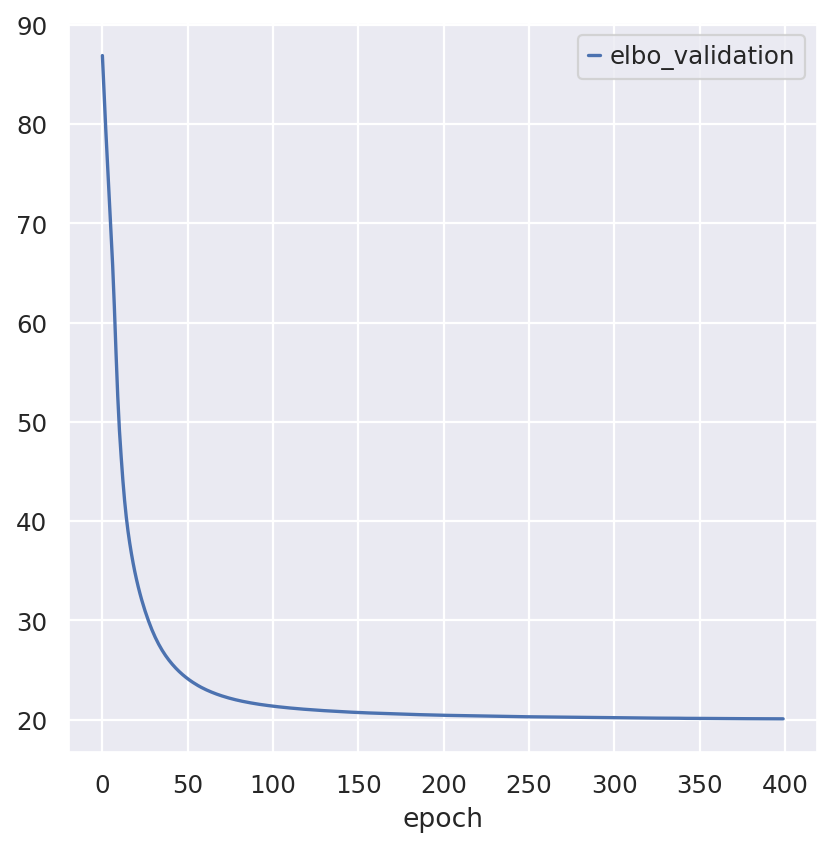

In [11]:
follicular_model.history["elbo_validation"].plot()

### Predict and plot assigned cell types

Predict the soft cell type assignment probability for each cell.

In [12]:
predictions = follicular_model.predict()
predictions.head()

,B cells,Cytotoxic T cells,CD4 T cells,Tfh,other
0,1.000000e+00,9.676685e-20,6.941236e-16,1.600126e-17,3.570404e-15
1,1.000000e+00,1.331208e-21,8.170073e-18,1.016939e-19,6.024762e-17
2,1.000000e+00,1.138781e-26,1.044258e-22,1.005804e-24,1.051596e-21
3,1.000000e+00,1.409212e-44,9.456494e-38,1.897248e-40,2.415008e-34
4,3.182719e-17,5.300728e-13,9.995208e-01,4.792132e-04,2.067002e-18


We can visualize the probabilities of assignment with a heatmap that returns the probability matrix for each cell and cell type.

/env/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


/env/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


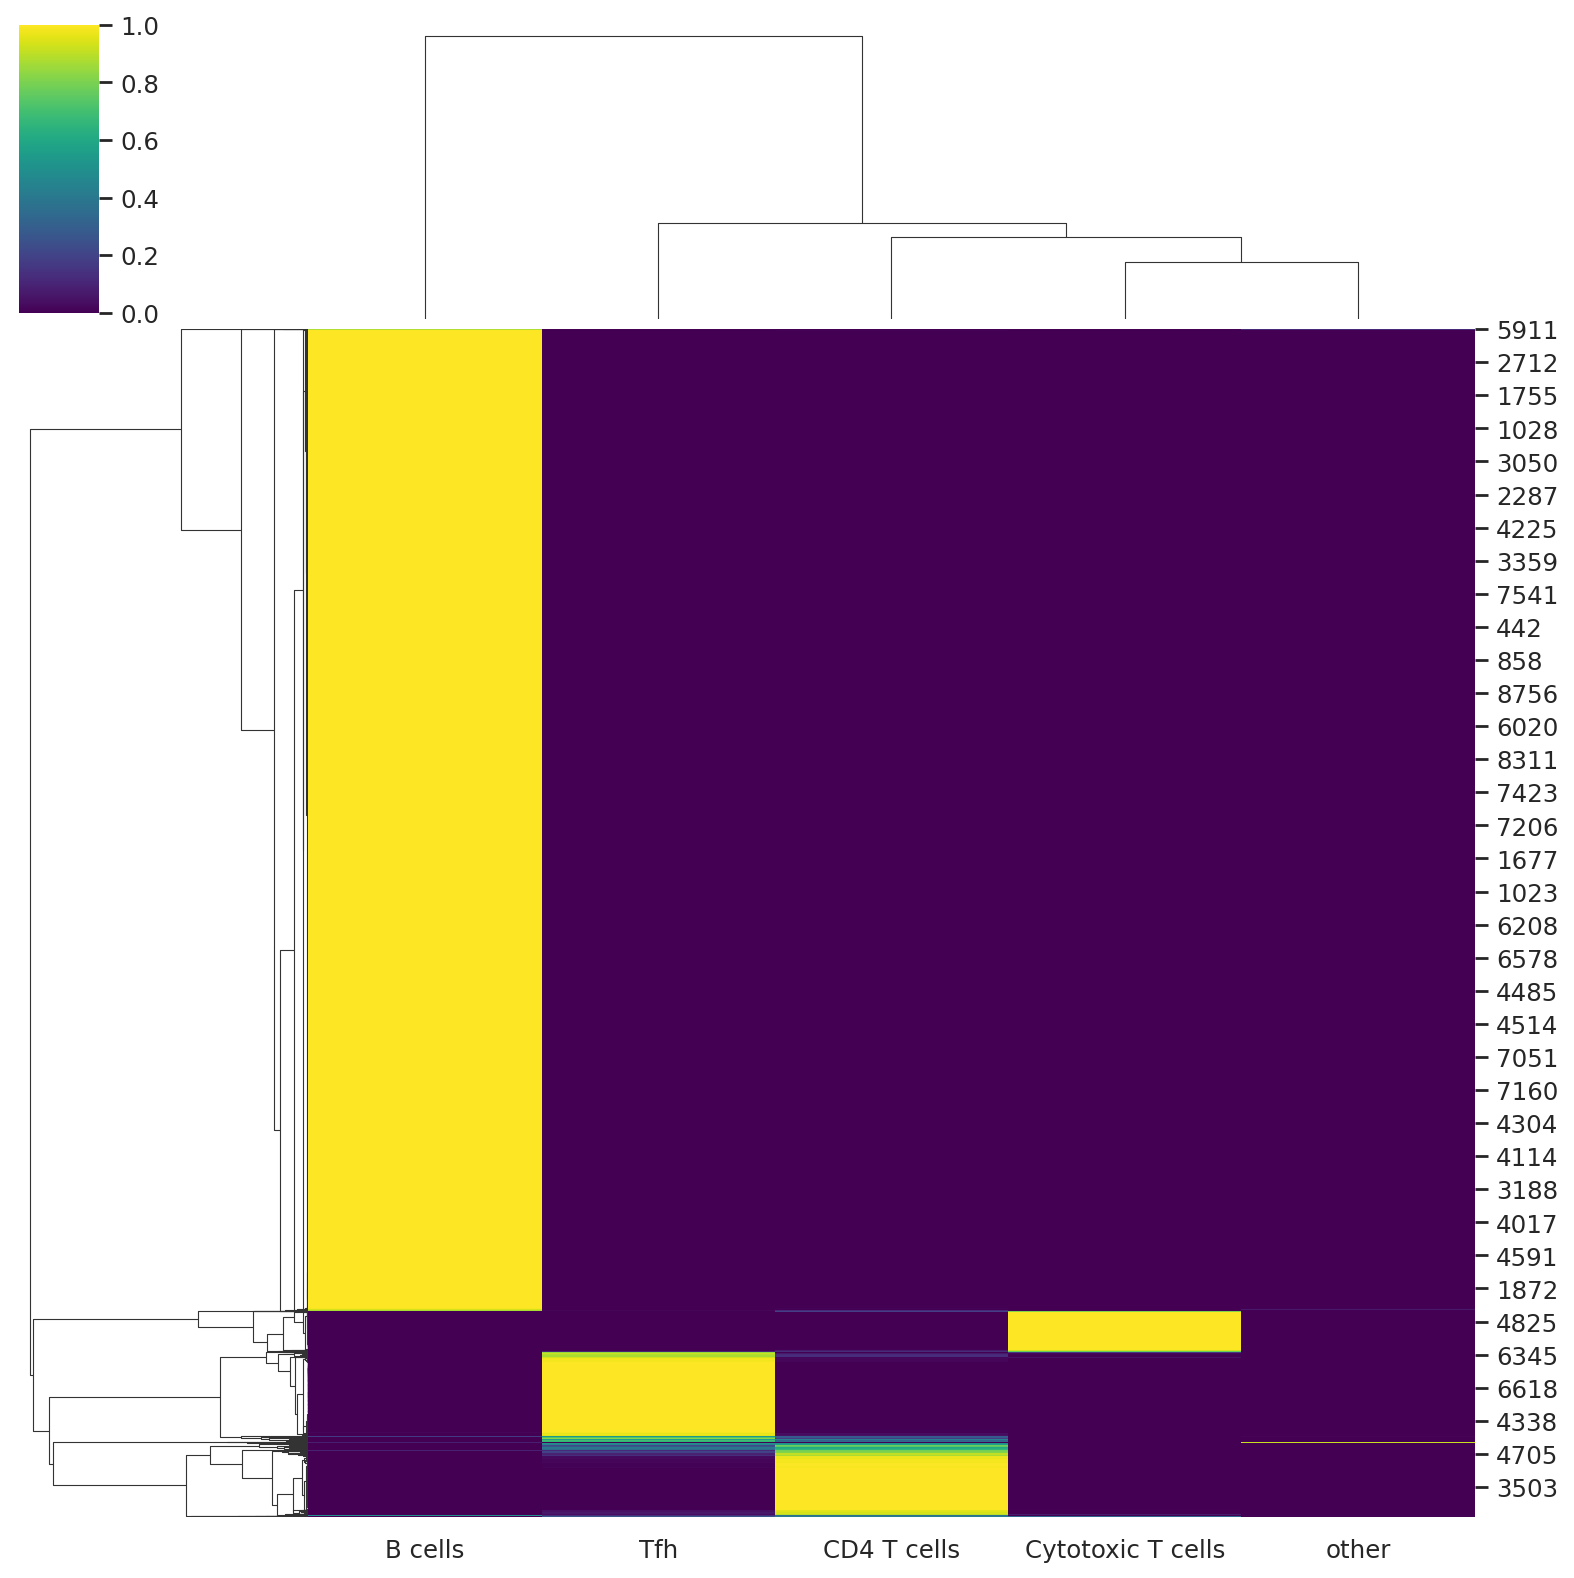

In [13]:
sns.clustermap(predictions, cmap="viridis")

We then create a UMAP plot labeled by maximum probability assignments from the CellAssign model. The left plot contains the true cell types and the right plot contains our model's predictions.

In [14]:
follicular_bdata.obs["cellassign_predictions"] = predictions.idxmax(axis=1).values

/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:

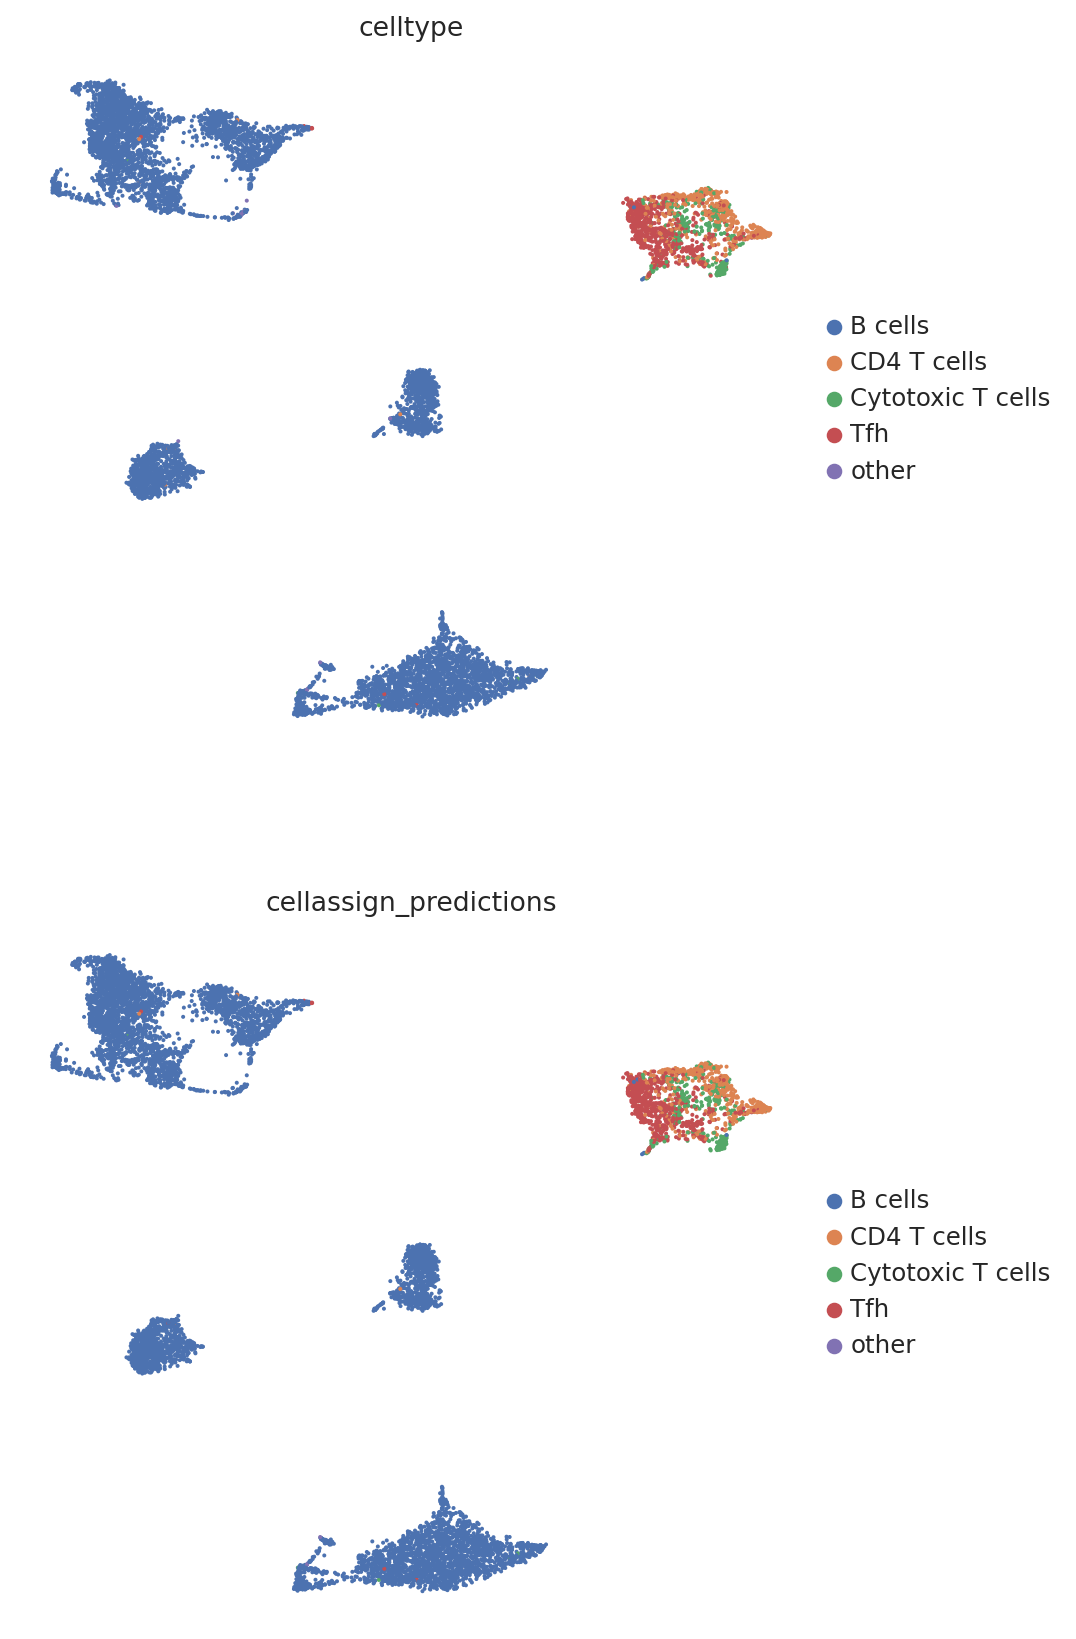

In [15]:
# celltype is the original CellAssign prediction
sc.pl.umap(
    follicular_bdata,
    color=["celltype", "cellassign_predictions"],
    frameon=False,
    ncols=1,
)

### Model reproducibility

We see that the scvi-tools implementation highly reproduces the original implementation's predictions.

/tmp/ipykernel_158/3559355083.py:8: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


<Axes: xlabel='Original predictions', ylabel='cellassign_predictions'>

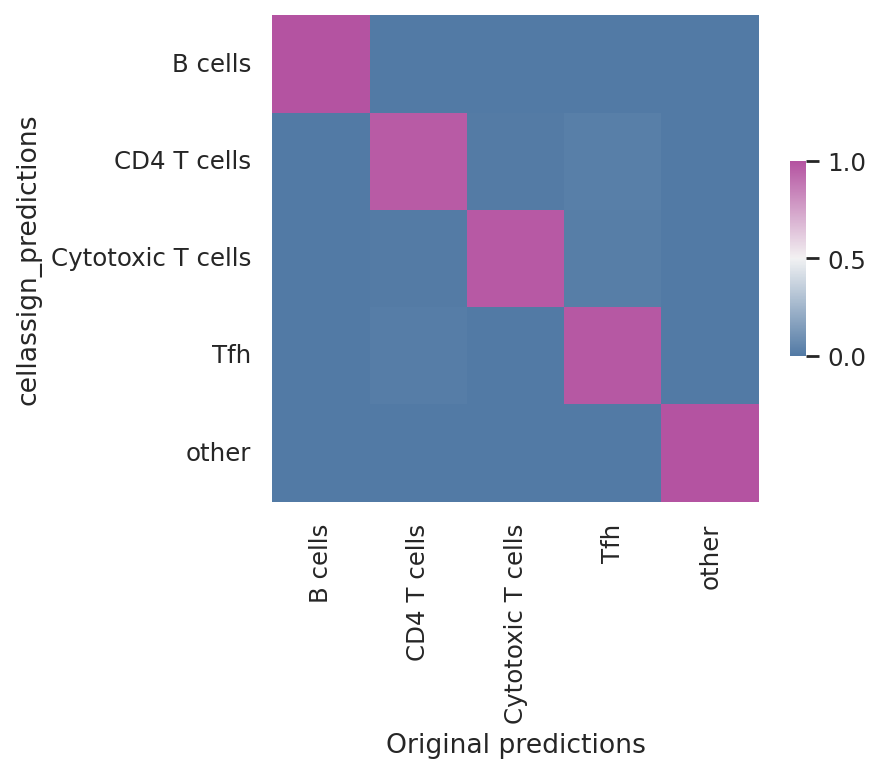

In [16]:
df = follicular_bdata.obs
confusion_matrix = pd.crosstab(
    df["cellassign_predictions"],
    df["celltype"],
    rownames=["cellassign_predictions"],
    colnames=["Original predictions"],
)
confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(
    confusion_matrix,
    cmap=sns.diverging_palette(245, 320, s=60, as_cmap=True),
    ax=ax,
    square=True,
    cbar_kws={"shrink": 0.4, "aspect": 12},
)

## HGSC Data

We can repeat the same process for HGSC data.

In [17]:
hgsc_adata = scvi.data.read_h5ad(sce_hgsc_path)
hgsc_celltype_markers = pd.read_csv(hgsc_celltype_path, index_col=0)

hgsc_adata.var_names_make_unique()
hgsc_adata.obs_names_make_unique()

hgsc_adata

/env/lib/python3.11/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/env/lib/python3.11/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 4848 × 33694
    obs: 'Sample', 'dataset', 'patient', 'timepoint', 'site', 'sample_barcode', 'is_cell_control', 'total_features_by_counts', 'log10_total_features_by_counts', 'total_counts', 'log10_total_counts', 'pct_counts_in_top_50_features', 'pct_counts_in_top_100_features', 'pct_counts_in_top_200_features', 'pct_counts_in_top_500_features', 'total_features_by_counts_endogenous', 'log10_total_features_by_counts_endogenous', 'total_counts_endogenous', 'log10_total_counts_endogenous', 'pct_counts_endogenous', 'pct_counts_in_top_50_features_endogenous', 'pct_counts_in_top_100_features_endogenous', 'pct_counts_in_top_200_features_endogenous', 'pct_counts_in_top_500_features_endogenous', 'total_features_by_counts_feature_control', 'log10_total_features_by_counts_feature_control', 'total_counts_feature_control', 'log10_total_counts_feature_control', 'pct_counts_feature_control', 'pct_counts_in_top_50_features_feature_control', 'pct_counts_in_top_100_fe

### Create and fit CellAssign model

In [18]:
hgsc_bdata = hgsc_adata[:, hgsc_celltype_markers.index].copy()

In [19]:
scvi.external.CellAssign.setup_anndata(hgsc_bdata, "size_factor")

In [20]:
hgsc_model = CellAssign(hgsc_bdata, hgsc_celltype_markers)
hgsc_model.train()

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
/env/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.



Training:   0%|          | 0/400 [00:00<?, ?it/s]


Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]


Epoch 1/400:   0%|          | 1/400 [00:00<00:16, 24.92it/s, v_num=1, train_loss_step=108, train_loss_epoch=115]


Epoch 2/400:   0%|          | 1/400 [00:00<00:17, 22.96it/s, v_num=1, train_loss_step=108, train_loss_epoch=115]


Epoch 2/400:   0%|          | 2/400 [00:00<00:15, 25.90it/s, v_num=1, train_loss_step=100, train_loss_epoch=105]


Epoch 3/400:   0%|          | 2/400 [00:00<00:15, 25.23it/s, v_num=1, train_loss_step=100, train_loss_epoch=105]


Epoch 3/400:   1%|          | 3/400 [00:00<00:14, 26.77it/s, v_num=1, train_loss_step=100, train_loss_epoch=105]


Epoch 3/400:   1%|          | 3/400 [00:00<00:14, 26.77it/s, v_num=1, train_loss_step=95.2, train_loss_epoch=103]


Epoch 4/400:   1%|          | 3/400 [00:00<00:14, 26.77it/s, v_num=1, train_loss_step=95.2, train_loss_epoch=103]


Epoch 4/400:   1%|          | 4/400 [00:00<00:14, 26.77it/s, v_num=1, train_loss_step=96.3, train_loss_epoch=100]


Epoch 5/400:   1%|          | 4/400 [00:00<00:14, 26.77it/s, v_num=1, train_loss_step=96.3, train_loss_epoch=100]


Epoch 5/400:   1%|▏         | 5/400 [00:00<00:14, 26.77it/s, v_num=1, train_loss_step=97.7, train_loss_epoch=97.4]


Epoch 6/400:   1%|▏         | 5/400 [00:00<00:14, 26.77it/s, v_num=1, train_loss_step=97.7, train_loss_epoch=97.4]


Epoch 6/400:   2%|▏         | 6/400 [00:00<00:14, 27.64it/s, v_num=1, train_loss_step=97.7, train_loss_epoch=97.4]


Epoch 6/400:   2%|▏         | 6/400 [00:00<00:14, 27.64it/s, v_num=1, train_loss_step=92.6, train_loss_epoch=95]  


Epoch 7/400:   2%|▏         | 6/400 [00:00<00:14, 27.64it/s, v_num=1, train_loss_step=92.6, train_loss_epoch=95]


Epoch 7/400:   2%|▏         | 7/400 [00:00<00:14, 27.64it/s, v_num=1, train_loss_step=89.8, train_loss_epoch=92.7]


Epoch 8/400:   2%|▏         | 7/400 [00:00<00:14, 27.64it/s, v_num=1, train_loss_step=89.8, train_loss_epoch=92.7]


Epoch 8/400:   2%|▏         | 8/400 [00:00<00:14, 27.64it/s, v_num=1, train_loss_step=89.1, train_loss_epoch=90.5]


Epoch 9/400:   2%|▏         | 8/400 [00:00<00:14, 27.64it/s, v_num=1, train_loss_step=89.1, train_loss_epoch=90.5]


Epoch 9/400:   2%|▏         | 9/400 [00:00<00:13, 27.95it/s, v_num=1, train_loss_step=89.1, train_loss_epoch=90.5]


Epoch 9/400:   2%|▏         | 9/400 [00:00<00:13, 27.95it/s, v_num=1, train_loss_step=90.7, train_loss_epoch=88.4]


Epoch 10/400:   2%|▏         | 9/400 [00:00<00:13, 27.95it/s, v_num=1, train_loss_step=90.7, train_loss_epoch=88.4]


Epoch 10/400:   2%|▎         | 10/400 [00:00<00:13, 27.95it/s, v_num=1, train_loss_step=86.1, train_loss_epoch=86.4]


Epoch 11/400:   2%|▎         | 10/400 [00:00<00:13, 27.95it/s, v_num=1, train_loss_step=86.1, train_loss_epoch=86.4]


Epoch 11/400:   3%|▎         | 11/400 [00:00<00:13, 27.95it/s, v_num=1, train_loss_step=83.5, train_loss_epoch=84.5]


Epoch 12/400:   3%|▎         | 11/400 [00:00<00:13, 27.95it/s, v_num=1, train_loss_step=83.5, train_loss_epoch=84.5]


Epoch 12/400:   3%|▎         | 12/400 [00:00<00:13, 28.01it/s, v_num=1, train_loss_step=83.5, train_loss_epoch=84.5]


Epoch 12/400:   3%|▎         | 12/400 [00:00<00:13, 28.01it/s, v_num=1, train_loss_step=82.6, train_loss_epoch=82.7]


Epoch 13/400:   3%|▎         | 12/400 [00:00<00:13, 28.01it/s, v_num=1, train_loss_step=82.6, train_loss_epoch=82.7]


Epoch 13/400:   3%|▎         | 13/400 [00:00<00:13, 28.01it/s, v_num=1, train_loss_step=79.7, train_loss_epoch=81.1]


Epoch 14/400:   3%|▎         | 13/400 [00:00<00:13, 28.01it/s, v_num=1, train_loss_step=79.7, train_loss_epoch=81.1]


Epoch 14/400:   4%|▎         | 14/400 [00:00<00:13, 28.01it/s, v_num=1, train_loss_step=80.1, train_loss_epoch=79.5]


Epoch 15/400:   4%|▎         | 14/400 [00:00<00:13, 28.01it/s, v_num=1, train_loss_step=80.1, train_loss_epoch=79.5]


Epoch 15/400:   4%|▍         | 15/400 [00:00<00:13, 28.05it/s, v_num=1, train_loss_step=80.1, train_loss_epoch=79.5]


Epoch 15/400:   4%|▍         | 15/400 [00:00<00:13, 28.05it/s, v_num=1, train_loss_step=78.7, train_loss_epoch=77.9]


Epoch 16/400:   4%|▍         | 15/400 [00:00<00:13, 28.05it/s, v_num=1, train_loss_step=78.7, train_loss_epoch=77.9]


Epoch 16/400:   4%|▍         | 16/400 [00:00<00:13, 28.05it/s, v_num=1, train_loss_step=76.9, train_loss_epoch=76.5]


Epoch 17/400:   4%|▍         | 16/400 [00:00<00:13, 28.05it/s, v_num=1, train_loss_step=76.9, train_loss_epoch=76.5]


Epoch 17/400:   4%|▍         | 17/400 [00:00<00:13, 28.05it/s, v_num=1, train_loss_step=72.5, train_loss_epoch=75.2]


Epoch 18/400:   4%|▍         | 17/400 [00:00<00:13, 28.05it/s, v_num=1, train_loss_step=72.5, train_loss_epoch=75.2]


Epoch 18/400:   4%|▍         | 18/400 [00:00<00:13, 28.03it/s, v_num=1, train_loss_step=72.5, train_loss_epoch=75.2]


Epoch 18/400:   4%|▍         | 18/400 [00:00<00:13, 28.03it/s, v_num=1, train_loss_step=71.3, train_loss_epoch=73.9]


Epoch 19/400:   4%|▍         | 18/400 [00:00<00:13, 28.03it/s, v_num=1, train_loss_step=71.3, train_loss_epoch=73.9]


Epoch 19/400:   5%|▍         | 19/400 [00:00<00:13, 28.03it/s, v_num=1, train_loss_step=71.6, train_loss_epoch=72.7]


Epoch 20/400:   5%|▍         | 19/400 [00:00<00:13, 28.03it/s, v_num=1, train_loss_step=71.6, train_loss_epoch=72.7]


Epoch 20/400:   5%|▌         | 20/400 [00:00<00:13, 28.03it/s, v_num=1, train_loss_step=72.8, train_loss_epoch=71.6]


Epoch 21/400:   5%|▌         | 20/400 [00:00<00:13, 28.03it/s, v_num=1, train_loss_step=72.8, train_loss_epoch=71.6]


Epoch 21/400:   5%|▌         | 21/400 [00:00<00:13, 28.08it/s, v_num=1, train_loss_step=72.8, train_loss_epoch=71.6]


Epoch 21/400:   5%|▌         | 21/400 [00:00<00:13, 28.08it/s, v_num=1, train_loss_step=67.7, train_loss_epoch=70.5]


Epoch 22/400:   5%|▌         | 21/400 [00:00<00:13, 28.08it/s, v_num=1, train_loss_step=67.7, train_loss_epoch=70.5]


Epoch 22/400:   6%|▌         | 22/400 [00:00<00:13, 28.08it/s, v_num=1, train_loss_step=68.1, train_loss_epoch=69.5]


Epoch 23/400:   6%|▌         | 22/400 [00:00<00:13, 28.08it/s, v_num=1, train_loss_step=68.1, train_loss_epoch=69.5]


Epoch 23/400:   6%|▌         | 23/400 [00:00<00:13, 28.08it/s, v_num=1, train_loss_step=66.7, train_loss_epoch=68.5]


Epoch 24/400:   6%|▌         | 23/400 [00:00<00:13, 28.08it/s, v_num=1, train_loss_step=66.7, train_loss_epoch=68.5]


Epoch 24/400:   6%|▌         | 24/400 [00:00<00:13, 27.78it/s, v_num=1, train_loss_step=66.7, train_loss_epoch=68.5]


Epoch 24/400:   6%|▌         | 24/400 [00:00<00:13, 27.78it/s, v_num=1, train_loss_step=64.7, train_loss_epoch=67.6]


Epoch 25/400:   6%|▌         | 24/400 [00:00<00:13, 27.78it/s, v_num=1, train_loss_step=64.7, train_loss_epoch=67.6]


Epoch 25/400:   6%|▋         | 25/400 [00:00<00:13, 27.78it/s, v_num=1, train_loss_step=65.7, train_loss_epoch=66.8]


Epoch 26/400:   6%|▋         | 25/400 [00:00<00:13, 27.78it/s, v_num=1, train_loss_step=65.7, train_loss_epoch=66.8]


Epoch 26/400:   6%|▋         | 26/400 [00:00<00:13, 27.78it/s, v_num=1, train_loss_step=66.3, train_loss_epoch=65.9]


Epoch 27/400:   6%|▋         | 26/400 [00:00<00:13, 27.78it/s, v_num=1, train_loss_step=66.3, train_loss_epoch=65.9]


Epoch 27/400:   7%|▋         | 27/400 [00:00<00:13, 27.55it/s, v_num=1, train_loss_step=66.3, train_loss_epoch=65.9]


Epoch 27/400:   7%|▋         | 27/400 [00:00<00:13, 27.55it/s, v_num=1, train_loss_step=62.9, train_loss_epoch=65.2]


Epoch 28/400:   7%|▋         | 27/400 [00:00<00:13, 27.55it/s, v_num=1, train_loss_step=62.9, train_loss_epoch=65.2]


Epoch 28/400:   7%|▋         | 28/400 [00:01<00:13, 27.55it/s, v_num=1, train_loss_step=63.7, train_loss_epoch=64.4]


Epoch 29/400:   7%|▋         | 28/400 [00:01<00:13, 27.55it/s, v_num=1, train_loss_step=63.7, train_loss_epoch=64.4]


Epoch 29/400:   7%|▋         | 29/400 [00:01<00:13, 27.55it/s, v_num=1, train_loss_step=64.4, train_loss_epoch=63.7]


Epoch 30/400:   7%|▋         | 29/400 [00:01<00:13, 27.55it/s, v_num=1, train_loss_step=64.4, train_loss_epoch=63.7]


Epoch 30/400:   8%|▊         | 30/400 [00:01<00:13, 27.49it/s, v_num=1, train_loss_step=64.4, train_loss_epoch=63.7]


Epoch 30/400:   8%|▊         | 30/400 [00:01<00:13, 27.49it/s, v_num=1, train_loss_step=62.5, train_loss_epoch=63]  


Epoch 31/400:   8%|▊         | 30/400 [00:01<00:13, 27.49it/s, v_num=1, train_loss_step=62.5, train_loss_epoch=63]


Epoch 31/400:   8%|▊         | 31/400 [00:01<00:13, 27.49it/s, v_num=1, train_loss_step=62, train_loss_epoch=62.4]


Epoch 32/400:   8%|▊         | 31/400 [00:01<00:13, 27.49it/s, v_num=1, train_loss_step=62, train_loss_epoch=62.4]


Epoch 32/400:   8%|▊         | 32/400 [00:01<00:13, 27.49it/s, v_num=1, train_loss_step=61.1, train_loss_epoch=61.8]


Epoch 33/400:   8%|▊         | 32/400 [00:01<00:13, 27.49it/s, v_num=1, train_loss_step=61.1, train_loss_epoch=61.8]


Epoch 33/400:   8%|▊         | 33/400 [00:01<00:13, 27.48it/s, v_num=1, train_loss_step=61.1, train_loss_epoch=61.8]


Epoch 33/400:   8%|▊         | 33/400 [00:01<00:13, 27.48it/s, v_num=1, train_loss_step=61.2, train_loss_epoch=61.2]


Epoch 34/400:   8%|▊         | 33/400 [00:01<00:13, 27.48it/s, v_num=1, train_loss_step=61.2, train_loss_epoch=61.2]


Epoch 34/400:   8%|▊         | 34/400 [00:01<00:13, 27.48it/s, v_num=1, train_loss_step=61.8, train_loss_epoch=60.7]


Epoch 35/400:   8%|▊         | 34/400 [00:01<00:13, 27.48it/s, v_num=1, train_loss_step=61.8, train_loss_epoch=60.7]


Epoch 35/400:   9%|▉         | 35/400 [00:01<00:13, 27.48it/s, v_num=1, train_loss_step=59.7, train_loss_epoch=60.1]


Epoch 36/400:   9%|▉         | 35/400 [00:01<00:13, 27.48it/s, v_num=1, train_loss_step=59.7, train_loss_epoch=60.1]


Epoch 36/400:   9%|▉         | 36/400 [00:01<00:13, 27.49it/s, v_num=1, train_loss_step=59.7, train_loss_epoch=60.1]


Epoch 36/400:   9%|▉         | 36/400 [00:01<00:13, 27.49it/s, v_num=1, train_loss_step=60.4, train_loss_epoch=59.6]


Epoch 37/400:   9%|▉         | 36/400 [00:01<00:13, 27.49it/s, v_num=1, train_loss_step=60.4, train_loss_epoch=59.6]


Epoch 37/400:   9%|▉         | 37/400 [00:01<00:13, 27.49it/s, v_num=1, train_loss_step=57.9, train_loss_epoch=59.1]


Epoch 38/400:   9%|▉         | 37/400 [00:01<00:13, 27.49it/s, v_num=1, train_loss_step=57.9, train_loss_epoch=59.1]


Epoch 38/400:  10%|▉         | 38/400 [00:01<00:13, 27.49it/s, v_num=1, train_loss_step=58.1, train_loss_epoch=58.6]


Epoch 39/400:  10%|▉         | 38/400 [00:01<00:13, 27.49it/s, v_num=1, train_loss_step=58.1, train_loss_epoch=58.6]


Epoch 39/400:  10%|▉         | 39/400 [00:01<00:13, 27.59it/s, v_num=1, train_loss_step=58.1, train_loss_epoch=58.6]


Epoch 39/400:  10%|▉         | 39/400 [00:01<00:13, 27.59it/s, v_num=1, train_loss_step=58.2, train_loss_epoch=58.2]


Epoch 40/400:  10%|▉         | 39/400 [00:01<00:13, 27.59it/s, v_num=1, train_loss_step=58.2, train_loss_epoch=58.2]


Epoch 40/400:  10%|█         | 40/400 [00:01<00:13, 27.59it/s, v_num=1, train_loss_step=57.2, train_loss_epoch=57.7]


Epoch 41/400:  10%|█         | 40/400 [00:01<00:13, 27.59it/s, v_num=1, train_loss_step=57.2, train_loss_epoch=57.7]


Epoch 41/400:  10%|█         | 41/400 [00:01<00:13, 27.59it/s, v_num=1, train_loss_step=55.9, train_loss_epoch=57.3]


Epoch 42/400:  10%|█         | 41/400 [00:01<00:13, 27.59it/s, v_num=1, train_loss_step=55.9, train_loss_epoch=57.3]


Epoch 42/400:  10%|█         | 42/400 [00:01<00:12, 27.63it/s, v_num=1, train_loss_step=55.9, train_loss_epoch=57.3]


Epoch 42/400:  10%|█         | 42/400 [00:01<00:12, 27.63it/s, v_num=1, train_loss_step=56.4, train_loss_epoch=56.9]


Epoch 43/400:  10%|█         | 42/400 [00:01<00:12, 27.63it/s, v_num=1, train_loss_step=56.4, train_loss_epoch=56.9]


Epoch 43/400:  11%|█         | 43/400 [00:01<00:12, 27.63it/s, v_num=1, train_loss_step=56.3, train_loss_epoch=56.5]


Epoch 44/400:  11%|█         | 43/400 [00:01<00:12, 27.63it/s, v_num=1, train_loss_step=56.3, train_loss_epoch=56.5]


Epoch 44/400:  11%|█         | 44/400 [00:01<00:12, 27.63it/s, v_num=1, train_loss_step=56.9, train_loss_epoch=56.1]


Epoch 45/400:  11%|█         | 44/400 [00:01<00:12, 27.63it/s, v_num=1, train_loss_step=56.9, train_loss_epoch=56.1]


Epoch 45/400:  11%|█▏        | 45/400 [00:01<00:12, 27.68it/s, v_num=1, train_loss_step=56.9, train_loss_epoch=56.1]


Epoch 45/400:  11%|█▏        | 45/400 [00:01<00:12, 27.68it/s, v_num=1, train_loss_step=56.4, train_loss_epoch=55.8]


Epoch 46/400:  11%|█▏        | 45/400 [00:01<00:12, 27.68it/s, v_num=1, train_loss_step=56.4, train_loss_epoch=55.8]


Epoch 46/400:  12%|█▏        | 46/400 [00:01<00:12, 27.68it/s, v_num=1, train_loss_step=57.1, train_loss_epoch=55.4]


Epoch 47/400:  12%|█▏        | 46/400 [00:01<00:12, 27.68it/s, v_num=1, train_loss_step=57.1, train_loss_epoch=55.4]


Epoch 47/400:  12%|█▏        | 47/400 [00:01<00:12, 27.68it/s, v_num=1, train_loss_step=56.4, train_loss_epoch=55.1]


Epoch 48/400:  12%|█▏        | 47/400 [00:01<00:12, 27.68it/s, v_num=1, train_loss_step=56.4, train_loss_epoch=55.1]


Epoch 48/400:  12%|█▏        | 48/400 [00:01<00:12, 27.70it/s, v_num=1, train_loss_step=56.4, train_loss_epoch=55.1]


Epoch 48/400:  12%|█▏        | 48/400 [00:01<00:12, 27.70it/s, v_num=1, train_loss_step=54.8, train_loss_epoch=54.8]


Epoch 49/400:  12%|█▏        | 48/400 [00:01<00:12, 27.70it/s, v_num=1, train_loss_step=54.8, train_loss_epoch=54.8]


Epoch 49/400:  12%|█▏        | 49/400 [00:01<00:12, 27.70it/s, v_num=1, train_loss_step=55.3, train_loss_epoch=54.4]


Epoch 50/400:  12%|█▏        | 49/400 [00:01<00:12, 27.70it/s, v_num=1, train_loss_step=55.3, train_loss_epoch=54.4]


Epoch 50/400:  12%|█▎        | 50/400 [00:01<00:12, 27.70it/s, v_num=1, train_loss_step=56.9, train_loss_epoch=54.1]


Epoch 51/400:  12%|█▎        | 50/400 [00:01<00:12, 27.70it/s, v_num=1, train_loss_step=56.9, train_loss_epoch=54.1]


Epoch 51/400:  13%|█▎        | 51/400 [00:01<00:12, 27.68it/s, v_num=1, train_loss_step=56.9, train_loss_epoch=54.1]


Epoch 51/400:  13%|█▎        | 51/400 [00:01<00:12, 27.68it/s, v_num=1, train_loss_step=53.8, train_loss_epoch=53.8]


Epoch 52/400:  13%|█▎        | 51/400 [00:01<00:12, 27.68it/s, v_num=1, train_loss_step=53.8, train_loss_epoch=53.8]


Epoch 52/400:  13%|█▎        | 52/400 [00:01<00:12, 27.68it/s, v_num=1, train_loss_step=54.2, train_loss_epoch=53.5]


Epoch 53/400:  13%|█▎        | 52/400 [00:01<00:12, 27.68it/s, v_num=1, train_loss_step=54.2, train_loss_epoch=53.5]


Epoch 53/400:  13%|█▎        | 53/400 [00:01<00:12, 27.68it/s, v_num=1, train_loss_step=54, train_loss_epoch=53.3]  


Epoch 54/400:  13%|█▎        | 53/400 [00:01<00:12, 27.68it/s, v_num=1, train_loss_step=54, train_loss_epoch=53.3]


Epoch 54/400:  14%|█▎        | 54/400 [00:01<00:12, 27.67it/s, v_num=1, train_loss_step=54, train_loss_epoch=53.3]


Epoch 54/400:  14%|█▎        | 54/400 [00:01<00:12, 27.67it/s, v_num=1, train_loss_step=52.1, train_loss_epoch=53]


Epoch 55/400:  14%|█▎        | 54/400 [00:01<00:12, 27.67it/s, v_num=1, train_loss_step=52.1, train_loss_epoch=53]


Epoch 55/400:  14%|█▍        | 55/400 [00:01<00:12, 27.67it/s, v_num=1, train_loss_step=50.8, train_loss_epoch=52.7]


Epoch 56/400:  14%|█▍        | 55/400 [00:01<00:12, 27.67it/s, v_num=1, train_loss_step=50.8, train_loss_epoch=52.7]


Epoch 56/400:  14%|█▍        | 56/400 [00:02<00:12, 27.67it/s, v_num=1, train_loss_step=53.4, train_loss_epoch=52.5]


Epoch 57/400:  14%|█▍        | 56/400 [00:02<00:12, 27.67it/s, v_num=1, train_loss_step=53.4, train_loss_epoch=52.5]


Epoch 57/400:  14%|█▍        | 57/400 [00:02<00:12, 27.71it/s, v_num=1, train_loss_step=53.4, train_loss_epoch=52.5]


Epoch 57/400:  14%|█▍        | 57/400 [00:02<00:12, 27.71it/s, v_num=1, train_loss_step=53.3, train_loss_epoch=52.2]


Epoch 58/400:  14%|█▍        | 57/400 [00:02<00:12, 27.71it/s, v_num=1, train_loss_step=53.3, train_loss_epoch=52.2]


Epoch 58/400:  14%|█▍        | 58/400 [00:02<00:12, 27.71it/s, v_num=1, train_loss_step=52, train_loss_epoch=52]    


Epoch 59/400:  14%|█▍        | 58/400 [00:02<00:12, 27.71it/s, v_num=1, train_loss_step=52, train_loss_epoch=52]


Epoch 59/400:  15%|█▍        | 59/400 [00:02<00:12, 27.71it/s, v_num=1, train_loss_step=51.4, train_loss_epoch=51.7]


Epoch 60/400:  15%|█▍        | 59/400 [00:02<00:12, 27.71it/s, v_num=1, train_loss_step=51.4, train_loss_epoch=51.7]


Epoch 60/400:  15%|█▌        | 60/400 [00:02<00:12, 27.66it/s, v_num=1, train_loss_step=51.4, train_loss_epoch=51.7]


Epoch 60/400:  15%|█▌        | 60/400 [00:02<00:12, 27.66it/s, v_num=1, train_loss_step=51.7, train_loss_epoch=51.5]


Epoch 61/400:  15%|█▌        | 60/400 [00:02<00:12, 27.66it/s, v_num=1, train_loss_step=51.7, train_loss_epoch=51.5]


Epoch 61/400:  15%|█▌        | 61/400 [00:02<00:12, 27.66it/s, v_num=1, train_loss_step=50.5, train_loss_epoch=51.3]


Epoch 62/400:  15%|█▌        | 61/400 [00:02<00:12, 27.66it/s, v_num=1, train_loss_step=50.5, train_loss_epoch=51.3]


Epoch 62/400:  16%|█▌        | 62/400 [00:02<00:12, 27.66it/s, v_num=1, train_loss_step=49.1, train_loss_epoch=51.1]


Epoch 63/400:  16%|█▌        | 62/400 [00:02<00:12, 27.66it/s, v_num=1, train_loss_step=49.1, train_loss_epoch=51.1]


Epoch 63/400:  16%|█▌        | 63/400 [00:02<00:12, 27.71it/s, v_num=1, train_loss_step=49.1, train_loss_epoch=51.1]


Epoch 63/400:  16%|█▌        | 63/400 [00:02<00:12, 27.71it/s, v_num=1, train_loss_step=51, train_loss_epoch=50.9]  


Epoch 64/400:  16%|█▌        | 63/400 [00:02<00:12, 27.71it/s, v_num=1, train_loss_step=51, train_loss_epoch=50.9]


Epoch 64/400:  16%|█▌        | 64/400 [00:02<00:12, 27.71it/s, v_num=1, train_loss_step=51.2, train_loss_epoch=50.6]


Epoch 65/400:  16%|█▌        | 64/400 [00:02<00:12, 27.71it/s, v_num=1, train_loss_step=51.2, train_loss_epoch=50.6]


Epoch 65/400:  16%|█▋        | 65/400 [00:02<00:12, 27.71it/s, v_num=1, train_loss_step=51.1, train_loss_epoch=50.4]


Epoch 66/400:  16%|█▋        | 65/400 [00:02<00:12, 27.71it/s, v_num=1, train_loss_step=51.1, train_loss_epoch=50.4]


Epoch 66/400:  16%|█▋        | 66/400 [00:02<00:12, 27.69it/s, v_num=1, train_loss_step=51.1, train_loss_epoch=50.4]


Epoch 66/400:  16%|█▋        | 66/400 [00:02<00:12, 27.69it/s, v_num=1, train_loss_step=49.6, train_loss_epoch=50.3]


Epoch 67/400:  16%|█▋        | 66/400 [00:02<00:12, 27.69it/s, v_num=1, train_loss_step=49.6, train_loss_epoch=50.3]


Epoch 67/400:  17%|█▋        | 67/400 [00:02<00:12, 27.69it/s, v_num=1, train_loss_step=49.4, train_loss_epoch=50.1]


Epoch 68/400:  17%|█▋        | 67/400 [00:02<00:12, 27.69it/s, v_num=1, train_loss_step=49.4, train_loss_epoch=50.1]


Epoch 68/400:  17%|█▋        | 68/400 [00:02<00:11, 27.69it/s, v_num=1, train_loss_step=51.1, train_loss_epoch=49.9]


Epoch 69/400:  17%|█▋        | 68/400 [00:02<00:11, 27.69it/s, v_num=1, train_loss_step=51.1, train_loss_epoch=49.9]


Epoch 69/400:  17%|█▋        | 69/400 [00:02<00:11, 27.70it/s, v_num=1, train_loss_step=51.1, train_loss_epoch=49.9]


Epoch 69/400:  17%|█▋        | 69/400 [00:02<00:11, 27.70it/s, v_num=1, train_loss_step=48.4, train_loss_epoch=49.7]


Epoch 70/400:  17%|█▋        | 69/400 [00:02<00:11, 27.70it/s, v_num=1, train_loss_step=48.4, train_loss_epoch=49.7]


Epoch 70/400:  18%|█▊        | 70/400 [00:02<00:11, 27.70it/s, v_num=1, train_loss_step=48.7, train_loss_epoch=49.5]


Epoch 71/400:  18%|█▊        | 70/400 [00:02<00:11, 27.70it/s, v_num=1, train_loss_step=48.7, train_loss_epoch=49.5]


Epoch 71/400:  18%|█▊        | 71/400 [00:02<00:11, 27.70it/s, v_num=1, train_loss_step=50.8, train_loss_epoch=49.4]


Epoch 72/400:  18%|█▊        | 71/400 [00:02<00:11, 27.70it/s, v_num=1, train_loss_step=50.8, train_loss_epoch=49.4]


Epoch 72/400:  18%|█▊        | 72/400 [00:02<00:11, 27.68it/s, v_num=1, train_loss_step=50.8, train_loss_epoch=49.4]


Epoch 72/400:  18%|█▊        | 72/400 [00:02<00:11, 27.68it/s, v_num=1, train_loss_step=48.2, train_loss_epoch=49.2]


Epoch 73/400:  18%|█▊        | 72/400 [00:02<00:11, 27.68it/s, v_num=1, train_loss_step=48.2, train_loss_epoch=49.2]


Epoch 73/400:  18%|█▊        | 73/400 [00:02<00:11, 27.68it/s, v_num=1, train_loss_step=49.4, train_loss_epoch=49]  


Epoch 74/400:  18%|█▊        | 73/400 [00:02<00:11, 27.68it/s, v_num=1, train_loss_step=49.4, train_loss_epoch=49]


Epoch 74/400:  18%|█▊        | 74/400 [00:02<00:11, 27.68it/s, v_num=1, train_loss_step=48.2, train_loss_epoch=48.9]


Epoch 75/400:  18%|█▊        | 74/400 [00:02<00:11, 27.68it/s, v_num=1, train_loss_step=48.2, train_loss_epoch=48.9]


Epoch 75/400:  19%|█▉        | 75/400 [00:02<00:11, 27.69it/s, v_num=1, train_loss_step=48.2, train_loss_epoch=48.9]


Epoch 75/400:  19%|█▉        | 75/400 [00:02<00:11, 27.69it/s, v_num=1, train_loss_step=48, train_loss_epoch=48.7]  


Epoch 76/400:  19%|█▉        | 75/400 [00:02<00:11, 27.69it/s, v_num=1, train_loss_step=48, train_loss_epoch=48.7]


Epoch 76/400:  19%|█▉        | 76/400 [00:02<00:11, 27.69it/s, v_num=1, train_loss_step=48.9, train_loss_epoch=48.6]


Epoch 77/400:  19%|█▉        | 76/400 [00:02<00:11, 27.69it/s, v_num=1, train_loss_step=48.9, train_loss_epoch=48.6]


Epoch 77/400:  19%|█▉        | 77/400 [00:02<00:11, 27.69it/s, v_num=1, train_loss_step=49.2, train_loss_epoch=48.4]


Epoch 78/400:  19%|█▉        | 77/400 [00:02<00:11, 27.69it/s, v_num=1, train_loss_step=49.2, train_loss_epoch=48.4]


Epoch 78/400:  20%|█▉        | 78/400 [00:02<00:11, 27.69it/s, v_num=1, train_loss_step=49.2, train_loss_epoch=48.4]


Epoch 78/400:  20%|█▉        | 78/400 [00:02<00:11, 27.69it/s, v_num=1, train_loss_step=48.7, train_loss_epoch=48.3]


Epoch 79/400:  20%|█▉        | 78/400 [00:02<00:11, 27.69it/s, v_num=1, train_loss_step=48.7, train_loss_epoch=48.3]


Epoch 79/400:  20%|█▉        | 79/400 [00:02<00:11, 27.69it/s, v_num=1, train_loss_step=47.8, train_loss_epoch=48.1]


Epoch 80/400:  20%|█▉        | 79/400 [00:02<00:11, 27.69it/s, v_num=1, train_loss_step=47.8, train_loss_epoch=48.1]


Epoch 80/400:  20%|██        | 80/400 [00:02<00:11, 27.69it/s, v_num=1, train_loss_step=48.8, train_loss_epoch=48]  


Epoch 81/400:  20%|██        | 80/400 [00:02<00:11, 27.69it/s, v_num=1, train_loss_step=48.8, train_loss_epoch=48]


Epoch 81/400:  20%|██        | 81/400 [00:02<00:11, 27.70it/s, v_num=1, train_loss_step=48.8, train_loss_epoch=48]


Epoch 81/400:  20%|██        | 81/400 [00:02<00:11, 27.70it/s, v_num=1, train_loss_step=49.3, train_loss_epoch=47.9]


Epoch 82/400:  20%|██        | 81/400 [00:02<00:11, 27.70it/s, v_num=1, train_loss_step=49.3, train_loss_epoch=47.9]


Epoch 82/400:  20%|██        | 82/400 [00:02<00:11, 27.70it/s, v_num=1, train_loss_step=47.8, train_loss_epoch=47.7]


Epoch 83/400:  20%|██        | 82/400 [00:02<00:11, 27.70it/s, v_num=1, train_loss_step=47.8, train_loss_epoch=47.7]


Epoch 83/400:  21%|██        | 83/400 [00:02<00:11, 27.70it/s, v_num=1, train_loss_step=48.1, train_loss_epoch=47.6]


Epoch 84/400:  21%|██        | 83/400 [00:02<00:11, 27.70it/s, v_num=1, train_loss_step=48.1, train_loss_epoch=47.6]


Epoch 84/400:  21%|██        | 84/400 [00:03<00:11, 27.72it/s, v_num=1, train_loss_step=48.1, train_loss_epoch=47.6]


Epoch 84/400:  21%|██        | 84/400 [00:03<00:11, 27.72it/s, v_num=1, train_loss_step=47, train_loss_epoch=47.5]  


Epoch 85/400:  21%|██        | 84/400 [00:03<00:11, 27.72it/s, v_num=1, train_loss_step=47, train_loss_epoch=47.5]


Epoch 85/400:  21%|██▏       | 85/400 [00:03<00:11, 27.72it/s, v_num=1, train_loss_step=46.5, train_loss_epoch=47.3]


Epoch 86/400:  21%|██▏       | 85/400 [00:03<00:11, 27.72it/s, v_num=1, train_loss_step=46.5, train_loss_epoch=47.3]


Epoch 86/400:  22%|██▏       | 86/400 [00:03<00:11, 27.72it/s, v_num=1, train_loss_step=47.1, train_loss_epoch=47.2]


Epoch 87/400:  22%|██▏       | 86/400 [00:03<00:11, 27.72it/s, v_num=1, train_loss_step=47.1, train_loss_epoch=47.2]


Epoch 87/400:  22%|██▏       | 87/400 [00:03<00:11, 27.75it/s, v_num=1, train_loss_step=47.1, train_loss_epoch=47.2]


Epoch 87/400:  22%|██▏       | 87/400 [00:03<00:11, 27.75it/s, v_num=1, train_loss_step=45.6, train_loss_epoch=47.1]


Epoch 88/400:  22%|██▏       | 87/400 [00:03<00:11, 27.75it/s, v_num=1, train_loss_step=45.6, train_loss_epoch=47.1]


Epoch 88/400:  22%|██▏       | 88/400 [00:03<00:11, 27.75it/s, v_num=1, train_loss_step=48.2, train_loss_epoch=47]  


Epoch 89/400:  22%|██▏       | 88/400 [00:03<00:11, 27.75it/s, v_num=1, train_loss_step=48.2, train_loss_epoch=47]


Epoch 89/400:  22%|██▏       | 89/400 [00:03<00:11, 27.75it/s, v_num=1, train_loss_step=46.2, train_loss_epoch=46.9]


Epoch 90/400:  22%|██▏       | 89/400 [00:03<00:11, 27.75it/s, v_num=1, train_loss_step=46.2, train_loss_epoch=46.9]


Epoch 90/400:  22%|██▎       | 90/400 [00:03<00:11, 27.77it/s, v_num=1, train_loss_step=46.2, train_loss_epoch=46.9]


Epoch 90/400:  22%|██▎       | 90/400 [00:03<00:11, 27.77it/s, v_num=1, train_loss_step=46.3, train_loss_epoch=46.8]


Epoch 91/400:  22%|██▎       | 90/400 [00:03<00:11, 27.77it/s, v_num=1, train_loss_step=46.3, train_loss_epoch=46.8]


Epoch 91/400:  23%|██▎       | 91/400 [00:03<00:11, 27.77it/s, v_num=1, train_loss_step=46.4, train_loss_epoch=46.6]


Epoch 92/400:  23%|██▎       | 91/400 [00:03<00:11, 27.77it/s, v_num=1, train_loss_step=46.4, train_loss_epoch=46.6]


Epoch 92/400:  23%|██▎       | 92/400 [00:03<00:11, 27.77it/s, v_num=1, train_loss_step=46, train_loss_epoch=46.5]  


Epoch 93/400:  23%|██▎       | 92/400 [00:03<00:11, 27.77it/s, v_num=1, train_loss_step=46, train_loss_epoch=46.5]


Epoch 93/400:  23%|██▎       | 93/400 [00:03<00:11, 27.75it/s, v_num=1, train_loss_step=46, train_loss_epoch=46.5]


Epoch 93/400:  23%|██▎       | 93/400 [00:03<00:11, 27.75it/s, v_num=1, train_loss_step=47.2, train_loss_epoch=46.4]


Epoch 94/400:  23%|██▎       | 93/400 [00:03<00:11, 27.75it/s, v_num=1, train_loss_step=47.2, train_loss_epoch=46.4]


Epoch 94/400:  24%|██▎       | 94/400 [00:03<00:11, 27.75it/s, v_num=1, train_loss_step=45.6, train_loss_epoch=46.3]


Epoch 95/400:  24%|██▎       | 94/400 [00:03<00:11, 27.75it/s, v_num=1, train_loss_step=45.6, train_loss_epoch=46.3]


Epoch 95/400:  24%|██▍       | 95/400 [00:03<00:10, 27.75it/s, v_num=1, train_loss_step=45.3, train_loss_epoch=46.2]


Epoch 96/400:  24%|██▍       | 95/400 [00:03<00:10, 27.75it/s, v_num=1, train_loss_step=45.3, train_loss_epoch=46.2]


Epoch 96/400:  24%|██▍       | 96/400 [00:03<00:10, 27.74it/s, v_num=1, train_loss_step=45.3, train_loss_epoch=46.2]


Epoch 96/400:  24%|██▍       | 96/400 [00:03<00:10, 27.74it/s, v_num=1, train_loss_step=46.4, train_loss_epoch=46.1]


Epoch 97/400:  24%|██▍       | 96/400 [00:03<00:10, 27.74it/s, v_num=1, train_loss_step=46.4, train_loss_epoch=46.1]


Epoch 97/400:  24%|██▍       | 97/400 [00:03<00:10, 27.74it/s, v_num=1, train_loss_step=45.8, train_loss_epoch=46]  


Epoch 98/400:  24%|██▍       | 97/400 [00:03<00:10, 27.74it/s, v_num=1, train_loss_step=45.8, train_loss_epoch=46]


Epoch 98/400:  24%|██▍       | 98/400 [00:03<00:10, 27.74it/s, v_num=1, train_loss_step=44.9, train_loss_epoch=45.9]


Epoch 99/400:  24%|██▍       | 98/400 [00:03<00:10, 27.74it/s, v_num=1, train_loss_step=44.9, train_loss_epoch=45.9]


Epoch 99/400:  25%|██▍       | 99/400 [00:03<00:10, 27.75it/s, v_num=1, train_loss_step=44.9, train_loss_epoch=45.9]


Epoch 99/400:  25%|██▍       | 99/400 [00:03<00:10, 27.75it/s, v_num=1, train_loss_step=46.2, train_loss_epoch=45.8]


Epoch 100/400:  25%|██▍       | 99/400 [00:03<00:10, 27.75it/s, v_num=1, train_loss_step=46.2, train_loss_epoch=45.8]


Epoch 100/400:  25%|██▌       | 100/400 [00:03<00:10, 27.75it/s, v_num=1, train_loss_step=45.5, train_loss_epoch=45.7]


Epoch 101/400:  25%|██▌       | 100/400 [00:03<00:10, 27.75it/s, v_num=1, train_loss_step=45.5, train_loss_epoch=45.7]


Epoch 101/400:  25%|██▌       | 101/400 [00:03<00:10, 27.75it/s, v_num=1, train_loss_step=44.9, train_loss_epoch=45.6]


Epoch 102/400:  25%|██▌       | 101/400 [00:03<00:10, 27.75it/s, v_num=1, train_loss_step=44.9, train_loss_epoch=45.6]


Epoch 102/400:  26%|██▌       | 102/400 [00:03<00:10, 27.75it/s, v_num=1, train_loss_step=44.9, train_loss_epoch=45.6]


Epoch 102/400:  26%|██▌       | 102/400 [00:03<00:10, 27.75it/s, v_num=1, train_loss_step=46.2, train_loss_epoch=45.5]


Epoch 103/400:  26%|██▌       | 102/400 [00:03<00:10, 27.75it/s, v_num=1, train_loss_step=46.2, train_loss_epoch=45.5]


Epoch 103/400:  26%|██▌       | 103/400 [00:03<00:10, 27.75it/s, v_num=1, train_loss_step=46.3, train_loss_epoch=45.4]


Epoch 104/400:  26%|██▌       | 103/400 [00:03<00:10, 27.75it/s, v_num=1, train_loss_step=46.3, train_loss_epoch=45.4]


Epoch 104/400:  26%|██▌       | 104/400 [00:03<00:10, 27.75it/s, v_num=1, train_loss_step=45.4, train_loss_epoch=45.4]


Epoch 105/400:  26%|██▌       | 104/400 [00:03<00:10, 27.75it/s, v_num=1, train_loss_step=45.4, train_loss_epoch=45.4]


Epoch 105/400:  26%|██▋       | 105/400 [00:03<00:10, 27.75it/s, v_num=1, train_loss_step=45.4, train_loss_epoch=45.4]


Epoch 105/400:  26%|██▋       | 105/400 [00:03<00:10, 27.75it/s, v_num=1, train_loss_step=44.8, train_loss_epoch=45.3]


Epoch 106/400:  26%|██▋       | 105/400 [00:03<00:10, 27.75it/s, v_num=1, train_loss_step=44.8, train_loss_epoch=45.3]


Epoch 106/400:  26%|██▋       | 106/400 [00:03<00:10, 27.75it/s, v_num=1, train_loss_step=44.3, train_loss_epoch=45.2]


Epoch 107/400:  26%|██▋       | 106/400 [00:03<00:10, 27.75it/s, v_num=1, train_loss_step=44.3, train_loss_epoch=45.2]


Epoch 107/400:  27%|██▋       | 107/400 [00:03<00:10, 27.75it/s, v_num=1, train_loss_step=46, train_loss_epoch=45.1]  


Epoch 108/400:  27%|██▋       | 107/400 [00:03<00:10, 27.75it/s, v_num=1, train_loss_step=46, train_loss_epoch=45.1]


Epoch 108/400:  27%|██▋       | 108/400 [00:03<00:10, 27.77it/s, v_num=1, train_loss_step=46, train_loss_epoch=45.1]


Epoch 108/400:  27%|██▋       | 108/400 [00:03<00:10, 27.77it/s, v_num=1, train_loss_step=45.1, train_loss_epoch=45.1]


Epoch 109/400:  27%|██▋       | 108/400 [00:03<00:10, 27.77it/s, v_num=1, train_loss_step=45.1, train_loss_epoch=45.1]


Epoch 109/400:  27%|██▋       | 109/400 [00:03<00:10, 27.77it/s, v_num=1, train_loss_step=45.2, train_loss_epoch=45]  


Epoch 110/400:  27%|██▋       | 109/400 [00:03<00:10, 27.77it/s, v_num=1, train_loss_step=45.2, train_loss_epoch=45]


Epoch 110/400:  28%|██▊       | 110/400 [00:03<00:10, 27.77it/s, v_num=1, train_loss_step=45.7, train_loss_epoch=44.9]


Epoch 111/400:  28%|██▊       | 110/400 [00:03<00:10, 27.77it/s, v_num=1, train_loss_step=45.7, train_loss_epoch=44.9]


Epoch 111/400:  28%|██▊       | 111/400 [00:04<00:10, 27.77it/s, v_num=1, train_loss_step=45.7, train_loss_epoch=44.9]


Epoch 111/400:  28%|██▊       | 111/400 [00:04<00:10, 27.77it/s, v_num=1, train_loss_step=45, train_loss_epoch=44.8]  


Epoch 112/400:  28%|██▊       | 111/400 [00:04<00:10, 27.77it/s, v_num=1, train_loss_step=45, train_loss_epoch=44.8]


Epoch 112/400:  28%|██▊       | 112/400 [00:04<00:10, 27.77it/s, v_num=1, train_loss_step=43.8, train_loss_epoch=44.8]


Epoch 113/400:  28%|██▊       | 112/400 [00:04<00:10, 27.77it/s, v_num=1, train_loss_step=43.8, train_loss_epoch=44.8]


Epoch 113/400:  28%|██▊       | 113/400 [00:04<00:10, 27.77it/s, v_num=1, train_loss_step=45.9, train_loss_epoch=44.7]


Epoch 114/400:  28%|██▊       | 113/400 [00:04<00:10, 27.77it/s, v_num=1, train_loss_step=45.9, train_loss_epoch=44.7]


Epoch 114/400:  28%|██▊       | 114/400 [00:04<00:10, 27.77it/s, v_num=1, train_loss_step=45.9, train_loss_epoch=44.7]


Epoch 114/400:  28%|██▊       | 114/400 [00:04<00:10, 27.77it/s, v_num=1, train_loss_step=43.9, train_loss_epoch=44.6]


Epoch 115/400:  28%|██▊       | 114/400 [00:04<00:10, 27.77it/s, v_num=1, train_loss_step=43.9, train_loss_epoch=44.6]


Epoch 115/400:  29%|██▉       | 115/400 [00:04<00:10, 27.77it/s, v_num=1, train_loss_step=44.3, train_loss_epoch=44.6]


Epoch 116/400:  29%|██▉       | 115/400 [00:04<00:10, 27.77it/s, v_num=1, train_loss_step=44.3, train_loss_epoch=44.6]


Epoch 116/400:  29%|██▉       | 116/400 [00:04<00:10, 27.77it/s, v_num=1, train_loss_step=43.7, train_loss_epoch=44.5]


Epoch 117/400:  29%|██▉       | 116/400 [00:04<00:10, 27.77it/s, v_num=1, train_loss_step=43.7, train_loss_epoch=44.5]


Epoch 117/400:  29%|██▉       | 117/400 [00:04<00:10, 27.80it/s, v_num=1, train_loss_step=43.7, train_loss_epoch=44.5]


Epoch 117/400:  29%|██▉       | 117/400 [00:04<00:10, 27.80it/s, v_num=1, train_loss_step=43.6, train_loss_epoch=44.5]


Epoch 118/400:  29%|██▉       | 117/400 [00:04<00:10, 27.80it/s, v_num=1, train_loss_step=43.6, train_loss_epoch=44.5]


Epoch 118/400:  30%|██▉       | 118/400 [00:04<00:10, 27.80it/s, v_num=1, train_loss_step=44.2, train_loss_epoch=44.4]


Epoch 119/400:  30%|██▉       | 118/400 [00:04<00:10, 27.80it/s, v_num=1, train_loss_step=44.2, train_loss_epoch=44.4]


Epoch 119/400:  30%|██▉       | 119/400 [00:04<00:10, 27.80it/s, v_num=1, train_loss_step=45.9, train_loss_epoch=44.4]


Epoch 120/400:  30%|██▉       | 119/400 [00:04<00:10, 27.80it/s, v_num=1, train_loss_step=45.9, train_loss_epoch=44.4]


Epoch 120/400:  30%|███       | 120/400 [00:04<00:10, 27.78it/s, v_num=1, train_loss_step=45.9, train_loss_epoch=44.4]


Epoch 120/400:  30%|███       | 120/400 [00:04<00:10, 27.78it/s, v_num=1, train_loss_step=44.1, train_loss_epoch=44.3]


Epoch 121/400:  30%|███       | 120/400 [00:04<00:10, 27.78it/s, v_num=1, train_loss_step=44.1, train_loss_epoch=44.3]


Epoch 121/400:  30%|███       | 121/400 [00:04<00:10, 27.78it/s, v_num=1, train_loss_step=44.3, train_loss_epoch=44.2]


Epoch 122/400:  30%|███       | 121/400 [00:04<00:10, 27.78it/s, v_num=1, train_loss_step=44.3, train_loss_epoch=44.2]


Epoch 122/400:  30%|███       | 122/400 [00:04<00:10, 27.78it/s, v_num=1, train_loss_step=43.5, train_loss_epoch=44.2]


Epoch 123/400:  30%|███       | 122/400 [00:04<00:10, 27.78it/s, v_num=1, train_loss_step=43.5, train_loss_epoch=44.2]


Epoch 123/400:  31%|███       | 123/400 [00:04<00:09, 27.77it/s, v_num=1, train_loss_step=43.5, train_loss_epoch=44.2]


Epoch 123/400:  31%|███       | 123/400 [00:04<00:09, 27.77it/s, v_num=1, train_loss_step=45.2, train_loss_epoch=44.1]


Epoch 124/400:  31%|███       | 123/400 [00:04<00:09, 27.77it/s, v_num=1, train_loss_step=45.2, train_loss_epoch=44.1]


Epoch 124/400:  31%|███       | 124/400 [00:04<00:09, 27.77it/s, v_num=1, train_loss_step=44.2, train_loss_epoch=44.1]


Epoch 125/400:  31%|███       | 124/400 [00:04<00:09, 27.77it/s, v_num=1, train_loss_step=44.2, train_loss_epoch=44.1]


Epoch 125/400:  31%|███▏      | 125/400 [00:04<00:09, 27.77it/s, v_num=1, train_loss_step=46.8, train_loss_epoch=44]  


Epoch 126/400:  31%|███▏      | 125/400 [00:04<00:09, 27.77it/s, v_num=1, train_loss_step=46.8, train_loss_epoch=44]


Epoch 126/400:  32%|███▏      | 126/400 [00:04<00:09, 27.76it/s, v_num=1, train_loss_step=46.8, train_loss_epoch=44]


Epoch 126/400:  32%|███▏      | 126/400 [00:04<00:09, 27.76it/s, v_num=1, train_loss_step=44.3, train_loss_epoch=44]


Epoch 127/400:  32%|███▏      | 126/400 [00:04<00:09, 27.76it/s, v_num=1, train_loss_step=44.3, train_loss_epoch=44]


Epoch 127/400:  32%|███▏      | 127/400 [00:04<00:09, 27.76it/s, v_num=1, train_loss_step=44.7, train_loss_epoch=43.9]


Epoch 128/400:  32%|███▏      | 127/400 [00:04<00:09, 27.76it/s, v_num=1, train_loss_step=44.7, train_loss_epoch=43.9]


Epoch 128/400:  32%|███▏      | 128/400 [00:04<00:09, 27.76it/s, v_num=1, train_loss_step=44.7, train_loss_epoch=43.9]


Epoch 129/400:  32%|███▏      | 128/400 [00:04<00:09, 27.76it/s, v_num=1, train_loss_step=44.7, train_loss_epoch=43.9]


Epoch 129/400:  32%|███▏      | 129/400 [00:04<00:09, 27.77it/s, v_num=1, train_loss_step=44.7, train_loss_epoch=43.9]


Epoch 129/400:  32%|███▏      | 129/400 [00:04<00:09, 27.77it/s, v_num=1, train_loss_step=44.5, train_loss_epoch=43.8]


Epoch 130/400:  32%|███▏      | 129/400 [00:04<00:09, 27.77it/s, v_num=1, train_loss_step=44.5, train_loss_epoch=43.8]


Epoch 130/400:  32%|███▎      | 130/400 [00:04<00:09, 27.77it/s, v_num=1, train_loss_step=43.2, train_loss_epoch=43.8]


Epoch 131/400:  32%|███▎      | 130/400 [00:04<00:09, 27.77it/s, v_num=1, train_loss_step=43.2, train_loss_epoch=43.8]


Epoch 131/400:  33%|███▎      | 131/400 [00:04<00:09, 27.77it/s, v_num=1, train_loss_step=43.5, train_loss_epoch=43.8]


Epoch 132/400:  33%|███▎      | 131/400 [00:04<00:09, 27.77it/s, v_num=1, train_loss_step=43.5, train_loss_epoch=43.8]


Epoch 132/400:  33%|███▎      | 132/400 [00:04<00:09, 27.67it/s, v_num=1, train_loss_step=43.5, train_loss_epoch=43.8]


Epoch 132/400:  33%|███▎      | 132/400 [00:04<00:09, 27.67it/s, v_num=1, train_loss_step=43.3, train_loss_epoch=43.7]


Epoch 133/400:  33%|███▎      | 132/400 [00:04<00:09, 27.67it/s, v_num=1, train_loss_step=43.3, train_loss_epoch=43.7]


Epoch 133/400:  33%|███▎      | 133/400 [00:04<00:09, 27.67it/s, v_num=1, train_loss_step=44.1, train_loss_epoch=43.7]


Epoch 134/400:  33%|███▎      | 133/400 [00:04<00:09, 27.67it/s, v_num=1, train_loss_step=44.1, train_loss_epoch=43.7]


Epoch 134/400:  34%|███▎      | 134/400 [00:04<00:09, 27.67it/s, v_num=1, train_loss_step=43.7, train_loss_epoch=43.6]


Epoch 135/400:  34%|███▎      | 134/400 [00:04<00:09, 27.67it/s, v_num=1, train_loss_step=43.7, train_loss_epoch=43.6]


Epoch 135/400:  34%|███▍      | 135/400 [00:04<00:09, 27.66it/s, v_num=1, train_loss_step=43.7, train_loss_epoch=43.6]


Epoch 135/400:  34%|███▍      | 135/400 [00:04<00:09, 27.66it/s, v_num=1, train_loss_step=43.6, train_loss_epoch=43.6]


Epoch 136/400:  34%|███▍      | 135/400 [00:04<00:09, 27.66it/s, v_num=1, train_loss_step=43.6, train_loss_epoch=43.6]


Epoch 136/400:  34%|███▍      | 136/400 [00:04<00:09, 27.66it/s, v_num=1, train_loss_step=43.4, train_loss_epoch=43.5]


Epoch 137/400:  34%|███▍      | 136/400 [00:04<00:09, 27.66it/s, v_num=1, train_loss_step=43.4, train_loss_epoch=43.5]


Epoch 137/400:  34%|███▍      | 137/400 [00:04<00:09, 27.66it/s, v_num=1, train_loss_step=43.9, train_loss_epoch=43.5]


Epoch 138/400:  34%|███▍      | 137/400 [00:04<00:09, 27.66it/s, v_num=1, train_loss_step=43.9, train_loss_epoch=43.5]


Epoch 138/400:  34%|███▍      | 138/400 [00:04<00:09, 27.64it/s, v_num=1, train_loss_step=43.9, train_loss_epoch=43.5]


Epoch 138/400:  34%|███▍      | 138/400 [00:04<00:09, 27.64it/s, v_num=1, train_loss_step=42.8, train_loss_epoch=43.5]


Epoch 139/400:  34%|███▍      | 138/400 [00:04<00:09, 27.64it/s, v_num=1, train_loss_step=42.8, train_loss_epoch=43.5]


Epoch 139/400:  35%|███▍      | 139/400 [00:05<00:09, 27.64it/s, v_num=1, train_loss_step=43.3, train_loss_epoch=43.4]


Epoch 140/400:  35%|███▍      | 139/400 [00:05<00:09, 27.64it/s, v_num=1, train_loss_step=43.3, train_loss_epoch=43.4]


Epoch 140/400:  35%|███▌      | 140/400 [00:05<00:09, 27.64it/s, v_num=1, train_loss_step=45, train_loss_epoch=43.4]  


Epoch 141/400:  35%|███▌      | 140/400 [00:05<00:09, 27.64it/s, v_num=1, train_loss_step=45, train_loss_epoch=43.4]


Epoch 141/400:  35%|███▌      | 141/400 [00:05<00:09, 27.66it/s, v_num=1, train_loss_step=45, train_loss_epoch=43.4]


Epoch 141/400:  35%|███▌      | 141/400 [00:05<00:09, 27.66it/s, v_num=1, train_loss_step=44.1, train_loss_epoch=43.3]


Epoch 142/400:  35%|███▌      | 141/400 [00:05<00:09, 27.66it/s, v_num=1, train_loss_step=44.1, train_loss_epoch=43.3]


Epoch 142/400:  36%|███▌      | 142/400 [00:05<00:09, 27.66it/s, v_num=1, train_loss_step=43.4, train_loss_epoch=43.3]


Epoch 143/400:  36%|███▌      | 142/400 [00:05<00:09, 27.66it/s, v_num=1, train_loss_step=43.4, train_loss_epoch=43.3]


Epoch 143/400:  36%|███▌      | 143/400 [00:05<00:09, 27.66it/s, v_num=1, train_loss_step=43.1, train_loss_epoch=43.3]


Epoch 144/400:  36%|███▌      | 143/400 [00:05<00:09, 27.66it/s, v_num=1, train_loss_step=43.1, train_loss_epoch=43.3]


Epoch 144/400:  36%|███▌      | 144/400 [00:05<00:09, 27.70it/s, v_num=1, train_loss_step=43.1, train_loss_epoch=43.3]


Epoch 144/400:  36%|███▌      | 144/400 [00:05<00:09, 27.70it/s, v_num=1, train_loss_step=43.9, train_loss_epoch=43.2]


Epoch 145/400:  36%|███▌      | 144/400 [00:05<00:09, 27.70it/s, v_num=1, train_loss_step=43.9, train_loss_epoch=43.2]


Epoch 145/400:  36%|███▋      | 145/400 [00:05<00:09, 27.70it/s, v_num=1, train_loss_step=44, train_loss_epoch=43.2]  


Epoch 146/400:  36%|███▋      | 145/400 [00:05<00:09, 27.70it/s, v_num=1, train_loss_step=44, train_loss_epoch=43.2]


Epoch 146/400:  36%|███▋      | 146/400 [00:05<00:09, 27.70it/s, v_num=1, train_loss_step=42.5, train_loss_epoch=43.2]


Epoch 147/400:  36%|███▋      | 146/400 [00:05<00:09, 27.70it/s, v_num=1, train_loss_step=42.5, train_loss_epoch=43.2]


Epoch 147/400:  37%|███▋      | 147/400 [00:05<00:09, 27.69it/s, v_num=1, train_loss_step=42.5, train_loss_epoch=43.2]


Epoch 147/400:  37%|███▋      | 147/400 [00:05<00:09, 27.69it/s, v_num=1, train_loss_step=42.3, train_loss_epoch=43.1]


Epoch 148/400:  37%|███▋      | 147/400 [00:05<00:09, 27.69it/s, v_num=1, train_loss_step=42.3, train_loss_epoch=43.1]


Epoch 148/400:  37%|███▋      | 148/400 [00:05<00:09, 27.69it/s, v_num=1, train_loss_step=42.9, train_loss_epoch=43.1]


Epoch 149/400:  37%|███▋      | 148/400 [00:05<00:09, 27.69it/s, v_num=1, train_loss_step=42.9, train_loss_epoch=43.1]


Epoch 149/400:  37%|███▋      | 149/400 [00:05<00:09, 27.69it/s, v_num=1, train_loss_step=42.6, train_loss_epoch=43.1]


Epoch 150/400:  37%|███▋      | 149/400 [00:05<00:09, 27.69it/s, v_num=1, train_loss_step=42.6, train_loss_epoch=43.1]


Epoch 150/400:  38%|███▊      | 150/400 [00:05<00:09, 27.71it/s, v_num=1, train_loss_step=42.6, train_loss_epoch=43.1]


Epoch 150/400:  38%|███▊      | 150/400 [00:05<00:09, 27.71it/s, v_num=1, train_loss_step=42.7, train_loss_epoch=43]  


Epoch 151/400:  38%|███▊      | 150/400 [00:05<00:09, 27.71it/s, v_num=1, train_loss_step=42.7, train_loss_epoch=43]


Epoch 151/400:  38%|███▊      | 151/400 [00:05<00:08, 27.71it/s, v_num=1, train_loss_step=43.9, train_loss_epoch=43]


Epoch 152/400:  38%|███▊      | 151/400 [00:05<00:08, 27.71it/s, v_num=1, train_loss_step=43.9, train_loss_epoch=43]


Epoch 152/400:  38%|███▊      | 152/400 [00:05<00:08, 27.71it/s, v_num=1, train_loss_step=43.2, train_loss_epoch=43]


Epoch 153/400:  38%|███▊      | 152/400 [00:05<00:08, 27.71it/s, v_num=1, train_loss_step=43.2, train_loss_epoch=43]


Epoch 153/400:  38%|███▊      | 153/400 [00:05<00:08, 27.74it/s, v_num=1, train_loss_step=43.2, train_loss_epoch=43]


Epoch 153/400:  38%|███▊      | 153/400 [00:05<00:08, 27.74it/s, v_num=1, train_loss_step=43, train_loss_epoch=42.9]


Epoch 154/400:  38%|███▊      | 153/400 [00:05<00:08, 27.74it/s, v_num=1, train_loss_step=43, train_loss_epoch=42.9]


Epoch 154/400:  38%|███▊      | 154/400 [00:05<00:08, 27.74it/s, v_num=1, train_loss_step=41.9, train_loss_epoch=42.9]


Epoch 155/400:  38%|███▊      | 154/400 [00:05<00:08, 27.74it/s, v_num=1, train_loss_step=41.9, train_loss_epoch=42.9]


Epoch 155/400:  39%|███▉      | 155/400 [00:05<00:08, 27.74it/s, v_num=1, train_loss_step=43.2, train_loss_epoch=42.9]


Epoch 156/400:  39%|███▉      | 155/400 [00:05<00:08, 27.74it/s, v_num=1, train_loss_step=43.2, train_loss_epoch=42.9]


Epoch 156/400:  39%|███▉      | 156/400 [00:05<00:08, 27.74it/s, v_num=1, train_loss_step=43.2, train_loss_epoch=42.9]


Epoch 156/400:  39%|███▉      | 156/400 [00:05<00:08, 27.74it/s, v_num=1, train_loss_step=42.4, train_loss_epoch=42.9]


Epoch 157/400:  39%|███▉      | 156/400 [00:05<00:08, 27.74it/s, v_num=1, train_loss_step=42.4, train_loss_epoch=42.9]


Epoch 157/400:  39%|███▉      | 157/400 [00:05<00:08, 27.74it/s, v_num=1, train_loss_step=42.1, train_loss_epoch=42.8]


Epoch 158/400:  39%|███▉      | 157/400 [00:05<00:08, 27.74it/s, v_num=1, train_loss_step=42.1, train_loss_epoch=42.8]


Epoch 158/400:  40%|███▉      | 158/400 [00:05<00:08, 27.74it/s, v_num=1, train_loss_step=42.1, train_loss_epoch=42.8]


Epoch 159/400:  40%|███▉      | 158/400 [00:05<00:08, 27.74it/s, v_num=1, train_loss_step=42.1, train_loss_epoch=42.8]


Epoch 159/400:  40%|███▉      | 159/400 [00:05<00:08, 27.76it/s, v_num=1, train_loss_step=42.1, train_loss_epoch=42.8]


Epoch 159/400:  40%|███▉      | 159/400 [00:05<00:08, 27.76it/s, v_num=1, train_loss_step=43.6, train_loss_epoch=42.8]


Epoch 160/400:  40%|███▉      | 159/400 [00:05<00:08, 27.76it/s, v_num=1, train_loss_step=43.6, train_loss_epoch=42.8]


Epoch 160/400:  40%|████      | 160/400 [00:05<00:08, 27.76it/s, v_num=1, train_loss_step=42.7, train_loss_epoch=42.7]


Epoch 161/400:  40%|████      | 160/400 [00:05<00:08, 27.76it/s, v_num=1, train_loss_step=42.7, train_loss_epoch=42.7]


Epoch 161/400:  40%|████      | 161/400 [00:05<00:08, 27.76it/s, v_num=1, train_loss_step=44.7, train_loss_epoch=42.7]


Epoch 162/400:  40%|████      | 161/400 [00:05<00:08, 27.76it/s, v_num=1, train_loss_step=44.7, train_loss_epoch=42.7]


Epoch 162/400:  40%|████      | 162/400 [00:05<00:08, 27.76it/s, v_num=1, train_loss_step=44.7, train_loss_epoch=42.7]


Epoch 162/400:  40%|████      | 162/400 [00:05<00:08, 27.76it/s, v_num=1, train_loss_step=42.5, train_loss_epoch=42.7]


Epoch 163/400:  40%|████      | 162/400 [00:05<00:08, 27.76it/s, v_num=1, train_loss_step=42.5, train_loss_epoch=42.7]


Epoch 163/400:  41%|████      | 163/400 [00:05<00:08, 27.76it/s, v_num=1, train_loss_step=41.9, train_loss_epoch=42.7]


Epoch 164/400:  41%|████      | 163/400 [00:05<00:08, 27.76it/s, v_num=1, train_loss_step=41.9, train_loss_epoch=42.7]


Epoch 164/400:  41%|████      | 164/400 [00:05<00:08, 27.76it/s, v_num=1, train_loss_step=42.8, train_loss_epoch=42.6]


Epoch 165/400:  41%|████      | 164/400 [00:05<00:08, 27.76it/s, v_num=1, train_loss_step=42.8, train_loss_epoch=42.6]


Epoch 165/400:  41%|████▏     | 165/400 [00:05<00:08, 27.77it/s, v_num=1, train_loss_step=42.8, train_loss_epoch=42.6]


Epoch 165/400:  41%|████▏     | 165/400 [00:05<00:08, 27.77it/s, v_num=1, train_loss_step=41.6, train_loss_epoch=42.6]


Epoch 166/400:  41%|████▏     | 165/400 [00:05<00:08, 27.77it/s, v_num=1, train_loss_step=41.6, train_loss_epoch=42.6]


Epoch 166/400:  42%|████▏     | 166/400 [00:05<00:08, 27.77it/s, v_num=1, train_loss_step=42.4, train_loss_epoch=42.6]


Epoch 167/400:  42%|████▏     | 166/400 [00:05<00:08, 27.77it/s, v_num=1, train_loss_step=42.4, train_loss_epoch=42.6]


Epoch 167/400:  42%|████▏     | 167/400 [00:06<00:08, 27.77it/s, v_num=1, train_loss_step=42, train_loss_epoch=42.6]  


Epoch 168/400:  42%|████▏     | 167/400 [00:06<00:08, 27.77it/s, v_num=1, train_loss_step=42, train_loss_epoch=42.6]


Epoch 168/400:  42%|████▏     | 168/400 [00:06<00:08, 27.76it/s, v_num=1, train_loss_step=42, train_loss_epoch=42.6]


Epoch 168/400:  42%|████▏     | 168/400 [00:06<00:08, 27.76it/s, v_num=1, train_loss_step=44.3, train_loss_epoch=42.5]


Epoch 169/400:  42%|████▏     | 168/400 [00:06<00:08, 27.76it/s, v_num=1, train_loss_step=44.3, train_loss_epoch=42.5]


Epoch 169/400:  42%|████▏     | 169/400 [00:06<00:08, 27.76it/s, v_num=1, train_loss_step=41.9, train_loss_epoch=42.5]


Epoch 170/400:  42%|████▏     | 169/400 [00:06<00:08, 27.76it/s, v_num=1, train_loss_step=41.9, train_loss_epoch=42.5]


Epoch 170/400:  42%|████▎     | 170/400 [00:06<00:08, 27.76it/s, v_num=1, train_loss_step=42.8, train_loss_epoch=42.5]


Epoch 171/400:  42%|████▎     | 170/400 [00:06<00:08, 27.76it/s, v_num=1, train_loss_step=42.8, train_loss_epoch=42.5]


Epoch 171/400:  43%|████▎     | 171/400 [00:06<00:08, 27.79it/s, v_num=1, train_loss_step=42.8, train_loss_epoch=42.5]


Epoch 171/400:  43%|████▎     | 171/400 [00:06<00:08, 27.79it/s, v_num=1, train_loss_step=43.9, train_loss_epoch=42.5]


Epoch 172/400:  43%|████▎     | 171/400 [00:06<00:08, 27.79it/s, v_num=1, train_loss_step=43.9, train_loss_epoch=42.5]


Epoch 172/400:  43%|████▎     | 172/400 [00:06<00:08, 27.79it/s, v_num=1, train_loss_step=42.6, train_loss_epoch=42.4]


Epoch 173/400:  43%|████▎     | 172/400 [00:06<00:08, 27.79it/s, v_num=1, train_loss_step=42.6, train_loss_epoch=42.4]


Epoch 173/400:  43%|████▎     | 173/400 [00:06<00:08, 27.79it/s, v_num=1, train_loss_step=43.4, train_loss_epoch=42.4]


Epoch 174/400:  43%|████▎     | 173/400 [00:06<00:08, 27.79it/s, v_num=1, train_loss_step=43.4, train_loss_epoch=42.4]


Epoch 174/400:  44%|████▎     | 174/400 [00:06<00:08, 27.73it/s, v_num=1, train_loss_step=43.4, train_loss_epoch=42.4]


Epoch 174/400:  44%|████▎     | 174/400 [00:06<00:08, 27.73it/s, v_num=1, train_loss_step=42.1, train_loss_epoch=42.4]


Epoch 175/400:  44%|████▎     | 174/400 [00:06<00:08, 27.73it/s, v_num=1, train_loss_step=42.1, train_loss_epoch=42.4]


Epoch 175/400:  44%|████▍     | 175/400 [00:06<00:08, 27.73it/s, v_num=1, train_loss_step=43.2, train_loss_epoch=42.4]


Epoch 176/400:  44%|████▍     | 175/400 [00:06<00:08, 27.73it/s, v_num=1, train_loss_step=43.2, train_loss_epoch=42.4]


Epoch 176/400:  44%|████▍     | 176/400 [00:06<00:08, 27.73it/s, v_num=1, train_loss_step=42.3, train_loss_epoch=42.4]


Epoch 177/400:  44%|████▍     | 176/400 [00:06<00:08, 27.73it/s, v_num=1, train_loss_step=42.3, train_loss_epoch=42.4]


Epoch 177/400:  44%|████▍     | 177/400 [00:06<00:08, 27.72it/s, v_num=1, train_loss_step=42.3, train_loss_epoch=42.4]


Epoch 177/400:  44%|████▍     | 177/400 [00:06<00:08, 27.72it/s, v_num=1, train_loss_step=41.6, train_loss_epoch=42.3]


Epoch 178/400:  44%|████▍     | 177/400 [00:06<00:08, 27.72it/s, v_num=1, train_loss_step=41.6, train_loss_epoch=42.3]


Epoch 178/400:  44%|████▍     | 178/400 [00:06<00:08, 27.72it/s, v_num=1, train_loss_step=43.2, train_loss_epoch=42.3]


Epoch 179/400:  44%|████▍     | 178/400 [00:06<00:08, 27.72it/s, v_num=1, train_loss_step=43.2, train_loss_epoch=42.3]


Epoch 179/400:  45%|████▍     | 179/400 [00:06<00:07, 27.72it/s, v_num=1, train_loss_step=40.9, train_loss_epoch=42.3]


Epoch 180/400:  45%|████▍     | 179/400 [00:06<00:07, 27.72it/s, v_num=1, train_loss_step=40.9, train_loss_epoch=42.3]


Epoch 180/400:  45%|████▌     | 180/400 [00:06<00:07, 27.70it/s, v_num=1, train_loss_step=40.9, train_loss_epoch=42.3]


Epoch 180/400:  45%|████▌     | 180/400 [00:06<00:07, 27.70it/s, v_num=1, train_loss_step=42.4, train_loss_epoch=42.3]


Epoch 181/400:  45%|████▌     | 180/400 [00:06<00:07, 27.70it/s, v_num=1, train_loss_step=42.4, train_loss_epoch=42.3]


Epoch 181/400:  45%|████▌     | 181/400 [00:06<00:07, 27.70it/s, v_num=1, train_loss_step=42.5, train_loss_epoch=42.3]


Epoch 182/400:  45%|████▌     | 181/400 [00:06<00:07, 27.70it/s, v_num=1, train_loss_step=42.5, train_loss_epoch=42.3]


Epoch 182/400:  46%|████▌     | 182/400 [00:06<00:07, 27.70it/s, v_num=1, train_loss_step=40.5, train_loss_epoch=42.2]


Epoch 183/400:  46%|████▌     | 182/400 [00:06<00:07, 27.70it/s, v_num=1, train_loss_step=40.5, train_loss_epoch=42.2]


Epoch 183/400:  46%|████▌     | 183/400 [00:06<00:07, 27.69it/s, v_num=1, train_loss_step=40.5, train_loss_epoch=42.2]


Epoch 183/400:  46%|████▌     | 183/400 [00:06<00:07, 27.69it/s, v_num=1, train_loss_step=42.2, train_loss_epoch=42.2]


Epoch 184/400:  46%|████▌     | 183/400 [00:06<00:07, 27.69it/s, v_num=1, train_loss_step=42.2, train_loss_epoch=42.2]


Epoch 184/400:  46%|████▌     | 184/400 [00:06<00:07, 27.69it/s, v_num=1, train_loss_step=42, train_loss_epoch=42.2]  


Epoch 185/400:  46%|████▌     | 184/400 [00:06<00:07, 27.69it/s, v_num=1, train_loss_step=42, train_loss_epoch=42.2]


Epoch 185/400:  46%|████▋     | 185/400 [00:06<00:07, 27.69it/s, v_num=1, train_loss_step=42, train_loss_epoch=42.2]


Epoch 186/400:  46%|████▋     | 185/400 [00:06<00:07, 27.69it/s, v_num=1, train_loss_step=42, train_loss_epoch=42.2]


Epoch 186/400:  46%|████▋     | 186/400 [00:06<00:07, 27.65it/s, v_num=1, train_loss_step=42, train_loss_epoch=42.2]


Epoch 186/400:  46%|████▋     | 186/400 [00:06<00:07, 27.65it/s, v_num=1, train_loss_step=42.5, train_loss_epoch=42.2]


Epoch 187/400:  46%|████▋     | 186/400 [00:06<00:07, 27.65it/s, v_num=1, train_loss_step=42.5, train_loss_epoch=42.2]


Epoch 187/400:  47%|████▋     | 187/400 [00:06<00:07, 27.65it/s, v_num=1, train_loss_step=42.2, train_loss_epoch=42.1]


Epoch 188/400:  47%|████▋     | 187/400 [00:06<00:07, 27.65it/s, v_num=1, train_loss_step=42.2, train_loss_epoch=42.1]


Epoch 188/400:  47%|████▋     | 188/400 [00:06<00:07, 27.65it/s, v_num=1, train_loss_step=41.7, train_loss_epoch=42.1]


Epoch 189/400:  47%|████▋     | 188/400 [00:06<00:07, 27.65it/s, v_num=1, train_loss_step=41.7, train_loss_epoch=42.1]


Epoch 189/400:  47%|████▋     | 189/400 [00:06<00:07, 27.66it/s, v_num=1, train_loss_step=41.7, train_loss_epoch=42.1]


Epoch 189/400:  47%|████▋     | 189/400 [00:06<00:07, 27.66it/s, v_num=1, train_loss_step=41.6, train_loss_epoch=42.1]


Epoch 190/400:  47%|████▋     | 189/400 [00:06<00:07, 27.66it/s, v_num=1, train_loss_step=41.6, train_loss_epoch=42.1]


Epoch 190/400:  48%|████▊     | 190/400 [00:06<00:07, 27.66it/s, v_num=1, train_loss_step=41.3, train_loss_epoch=42.1]


Epoch 191/400:  48%|████▊     | 190/400 [00:06<00:07, 27.66it/s, v_num=1, train_loss_step=41.3, train_loss_epoch=42.1]


Epoch 191/400:  48%|████▊     | 191/400 [00:06<00:07, 27.66it/s, v_num=1, train_loss_step=42.5, train_loss_epoch=42.1]


Epoch 192/400:  48%|████▊     | 191/400 [00:06<00:07, 27.66it/s, v_num=1, train_loss_step=42.5, train_loss_epoch=42.1]


Epoch 192/400:  48%|████▊     | 192/400 [00:06<00:07, 27.62it/s, v_num=1, train_loss_step=42.5, train_loss_epoch=42.1]


Epoch 192/400:  48%|████▊     | 192/400 [00:06<00:07, 27.62it/s, v_num=1, train_loss_step=43.8, train_loss_epoch=42.1]


Epoch 193/400:  48%|████▊     | 192/400 [00:06<00:07, 27.62it/s, v_num=1, train_loss_step=43.8, train_loss_epoch=42.1]


Epoch 193/400:  48%|████▊     | 193/400 [00:06<00:07, 27.62it/s, v_num=1, train_loss_step=42.7, train_loss_epoch=42]  


Epoch 194/400:  48%|████▊     | 193/400 [00:06<00:07, 27.62it/s, v_num=1, train_loss_step=42.7, train_loss_epoch=42]


Epoch 194/400:  48%|████▊     | 194/400 [00:07<00:07, 27.62it/s, v_num=1, train_loss_step=41.2, train_loss_epoch=42]


Epoch 195/400:  48%|████▊     | 194/400 [00:07<00:07, 27.62it/s, v_num=1, train_loss_step=41.2, train_loss_epoch=42]


Epoch 195/400:  49%|████▉     | 195/400 [00:07<00:07, 27.64it/s, v_num=1, train_loss_step=41.2, train_loss_epoch=42]


Epoch 195/400:  49%|████▉     | 195/400 [00:07<00:07, 27.64it/s, v_num=1, train_loss_step=42.8, train_loss_epoch=42]


Epoch 196/400:  49%|████▉     | 195/400 [00:07<00:07, 27.64it/s, v_num=1, train_loss_step=42.8, train_loss_epoch=42]


Epoch 196/400:  49%|████▉     | 196/400 [00:07<00:07, 27.64it/s, v_num=1, train_loss_step=42.5, train_loss_epoch=42]


Epoch 197/400:  49%|████▉     | 196/400 [00:07<00:07, 27.64it/s, v_num=1, train_loss_step=42.5, train_loss_epoch=42]


Epoch 197/400:  49%|████▉     | 197/400 [00:07<00:07, 27.64it/s, v_num=1, train_loss_step=42.2, train_loss_epoch=42]


Epoch 198/400:  49%|████▉     | 197/400 [00:07<00:07, 27.64it/s, v_num=1, train_loss_step=42.2, train_loss_epoch=42]


Epoch 198/400:  50%|████▉     | 198/400 [00:07<00:07, 27.65it/s, v_num=1, train_loss_step=42.2, train_loss_epoch=42]


Epoch 198/400:  50%|████▉     | 198/400 [00:07<00:07, 27.65it/s, v_num=1, train_loss_step=42.7, train_loss_epoch=42]


Epoch 199/400:  50%|████▉     | 198/400 [00:07<00:07, 27.65it/s, v_num=1, train_loss_step=42.7, train_loss_epoch=42]


Epoch 199/400:  50%|████▉     | 199/400 [00:07<00:07, 27.65it/s, v_num=1, train_loss_step=41.6, train_loss_epoch=42]


Epoch 200/400:  50%|████▉     | 199/400 [00:07<00:07, 27.65it/s, v_num=1, train_loss_step=41.6, train_loss_epoch=42]


Epoch 200/400:  50%|█████     | 200/400 [00:07<00:07, 27.65it/s, v_num=1, train_loss_step=42.7, train_loss_epoch=41.9]


Epoch 201/400:  50%|█████     | 200/400 [00:07<00:07, 27.65it/s, v_num=1, train_loss_step=42.7, train_loss_epoch=41.9]


Epoch 201/400:  50%|█████     | 201/400 [00:07<00:07, 27.67it/s, v_num=1, train_loss_step=42.7, train_loss_epoch=41.9]


Epoch 201/400:  50%|█████     | 201/400 [00:07<00:07, 27.67it/s, v_num=1, train_loss_step=42.2, train_loss_epoch=41.9]


Epoch 202/400:  50%|█████     | 201/400 [00:07<00:07, 27.67it/s, v_num=1, train_loss_step=42.2, train_loss_epoch=41.9]


Epoch 202/400:  50%|█████     | 202/400 [00:07<00:07, 27.67it/s, v_num=1, train_loss_step=42.2, train_loss_epoch=41.9]


Epoch 203/400:  50%|█████     | 202/400 [00:07<00:07, 27.67it/s, v_num=1, train_loss_step=42.2, train_loss_epoch=41.9]


Epoch 203/400:  51%|█████     | 203/400 [00:07<00:07, 27.67it/s, v_num=1, train_loss_step=43.8, train_loss_epoch=41.9]


Epoch 204/400:  51%|█████     | 203/400 [00:07<00:07, 27.67it/s, v_num=1, train_loss_step=43.8, train_loss_epoch=41.9]


Epoch 204/400:  51%|█████     | 204/400 [00:07<00:07, 27.67it/s, v_num=1, train_loss_step=43.8, train_loss_epoch=41.9]


Epoch 204/400:  51%|█████     | 204/400 [00:07<00:07, 27.67it/s, v_num=1, train_loss_step=42.2, train_loss_epoch=41.9]


Epoch 205/400:  51%|█████     | 204/400 [00:07<00:07, 27.67it/s, v_num=1, train_loss_step=42.2, train_loss_epoch=41.9]


Epoch 205/400:  51%|█████▏    | 205/400 [00:07<00:07, 27.67it/s, v_num=1, train_loss_step=43.7, train_loss_epoch=41.9]


Epoch 206/400:  51%|█████▏    | 205/400 [00:07<00:07, 27.67it/s, v_num=1, train_loss_step=43.7, train_loss_epoch=41.9]


Epoch 206/400:  52%|█████▏    | 206/400 [00:07<00:07, 27.67it/s, v_num=1, train_loss_step=42.1, train_loss_epoch=41.9]


Epoch 207/400:  52%|█████▏    | 206/400 [00:07<00:07, 27.67it/s, v_num=1, train_loss_step=42.1, train_loss_epoch=41.9]


Epoch 207/400:  52%|█████▏    | 207/400 [00:07<00:06, 27.69it/s, v_num=1, train_loss_step=42.1, train_loss_epoch=41.9]


Epoch 207/400:  52%|█████▏    | 207/400 [00:07<00:06, 27.69it/s, v_num=1, train_loss_step=40.9, train_loss_epoch=41.8]


Epoch 208/400:  52%|█████▏    | 207/400 [00:07<00:06, 27.69it/s, v_num=1, train_loss_step=40.9, train_loss_epoch=41.8]


Epoch 208/400:  52%|█████▏    | 208/400 [00:07<00:06, 27.69it/s, v_num=1, train_loss_step=41.3, train_loss_epoch=41.8]


Epoch 209/400:  52%|█████▏    | 208/400 [00:07<00:06, 27.69it/s, v_num=1, train_loss_step=41.3, train_loss_epoch=41.8]


Epoch 209/400:  52%|█████▏    | 209/400 [00:07<00:06, 27.69it/s, v_num=1, train_loss_step=42.9, train_loss_epoch=41.8]


Epoch 210/400:  52%|█████▏    | 209/400 [00:07<00:06, 27.69it/s, v_num=1, train_loss_step=42.9, train_loss_epoch=41.8]


Epoch 210/400:  52%|█████▎    | 210/400 [00:07<00:06, 27.68it/s, v_num=1, train_loss_step=42.9, train_loss_epoch=41.8]


Epoch 210/400:  52%|█████▎    | 210/400 [00:07<00:06, 27.68it/s, v_num=1, train_loss_step=41.4, train_loss_epoch=41.8]


Epoch 211/400:  52%|█████▎    | 210/400 [00:07<00:06, 27.68it/s, v_num=1, train_loss_step=41.4, train_loss_epoch=41.8]


Epoch 211/400:  53%|█████▎    | 211/400 [00:07<00:06, 27.68it/s, v_num=1, train_loss_step=41.8, train_loss_epoch=41.8]


Epoch 212/400:  53%|█████▎    | 211/400 [00:07<00:06, 27.68it/s, v_num=1, train_loss_step=41.8, train_loss_epoch=41.8]


Epoch 212/400:  53%|█████▎    | 212/400 [00:07<00:06, 27.68it/s, v_num=1, train_loss_step=40.7, train_loss_epoch=41.8]


Epoch 213/400:  53%|█████▎    | 212/400 [00:07<00:06, 27.68it/s, v_num=1, train_loss_step=40.7, train_loss_epoch=41.8]


Epoch 213/400:  53%|█████▎    | 213/400 [00:07<00:06, 27.67it/s, v_num=1, train_loss_step=40.7, train_loss_epoch=41.8]


Epoch 213/400:  53%|█████▎    | 213/400 [00:07<00:06, 27.67it/s, v_num=1, train_loss_step=42.6, train_loss_epoch=41.8]


Epoch 214/400:  53%|█████▎    | 213/400 [00:07<00:06, 27.67it/s, v_num=1, train_loss_step=42.6, train_loss_epoch=41.8]


Epoch 214/400:  54%|█████▎    | 214/400 [00:07<00:06, 27.67it/s, v_num=1, train_loss_step=42.2, train_loss_epoch=41.7]


Epoch 215/400:  54%|█████▎    | 214/400 [00:07<00:06, 27.67it/s, v_num=1, train_loss_step=42.2, train_loss_epoch=41.7]


Epoch 215/400:  54%|█████▍    | 215/400 [00:07<00:06, 27.67it/s, v_num=1, train_loss_step=41.3, train_loss_epoch=41.7]


Epoch 216/400:  54%|█████▍    | 215/400 [00:07<00:06, 27.67it/s, v_num=1, train_loss_step=41.3, train_loss_epoch=41.7]


Epoch 216/400:  54%|█████▍    | 216/400 [00:07<00:06, 27.64it/s, v_num=1, train_loss_step=41.3, train_loss_epoch=41.7]


Epoch 216/400:  54%|█████▍    | 216/400 [00:07<00:06, 27.64it/s, v_num=1, train_loss_step=40.9, train_loss_epoch=41.7]


Epoch 217/400:  54%|█████▍    | 216/400 [00:07<00:06, 27.64it/s, v_num=1, train_loss_step=40.9, train_loss_epoch=41.7]


Epoch 217/400:  54%|█████▍    | 217/400 [00:07<00:06, 27.64it/s, v_num=1, train_loss_step=40.7, train_loss_epoch=41.7]


Epoch 218/400:  54%|█████▍    | 217/400 [00:07<00:06, 27.64it/s, v_num=1, train_loss_step=40.7, train_loss_epoch=41.7]


Epoch 218/400:  55%|█████▍    | 218/400 [00:07<00:06, 27.64it/s, v_num=1, train_loss_step=41.5, train_loss_epoch=41.7]


Epoch 219/400:  55%|█████▍    | 218/400 [00:07<00:06, 27.64it/s, v_num=1, train_loss_step=41.5, train_loss_epoch=41.7]


Epoch 219/400:  55%|█████▍    | 219/400 [00:07<00:06, 27.68it/s, v_num=1, train_loss_step=41.5, train_loss_epoch=41.7]


Epoch 219/400:  55%|█████▍    | 219/400 [00:07<00:06, 27.68it/s, v_num=1, train_loss_step=41, train_loss_epoch=41.7]  


Epoch 220/400:  55%|█████▍    | 219/400 [00:07<00:06, 27.68it/s, v_num=1, train_loss_step=41, train_loss_epoch=41.7]


Epoch 220/400:  55%|█████▌    | 220/400 [00:07<00:06, 27.68it/s, v_num=1, train_loss_step=42.5, train_loss_epoch=41.7]


Epoch 221/400:  55%|█████▌    | 220/400 [00:07<00:06, 27.68it/s, v_num=1, train_loss_step=42.5, train_loss_epoch=41.7]


Epoch 221/400:  55%|█████▌    | 221/400 [00:07<00:06, 27.68it/s, v_num=1, train_loss_step=41.8, train_loss_epoch=41.7]


Epoch 222/400:  55%|█████▌    | 221/400 [00:07<00:06, 27.68it/s, v_num=1, train_loss_step=41.8, train_loss_epoch=41.7]


Epoch 222/400:  56%|█████▌    | 222/400 [00:08<00:06, 27.67it/s, v_num=1, train_loss_step=41.8, train_loss_epoch=41.7]


Epoch 222/400:  56%|█████▌    | 222/400 [00:08<00:06, 27.67it/s, v_num=1, train_loss_step=42.3, train_loss_epoch=41.7]


Epoch 223/400:  56%|█████▌    | 222/400 [00:08<00:06, 27.67it/s, v_num=1, train_loss_step=42.3, train_loss_epoch=41.7]


Epoch 223/400:  56%|█████▌    | 223/400 [00:08<00:06, 27.67it/s, v_num=1, train_loss_step=42.6, train_loss_epoch=41.6]


Epoch 224/400:  56%|█████▌    | 223/400 [00:08<00:06, 27.67it/s, v_num=1, train_loss_step=42.6, train_loss_epoch=41.6]


Epoch 224/400:  56%|█████▌    | 224/400 [00:08<00:06, 27.67it/s, v_num=1, train_loss_step=41.1, train_loss_epoch=41.6]


Epoch 225/400:  56%|█████▌    | 224/400 [00:08<00:06, 27.67it/s, v_num=1, train_loss_step=41.1, train_loss_epoch=41.6]


Epoch 225/400:  56%|█████▋    | 225/400 [00:08<00:06, 27.69it/s, v_num=1, train_loss_step=41.1, train_loss_epoch=41.6]


Epoch 225/400:  56%|█████▋    | 225/400 [00:08<00:06, 27.69it/s, v_num=1, train_loss_step=41.7, train_loss_epoch=41.6]


Epoch 226/400:  56%|█████▋    | 225/400 [00:08<00:06, 27.69it/s, v_num=1, train_loss_step=41.7, train_loss_epoch=41.6]


Epoch 226/400:  56%|█████▋    | 226/400 [00:08<00:06, 27.69it/s, v_num=1, train_loss_step=43.1, train_loss_epoch=41.6]


Epoch 227/400:  56%|█████▋    | 226/400 [00:08<00:06, 27.69it/s, v_num=1, train_loss_step=43.1, train_loss_epoch=41.6]


Epoch 227/400:  57%|█████▋    | 227/400 [00:08<00:06, 27.69it/s, v_num=1, train_loss_step=40.9, train_loss_epoch=41.6]


Epoch 228/400:  57%|█████▋    | 227/400 [00:08<00:06, 27.69it/s, v_num=1, train_loss_step=40.9, train_loss_epoch=41.6]


Epoch 228/400:  57%|█████▋    | 228/400 [00:08<00:06, 27.70it/s, v_num=1, train_loss_step=40.9, train_loss_epoch=41.6]


Epoch 228/400:  57%|█████▋    | 228/400 [00:08<00:06, 27.70it/s, v_num=1, train_loss_step=42, train_loss_epoch=41.6]  


Epoch 229/400:  57%|█████▋    | 228/400 [00:08<00:06, 27.70it/s, v_num=1, train_loss_step=42, train_loss_epoch=41.6]


Epoch 229/400:  57%|█████▋    | 229/400 [00:08<00:06, 27.70it/s, v_num=1, train_loss_step=41.1, train_loss_epoch=41.6]


Epoch 230/400:  57%|█████▋    | 229/400 [00:08<00:06, 27.70it/s, v_num=1, train_loss_step=41.1, train_loss_epoch=41.6]


Epoch 230/400:  57%|█████▊    | 230/400 [00:08<00:06, 27.70it/s, v_num=1, train_loss_step=41.3, train_loss_epoch=41.6]


Epoch 231/400:  57%|█████▊    | 230/400 [00:08<00:06, 27.70it/s, v_num=1, train_loss_step=41.3, train_loss_epoch=41.6]


Epoch 231/400:  58%|█████▊    | 231/400 [00:08<00:06, 27.70it/s, v_num=1, train_loss_step=41.3, train_loss_epoch=41.6]


Epoch 231/400:  58%|█████▊    | 231/400 [00:08<00:06, 27.70it/s, v_num=1, train_loss_step=40.8, train_loss_epoch=41.6]


Epoch 232/400:  58%|█████▊    | 231/400 [00:08<00:06, 27.70it/s, v_num=1, train_loss_step=40.8, train_loss_epoch=41.6]


Epoch 232/400:  58%|█████▊    | 232/400 [00:08<00:06, 27.70it/s, v_num=1, train_loss_step=41.9, train_loss_epoch=41.6]


Epoch 233/400:  58%|█████▊    | 232/400 [00:08<00:06, 27.70it/s, v_num=1, train_loss_step=41.9, train_loss_epoch=41.6]


Epoch 233/400:  58%|█████▊    | 233/400 [00:08<00:06, 27.70it/s, v_num=1, train_loss_step=42, train_loss_epoch=41.5]  


Epoch 234/400:  58%|█████▊    | 233/400 [00:08<00:06, 27.70it/s, v_num=1, train_loss_step=42, train_loss_epoch=41.5]


Epoch 234/400:  58%|█████▊    | 234/400 [00:08<00:05, 27.73it/s, v_num=1, train_loss_step=42, train_loss_epoch=41.5]


Epoch 234/400:  58%|█████▊    | 234/400 [00:08<00:05, 27.73it/s, v_num=1, train_loss_step=41.5, train_loss_epoch=41.5]


Epoch 235/400:  58%|█████▊    | 234/400 [00:08<00:05, 27.73it/s, v_num=1, train_loss_step=41.5, train_loss_epoch=41.5]


Epoch 235/400:  59%|█████▉    | 235/400 [00:08<00:05, 27.73it/s, v_num=1, train_loss_step=40.8, train_loss_epoch=41.5]


Epoch 236/400:  59%|█████▉    | 235/400 [00:08<00:05, 27.73it/s, v_num=1, train_loss_step=40.8, train_loss_epoch=41.5]


Epoch 236/400:  59%|█████▉    | 236/400 [00:08<00:05, 27.73it/s, v_num=1, train_loss_step=40.8, train_loss_epoch=41.5]


Epoch 237/400:  59%|█████▉    | 236/400 [00:08<00:05, 27.73it/s, v_num=1, train_loss_step=40.8, train_loss_epoch=41.5]


Epoch 237/400:  59%|█████▉    | 237/400 [00:08<00:05, 27.75it/s, v_num=1, train_loss_step=40.8, train_loss_epoch=41.5]


Epoch 237/400:  59%|█████▉    | 237/400 [00:08<00:05, 27.75it/s, v_num=1, train_loss_step=41.2, train_loss_epoch=41.5]


Epoch 238/400:  59%|█████▉    | 237/400 [00:08<00:05, 27.75it/s, v_num=1, train_loss_step=41.2, train_loss_epoch=41.5]


Epoch 238/400:  60%|█████▉    | 238/400 [00:08<00:05, 27.75it/s, v_num=1, train_loss_step=42, train_loss_epoch=41.5]  


Epoch 239/400:  60%|█████▉    | 238/400 [00:08<00:05, 27.75it/s, v_num=1, train_loss_step=42, train_loss_epoch=41.5]


Epoch 239/400:  60%|█████▉    | 239/400 [00:08<00:05, 27.75it/s, v_num=1, train_loss_step=42.4, train_loss_epoch=41.5]


Epoch 240/400:  60%|█████▉    | 239/400 [00:08<00:05, 27.75it/s, v_num=1, train_loss_step=42.4, train_loss_epoch=41.5]


Epoch 240/400:  60%|██████    | 240/400 [00:08<00:05, 27.70it/s, v_num=1, train_loss_step=42.4, train_loss_epoch=41.5]


Epoch 240/400:  60%|██████    | 240/400 [00:08<00:05, 27.70it/s, v_num=1, train_loss_step=39.9, train_loss_epoch=41.5]


Epoch 241/400:  60%|██████    | 240/400 [00:08<00:05, 27.70it/s, v_num=1, train_loss_step=39.9, train_loss_epoch=41.5]


Epoch 241/400:  60%|██████    | 241/400 [00:08<00:05, 27.70it/s, v_num=1, train_loss_step=42.6, train_loss_epoch=41.5]


Epoch 242/400:  60%|██████    | 241/400 [00:08<00:05, 27.70it/s, v_num=1, train_loss_step=42.6, train_loss_epoch=41.5]


Epoch 242/400:  60%|██████    | 242/400 [00:08<00:05, 27.70it/s, v_num=1, train_loss_step=42.6, train_loss_epoch=41.5]


Epoch 243/400:  60%|██████    | 242/400 [00:08<00:05, 27.70it/s, v_num=1, train_loss_step=42.6, train_loss_epoch=41.5]


Epoch 243/400:  61%|██████    | 243/400 [00:08<00:05, 27.70it/s, v_num=1, train_loss_step=42.6, train_loss_epoch=41.5]


Epoch 243/400:  61%|██████    | 243/400 [00:08<00:05, 27.70it/s, v_num=1, train_loss_step=41.2, train_loss_epoch=41.5]


Epoch 244/400:  61%|██████    | 243/400 [00:08<00:05, 27.70it/s, v_num=1, train_loss_step=41.2, train_loss_epoch=41.5]


Epoch 244/400:  61%|██████    | 244/400 [00:08<00:05, 27.70it/s, v_num=1, train_loss_step=40.3, train_loss_epoch=41.4]


Epoch 245/400:  61%|██████    | 244/400 [00:08<00:05, 27.70it/s, v_num=1, train_loss_step=40.3, train_loss_epoch=41.4]


Epoch 245/400:  61%|██████▏   | 245/400 [00:08<00:05, 27.70it/s, v_num=1, train_loss_step=42.5, train_loss_epoch=41.4]


Epoch 246/400:  61%|██████▏   | 245/400 [00:08<00:05, 27.70it/s, v_num=1, train_loss_step=42.5, train_loss_epoch=41.4]


Epoch 246/400:  62%|██████▏   | 246/400 [00:08<00:05, 27.65it/s, v_num=1, train_loss_step=42.5, train_loss_epoch=41.4]


Epoch 246/400:  62%|██████▏   | 246/400 [00:08<00:05, 27.65it/s, v_num=1, train_loss_step=41.7, train_loss_epoch=41.4]


Epoch 247/400:  62%|██████▏   | 246/400 [00:08<00:05, 27.65it/s, v_num=1, train_loss_step=41.7, train_loss_epoch=41.4]


Epoch 247/400:  62%|██████▏   | 247/400 [00:08<00:05, 27.65it/s, v_num=1, train_loss_step=41.6, train_loss_epoch=41.4]


Epoch 248/400:  62%|██████▏   | 247/400 [00:08<00:05, 27.65it/s, v_num=1, train_loss_step=41.6, train_loss_epoch=41.4]


Epoch 248/400:  62%|██████▏   | 248/400 [00:08<00:05, 27.65it/s, v_num=1, train_loss_step=41.9, train_loss_epoch=41.4]


Epoch 249/400:  62%|██████▏   | 248/400 [00:08<00:05, 27.65it/s, v_num=1, train_loss_step=41.9, train_loss_epoch=41.4]


Epoch 249/400:  62%|██████▏   | 249/400 [00:08<00:05, 27.65it/s, v_num=1, train_loss_step=41.9, train_loss_epoch=41.4]


Epoch 249/400:  62%|██████▏   | 249/400 [00:08<00:05, 27.65it/s, v_num=1, train_loss_step=39.4, train_loss_epoch=41.4]


Epoch 250/400:  62%|██████▏   | 249/400 [00:08<00:05, 27.65it/s, v_num=1, train_loss_step=39.4, train_loss_epoch=41.4]


Epoch 250/400:  62%|██████▎   | 250/400 [00:09<00:05, 27.65it/s, v_num=1, train_loss_step=41.3, train_loss_epoch=41.4]


Epoch 251/400:  62%|██████▎   | 250/400 [00:09<00:05, 27.65it/s, v_num=1, train_loss_step=41.3, train_loss_epoch=41.4]


Epoch 251/400:  63%|██████▎   | 251/400 [00:09<00:05, 27.65it/s, v_num=1, train_loss_step=41, train_loss_epoch=41.4]  


Epoch 252/400:  63%|██████▎   | 251/400 [00:09<00:05, 27.65it/s, v_num=1, train_loss_step=41, train_loss_epoch=41.4]


Epoch 252/400:  63%|██████▎   | 252/400 [00:09<00:05, 27.61it/s, v_num=1, train_loss_step=41, train_loss_epoch=41.4]


Epoch 252/400:  63%|██████▎   | 252/400 [00:09<00:05, 27.61it/s, v_num=1, train_loss_step=40.6, train_loss_epoch=41.4]


Epoch 253/400:  63%|██████▎   | 252/400 [00:09<00:05, 27.61it/s, v_num=1, train_loss_step=40.6, train_loss_epoch=41.4]


Epoch 253/400:  63%|██████▎   | 253/400 [00:09<00:05, 27.61it/s, v_num=1, train_loss_step=42.2, train_loss_epoch=41.4]


Epoch 254/400:  63%|██████▎   | 253/400 [00:09<00:05, 27.61it/s, v_num=1, train_loss_step=42.2, train_loss_epoch=41.4]


Epoch 254/400:  64%|██████▎   | 254/400 [00:09<00:05, 27.61it/s, v_num=1, train_loss_step=40.9, train_loss_epoch=41.4]


Epoch 255/400:  64%|██████▎   | 254/400 [00:09<00:05, 27.61it/s, v_num=1, train_loss_step=40.9, train_loss_epoch=41.4]


Epoch 255/400:  64%|██████▍   | 255/400 [00:09<00:05, 27.64it/s, v_num=1, train_loss_step=40.9, train_loss_epoch=41.4]


Epoch 255/400:  64%|██████▍   | 255/400 [00:09<00:05, 27.64it/s, v_num=1, train_loss_step=40.7, train_loss_epoch=41.4]


Epoch 256/400:  64%|██████▍   | 255/400 [00:09<00:05, 27.64it/s, v_num=1, train_loss_step=40.7, train_loss_epoch=41.4]


Epoch 256/400:  64%|██████▍   | 256/400 [00:09<00:05, 27.64it/s, v_num=1, train_loss_step=42.7, train_loss_epoch=41.4]


Epoch 257/400:  64%|██████▍   | 256/400 [00:09<00:05, 27.64it/s, v_num=1, train_loss_step=42.7, train_loss_epoch=41.4]


Epoch 257/400:  64%|██████▍   | 257/400 [00:09<00:05, 27.64it/s, v_num=1, train_loss_step=41, train_loss_epoch=41.3]  


Epoch 258/400:  64%|██████▍   | 257/400 [00:09<00:05, 27.64it/s, v_num=1, train_loss_step=41, train_loss_epoch=41.3]


Epoch 258/400:  64%|██████▍   | 258/400 [00:09<00:05, 27.61it/s, v_num=1, train_loss_step=41, train_loss_epoch=41.3]


Epoch 258/400:  64%|██████▍   | 258/400 [00:09<00:05, 27.61it/s, v_num=1, train_loss_step=41.7, train_loss_epoch=41.3]


Epoch 259/400:  64%|██████▍   | 258/400 [00:09<00:05, 27.61it/s, v_num=1, train_loss_step=41.7, train_loss_epoch=41.3]


Epoch 259/400:  65%|██████▍   | 259/400 [00:09<00:05, 27.61it/s, v_num=1, train_loss_step=41.3, train_loss_epoch=41.3]


Epoch 260/400:  65%|██████▍   | 259/400 [00:09<00:05, 27.61it/s, v_num=1, train_loss_step=41.3, train_loss_epoch=41.3]


Epoch 260/400:  65%|██████▌   | 260/400 [00:09<00:05, 27.61it/s, v_num=1, train_loss_step=41.9, train_loss_epoch=41.3]


Epoch 261/400:  65%|██████▌   | 260/400 [00:09<00:05, 27.61it/s, v_num=1, train_loss_step=41.9, train_loss_epoch=41.3]


Epoch 261/400:  65%|██████▌   | 261/400 [00:09<00:05, 27.63it/s, v_num=1, train_loss_step=41.9, train_loss_epoch=41.3]


Epoch 261/400:  65%|██████▌   | 261/400 [00:09<00:05, 27.63it/s, v_num=1, train_loss_step=41.2, train_loss_epoch=41.3]


Epoch 262/400:  65%|██████▌   | 261/400 [00:09<00:05, 27.63it/s, v_num=1, train_loss_step=41.2, train_loss_epoch=41.3]


Epoch 262/400:  66%|██████▌   | 262/400 [00:09<00:04, 27.63it/s, v_num=1, train_loss_step=42.4, train_loss_epoch=41.3]


Epoch 263/400:  66%|██████▌   | 262/400 [00:09<00:04, 27.63it/s, v_num=1, train_loss_step=42.4, train_loss_epoch=41.3]


Epoch 263/400:  66%|██████▌   | 263/400 [00:09<00:04, 27.63it/s, v_num=1, train_loss_step=41.3, train_loss_epoch=41.3]


Epoch 264/400:  66%|██████▌   | 263/400 [00:09<00:04, 27.63it/s, v_num=1, train_loss_step=41.3, train_loss_epoch=41.3]


Epoch 264/400:  66%|██████▌   | 264/400 [00:09<00:04, 27.63it/s, v_num=1, train_loss_step=41.3, train_loss_epoch=41.3]


Epoch 264/400:  66%|██████▌   | 264/400 [00:09<00:04, 27.63it/s, v_num=1, train_loss_step=42.3, train_loss_epoch=41.3]


Epoch 265/400:  66%|██████▌   | 264/400 [00:09<00:04, 27.63it/s, v_num=1, train_loss_step=42.3, train_loss_epoch=41.3]


Epoch 265/400:  66%|██████▋   | 265/400 [00:09<00:04, 27.63it/s, v_num=1, train_loss_step=40.4, train_loss_epoch=41.3]


Epoch 266/400:  66%|██████▋   | 265/400 [00:09<00:04, 27.63it/s, v_num=1, train_loss_step=40.4, train_loss_epoch=41.3]


Epoch 266/400:  66%|██████▋   | 266/400 [00:09<00:04, 27.63it/s, v_num=1, train_loss_step=42.3, train_loss_epoch=41.3]


Epoch 267/400:  66%|██████▋   | 266/400 [00:09<00:04, 27.63it/s, v_num=1, train_loss_step=42.3, train_loss_epoch=41.3]


Epoch 267/400:  67%|██████▋   | 267/400 [00:09<00:04, 27.62it/s, v_num=1, train_loss_step=42.3, train_loss_epoch=41.3]


Epoch 267/400:  67%|██████▋   | 267/400 [00:09<00:04, 27.62it/s, v_num=1, train_loss_step=41.2, train_loss_epoch=41.3]


Epoch 268/400:  67%|██████▋   | 267/400 [00:09<00:04, 27.62it/s, v_num=1, train_loss_step=41.2, train_loss_epoch=41.3]


Epoch 268/400:  67%|██████▋   | 268/400 [00:09<00:04, 27.62it/s, v_num=1, train_loss_step=40.9, train_loss_epoch=41.3]


Epoch 269/400:  67%|██████▋   | 268/400 [00:09<00:04, 27.62it/s, v_num=1, train_loss_step=40.9, train_loss_epoch=41.3]


Epoch 269/400:  67%|██████▋   | 269/400 [00:09<00:04, 27.62it/s, v_num=1, train_loss_step=41.4, train_loss_epoch=41.3]


Epoch 270/400:  67%|██████▋   | 269/400 [00:09<00:04, 27.62it/s, v_num=1, train_loss_step=41.4, train_loss_epoch=41.3]


Epoch 270/400:  68%|██████▊   | 270/400 [00:09<00:04, 27.61it/s, v_num=1, train_loss_step=41.4, train_loss_epoch=41.3]


Epoch 270/400:  68%|██████▊   | 270/400 [00:09<00:04, 27.61it/s, v_num=1, train_loss_step=40.8, train_loss_epoch=41.3]


Epoch 271/400:  68%|██████▊   | 270/400 [00:09<00:04, 27.61it/s, v_num=1, train_loss_step=40.8, train_loss_epoch=41.3]


Epoch 271/400:  68%|██████▊   | 271/400 [00:09<00:04, 27.61it/s, v_num=1, train_loss_step=41.4, train_loss_epoch=41.3]


Epoch 272/400:  68%|██████▊   | 271/400 [00:09<00:04, 27.61it/s, v_num=1, train_loss_step=41.4, train_loss_epoch=41.3]


Epoch 272/400:  68%|██████▊   | 272/400 [00:09<00:04, 27.61it/s, v_num=1, train_loss_step=40.7, train_loss_epoch=41.3]


Epoch 273/400:  68%|██████▊   | 272/400 [00:09<00:04, 27.61it/s, v_num=1, train_loss_step=40.7, train_loss_epoch=41.3]


Epoch 273/400:  68%|██████▊   | 273/400 [00:09<00:04, 27.60it/s, v_num=1, train_loss_step=40.7, train_loss_epoch=41.3]


Epoch 273/400:  68%|██████▊   | 273/400 [00:09<00:04, 27.60it/s, v_num=1, train_loss_step=40.8, train_loss_epoch=41.2]


Epoch 274/400:  68%|██████▊   | 273/400 [00:09<00:04, 27.60it/s, v_num=1, train_loss_step=40.8, train_loss_epoch=41.2]


Epoch 274/400:  68%|██████▊   | 274/400 [00:09<00:04, 27.60it/s, v_num=1, train_loss_step=41.4, train_loss_epoch=41.2]


Epoch 275/400:  68%|██████▊   | 274/400 [00:09<00:04, 27.60it/s, v_num=1, train_loss_step=41.4, train_loss_epoch=41.2]


Epoch 275/400:  69%|██████▉   | 275/400 [00:09<00:04, 27.60it/s, v_num=1, train_loss_step=39.5, train_loss_epoch=41.2]


Epoch 276/400:  69%|██████▉   | 275/400 [00:09<00:04, 27.60it/s, v_num=1, train_loss_step=39.5, train_loss_epoch=41.2]


Epoch 276/400:  69%|██████▉   | 276/400 [00:09<00:04, 27.54it/s, v_num=1, train_loss_step=39.5, train_loss_epoch=41.2]


Epoch 276/400:  69%|██████▉   | 276/400 [00:09<00:04, 27.54it/s, v_num=1, train_loss_step=41, train_loss_epoch=41.2]  


Epoch 277/400:  69%|██████▉   | 276/400 [00:09<00:04, 27.54it/s, v_num=1, train_loss_step=41, train_loss_epoch=41.2]


Epoch 277/400:  69%|██████▉   | 277/400 [00:10<00:04, 27.54it/s, v_num=1, train_loss_step=40.7, train_loss_epoch=41.2]


Epoch 278/400:  69%|██████▉   | 277/400 [00:10<00:04, 27.54it/s, v_num=1, train_loss_step=40.7, train_loss_epoch=41.2]


Epoch 278/400:  70%|██████▉   | 278/400 [00:10<00:04, 27.54it/s, v_num=1, train_loss_step=41.5, train_loss_epoch=41.2]


Epoch 279/400:  70%|██████▉   | 278/400 [00:10<00:04, 27.54it/s, v_num=1, train_loss_step=41.5, train_loss_epoch=41.2]


Epoch 279/400:  70%|██████▉   | 279/400 [00:10<00:04, 27.56it/s, v_num=1, train_loss_step=41.5, train_loss_epoch=41.2]


Epoch 279/400:  70%|██████▉   | 279/400 [00:10<00:04, 27.56it/s, v_num=1, train_loss_step=40.6, train_loss_epoch=41.2]


Epoch 280/400:  70%|██████▉   | 279/400 [00:10<00:04, 27.56it/s, v_num=1, train_loss_step=40.6, train_loss_epoch=41.2]


Epoch 280/400:  70%|███████   | 280/400 [00:10<00:04, 27.56it/s, v_num=1, train_loss_step=41.9, train_loss_epoch=41.2]


Epoch 281/400:  70%|███████   | 280/400 [00:10<00:04, 27.56it/s, v_num=1, train_loss_step=41.9, train_loss_epoch=41.2]


Epoch 281/400:  70%|███████   | 281/400 [00:10<00:04, 27.56it/s, v_num=1, train_loss_step=40.8, train_loss_epoch=41.2]


Epoch 282/400:  70%|███████   | 281/400 [00:10<00:04, 27.56it/s, v_num=1, train_loss_step=40.8, train_loss_epoch=41.2]


Epoch 282/400:  70%|███████   | 282/400 [00:10<00:04, 27.54it/s, v_num=1, train_loss_step=40.8, train_loss_epoch=41.2]


Epoch 282/400:  70%|███████   | 282/400 [00:10<00:04, 27.54it/s, v_num=1, train_loss_step=41.9, train_loss_epoch=41.2]


Epoch 283/400:  70%|███████   | 282/400 [00:10<00:04, 27.54it/s, v_num=1, train_loss_step=41.9, train_loss_epoch=41.2]


Epoch 283/400:  71%|███████   | 283/400 [00:10<00:04, 27.54it/s, v_num=1, train_loss_step=42.2, train_loss_epoch=41.2]


Epoch 284/400:  71%|███████   | 283/400 [00:10<00:04, 27.54it/s, v_num=1, train_loss_step=42.2, train_loss_epoch=41.2]


Epoch 284/400:  71%|███████   | 284/400 [00:10<00:04, 27.54it/s, v_num=1, train_loss_step=40.2, train_loss_epoch=41.2]


Epoch 285/400:  71%|███████   | 284/400 [00:10<00:04, 27.54it/s, v_num=1, train_loss_step=40.2, train_loss_epoch=41.2]


Epoch 285/400:  71%|███████▏  | 285/400 [00:10<00:04, 27.56it/s, v_num=1, train_loss_step=40.2, train_loss_epoch=41.2]


Epoch 285/400:  71%|███████▏  | 285/400 [00:10<00:04, 27.56it/s, v_num=1, train_loss_step=42.2, train_loss_epoch=41.2]


Epoch 286/400:  71%|███████▏  | 285/400 [00:10<00:04, 27.56it/s, v_num=1, train_loss_step=42.2, train_loss_epoch=41.2]


Epoch 286/400:  72%|███████▏  | 286/400 [00:10<00:04, 27.56it/s, v_num=1, train_loss_step=41.9, train_loss_epoch=41.2]


Epoch 287/400:  72%|███████▏  | 286/400 [00:10<00:04, 27.56it/s, v_num=1, train_loss_step=41.9, train_loss_epoch=41.2]


Epoch 287/400:  72%|███████▏  | 287/400 [00:10<00:04, 27.56it/s, v_num=1, train_loss_step=40.7, train_loss_epoch=41.2]


Epoch 288/400:  72%|███████▏  | 287/400 [00:10<00:04, 27.56it/s, v_num=1, train_loss_step=40.7, train_loss_epoch=41.2]


Epoch 288/400:  72%|███████▏  | 288/400 [00:10<00:04, 27.59it/s, v_num=1, train_loss_step=40.7, train_loss_epoch=41.2]


Epoch 288/400:  72%|███████▏  | 288/400 [00:10<00:04, 27.59it/s, v_num=1, train_loss_step=42, train_loss_epoch=41.2]  


Epoch 289/400:  72%|███████▏  | 288/400 [00:10<00:04, 27.59it/s, v_num=1, train_loss_step=42, train_loss_epoch=41.2]


Epoch 289/400:  72%|███████▏  | 289/400 [00:10<00:04, 27.59it/s, v_num=1, train_loss_step=41.2, train_loss_epoch=41.2]


Epoch 290/400:  72%|███████▏  | 289/400 [00:10<00:04, 27.59it/s, v_num=1, train_loss_step=41.2, train_loss_epoch=41.2]


Epoch 290/400:  72%|███████▎  | 290/400 [00:10<00:03, 27.59it/s, v_num=1, train_loss_step=42.7, train_loss_epoch=41.2]


Epoch 291/400:  72%|███████▎  | 290/400 [00:10<00:03, 27.59it/s, v_num=1, train_loss_step=42.7, train_loss_epoch=41.2]


Epoch 291/400:  73%|███████▎  | 291/400 [00:10<00:03, 27.64it/s, v_num=1, train_loss_step=42.7, train_loss_epoch=41.2]


Epoch 291/400:  73%|███████▎  | 291/400 [00:10<00:03, 27.64it/s, v_num=1, train_loss_step=39.1, train_loss_epoch=41.1]


Epoch 292/400:  73%|███████▎  | 291/400 [00:10<00:03, 27.64it/s, v_num=1, train_loss_step=39.1, train_loss_epoch=41.1]


Epoch 292/400:  73%|███████▎  | 292/400 [00:10<00:03, 27.64it/s, v_num=1, train_loss_step=41, train_loss_epoch=41.1]  


Epoch 293/400:  73%|███████▎  | 292/400 [00:10<00:03, 27.64it/s, v_num=1, train_loss_step=41, train_loss_epoch=41.1]


Epoch 293/400:  73%|███████▎  | 293/400 [00:10<00:03, 27.64it/s, v_num=1, train_loss_step=41.3, train_loss_epoch=41.1]


Epoch 294/400:  73%|███████▎  | 293/400 [00:10<00:03, 27.64it/s, v_num=1, train_loss_step=41.3, train_loss_epoch=41.1]


Epoch 294/400:  74%|███████▎  | 294/400 [00:10<00:03, 27.62it/s, v_num=1, train_loss_step=41.3, train_loss_epoch=41.1]


Epoch 294/400:  74%|███████▎  | 294/400 [00:10<00:03, 27.62it/s, v_num=1, train_loss_step=41.7, train_loss_epoch=41.1]


Epoch 295/400:  74%|███████▎  | 294/400 [00:10<00:03, 27.62it/s, v_num=1, train_loss_step=41.7, train_loss_epoch=41.1]


Epoch 295/400:  74%|███████▍  | 295/400 [00:10<00:03, 27.62it/s, v_num=1, train_loss_step=41.2, train_loss_epoch=41.1]


Epoch 296/400:  74%|███████▍  | 295/400 [00:10<00:03, 27.62it/s, v_num=1, train_loss_step=41.2, train_loss_epoch=41.1]


Epoch 296/400:  74%|███████▍  | 296/400 [00:10<00:03, 27.62it/s, v_num=1, train_loss_step=40.2, train_loss_epoch=41.1]


Epoch 297/400:  74%|███████▍  | 296/400 [00:10<00:03, 27.62it/s, v_num=1, train_loss_step=40.2, train_loss_epoch=41.1]


Epoch 297/400:  74%|███████▍  | 297/400 [00:10<00:03, 27.61it/s, v_num=1, train_loss_step=40.2, train_loss_epoch=41.1]


Epoch 297/400:  74%|███████▍  | 297/400 [00:10<00:03, 27.61it/s, v_num=1, train_loss_step=40.7, train_loss_epoch=41.1]


Epoch 298/400:  74%|███████▍  | 297/400 [00:10<00:03, 27.61it/s, v_num=1, train_loss_step=40.7, train_loss_epoch=41.1]


Epoch 298/400:  74%|███████▍  | 298/400 [00:10<00:03, 27.61it/s, v_num=1, train_loss_step=41.6, train_loss_epoch=41.1]


Epoch 299/400:  74%|███████▍  | 298/400 [00:10<00:03, 27.61it/s, v_num=1, train_loss_step=41.6, train_loss_epoch=41.1]


Epoch 299/400:  75%|███████▍  | 299/400 [00:10<00:03, 27.61it/s, v_num=1, train_loss_step=42.3, train_loss_epoch=41.1]


Epoch 300/400:  75%|███████▍  | 299/400 [00:10<00:03, 27.61it/s, v_num=1, train_loss_step=42.3, train_loss_epoch=41.1]


Epoch 300/400:  75%|███████▌  | 300/400 [00:10<00:03, 27.62it/s, v_num=1, train_loss_step=42.3, train_loss_epoch=41.1]


Epoch 300/400:  75%|███████▌  | 300/400 [00:10<00:03, 27.62it/s, v_num=1, train_loss_step=41.6, train_loss_epoch=41.1]


Epoch 301/400:  75%|███████▌  | 300/400 [00:10<00:03, 27.62it/s, v_num=1, train_loss_step=41.6, train_loss_epoch=41.1]


Epoch 301/400:  75%|███████▌  | 301/400 [00:10<00:03, 27.62it/s, v_num=1, train_loss_step=41.9, train_loss_epoch=41.1]


Epoch 302/400:  75%|███████▌  | 301/400 [00:10<00:03, 27.62it/s, v_num=1, train_loss_step=41.9, train_loss_epoch=41.1]


Epoch 302/400:  76%|███████▌  | 302/400 [00:10<00:03, 27.62it/s, v_num=1, train_loss_step=41, train_loss_epoch=41.1]  


Epoch 303/400:  76%|███████▌  | 302/400 [00:10<00:03, 27.62it/s, v_num=1, train_loss_step=41, train_loss_epoch=41.1]


Epoch 303/400:  76%|███████▌  | 303/400 [00:10<00:03, 27.59it/s, v_num=1, train_loss_step=41, train_loss_epoch=41.1]


Epoch 303/400:  76%|███████▌  | 303/400 [00:10<00:03, 27.59it/s, v_num=1, train_loss_step=40.3, train_loss_epoch=41.1]


Epoch 304/400:  76%|███████▌  | 303/400 [00:10<00:03, 27.59it/s, v_num=1, train_loss_step=40.3, train_loss_epoch=41.1]


Epoch 304/400:  76%|███████▌  | 304/400 [00:10<00:03, 27.59it/s, v_num=1, train_loss_step=40.7, train_loss_epoch=41.1]


Epoch 305/400:  76%|███████▌  | 304/400 [00:10<00:03, 27.59it/s, v_num=1, train_loss_step=40.7, train_loss_epoch=41.1]


Epoch 305/400:  76%|███████▋  | 305/400 [00:11<00:03, 27.59it/s, v_num=1, train_loss_step=40.8, train_loss_epoch=41.1]


Epoch 306/400:  76%|███████▋  | 305/400 [00:11<00:03, 27.59it/s, v_num=1, train_loss_step=40.8, train_loss_epoch=41.1]


Epoch 306/400:  76%|███████▋  | 306/400 [00:11<00:03, 27.64it/s, v_num=1, train_loss_step=40.8, train_loss_epoch=41.1]


Epoch 306/400:  76%|███████▋  | 306/400 [00:11<00:03, 27.64it/s, v_num=1, train_loss_step=40.7, train_loss_epoch=41.1]


Epoch 307/400:  76%|███████▋  | 306/400 [00:11<00:03, 27.64it/s, v_num=1, train_loss_step=40.7, train_loss_epoch=41.1]


Epoch 307/400:  77%|███████▋  | 307/400 [00:11<00:03, 27.64it/s, v_num=1, train_loss_step=41.7, train_loss_epoch=41.1]


Epoch 308/400:  77%|███████▋  | 307/400 [00:11<00:03, 27.64it/s, v_num=1, train_loss_step=41.7, train_loss_epoch=41.1]


Epoch 308/400:  77%|███████▋  | 308/400 [00:11<00:03, 27.64it/s, v_num=1, train_loss_step=41, train_loss_epoch=41.1]  


Epoch 309/400:  77%|███████▋  | 308/400 [00:11<00:03, 27.64it/s, v_num=1, train_loss_step=41, train_loss_epoch=41.1]


Epoch 309/400:  77%|███████▋  | 309/400 [00:11<00:03, 27.64it/s, v_num=1, train_loss_step=41, train_loss_epoch=41.1]


Epoch 309/400:  77%|███████▋  | 309/400 [00:11<00:03, 27.64it/s, v_num=1, train_loss_step=41.4, train_loss_epoch=41.1]


Epoch 310/400:  77%|███████▋  | 309/400 [00:11<00:03, 27.64it/s, v_num=1, train_loss_step=41.4, train_loss_epoch=41.1]


Epoch 310/400:  78%|███████▊  | 310/400 [00:11<00:03, 27.64it/s, v_num=1, train_loss_step=41.1, train_loss_epoch=41.1]


Epoch 311/400:  78%|███████▊  | 310/400 [00:11<00:03, 27.64it/s, v_num=1, train_loss_step=41.1, train_loss_epoch=41.1]


Epoch 311/400:  78%|███████▊  | 311/400 [00:11<00:03, 27.64it/s, v_num=1, train_loss_step=40.9, train_loss_epoch=41.1]


Epoch 312/400:  78%|███████▊  | 311/400 [00:11<00:03, 27.64it/s, v_num=1, train_loss_step=40.9, train_loss_epoch=41.1]


Epoch 312/400:  78%|███████▊  | 312/400 [00:11<00:03, 27.65it/s, v_num=1, train_loss_step=40.9, train_loss_epoch=41.1]


Epoch 312/400:  78%|███████▊  | 312/400 [00:11<00:03, 27.65it/s, v_num=1, train_loss_step=41.9, train_loss_epoch=41.1]


Epoch 313/400:  78%|███████▊  | 312/400 [00:11<00:03, 27.65it/s, v_num=1, train_loss_step=41.9, train_loss_epoch=41.1]


Epoch 313/400:  78%|███████▊  | 313/400 [00:11<00:03, 27.65it/s, v_num=1, train_loss_step=39.8, train_loss_epoch=41.1]


Epoch 314/400:  78%|███████▊  | 313/400 [00:11<00:03, 27.65it/s, v_num=1, train_loss_step=39.8, train_loss_epoch=41.1]


Epoch 314/400:  78%|███████▊  | 314/400 [00:11<00:03, 27.65it/s, v_num=1, train_loss_step=40.1, train_loss_epoch=41.1]


Epoch 315/400:  78%|███████▊  | 314/400 [00:11<00:03, 27.65it/s, v_num=1, train_loss_step=40.1, train_loss_epoch=41.1]


Epoch 315/400:  79%|███████▉  | 315/400 [00:11<00:03, 27.66it/s, v_num=1, train_loss_step=40.1, train_loss_epoch=41.1]


Epoch 315/400:  79%|███████▉  | 315/400 [00:11<00:03, 27.66it/s, v_num=1, train_loss_step=42.8, train_loss_epoch=41]  


Epoch 316/400:  79%|███████▉  | 315/400 [00:11<00:03, 27.66it/s, v_num=1, train_loss_step=42.8, train_loss_epoch=41]


Epoch 316/400:  79%|███████▉  | 316/400 [00:11<00:03, 27.66it/s, v_num=1, train_loss_step=42.7, train_loss_epoch=41]


Epoch 317/400:  79%|███████▉  | 316/400 [00:11<00:03, 27.66it/s, v_num=1, train_loss_step=42.7, train_loss_epoch=41]


Epoch 317/400:  79%|███████▉  | 317/400 [00:11<00:03, 27.66it/s, v_num=1, train_loss_step=41.1, train_loss_epoch=41]


Epoch 318/400:  79%|███████▉  | 317/400 [00:11<00:03, 27.66it/s, v_num=1, train_loss_step=41.1, train_loss_epoch=41]


Epoch 318/400:  80%|███████▉  | 318/400 [00:11<00:02, 27.65it/s, v_num=1, train_loss_step=41.1, train_loss_epoch=41]


Epoch 318/400:  80%|███████▉  | 318/400 [00:11<00:02, 27.65it/s, v_num=1, train_loss_step=43, train_loss_epoch=41]  


Epoch 319/400:  80%|███████▉  | 318/400 [00:11<00:02, 27.65it/s, v_num=1, train_loss_step=43, train_loss_epoch=41]


Epoch 319/400:  80%|███████▉  | 319/400 [00:11<00:02, 27.65it/s, v_num=1, train_loss_step=40.8, train_loss_epoch=41]


Epoch 320/400:  80%|███████▉  | 319/400 [00:11<00:02, 27.65it/s, v_num=1, train_loss_step=40.8, train_loss_epoch=41]


Epoch 320/400:  80%|████████  | 320/400 [00:11<00:02, 27.65it/s, v_num=1, train_loss_step=40.9, train_loss_epoch=41]


Epoch 321/400:  80%|████████  | 320/400 [00:11<00:02, 27.65it/s, v_num=1, train_loss_step=40.9, train_loss_epoch=41]


Epoch 321/400:  80%|████████  | 321/400 [00:11<00:02, 27.67it/s, v_num=1, train_loss_step=40.9, train_loss_epoch=41]


Epoch 321/400:  80%|████████  | 321/400 [00:11<00:02, 27.67it/s, v_num=1, train_loss_step=41.2, train_loss_epoch=41]


Epoch 322/400:  80%|████████  | 321/400 [00:11<00:02, 27.67it/s, v_num=1, train_loss_step=41.2, train_loss_epoch=41]


Epoch 322/400:  80%|████████  | 322/400 [00:11<00:02, 27.67it/s, v_num=1, train_loss_step=40.9, train_loss_epoch=41]


Epoch 323/400:  80%|████████  | 322/400 [00:11<00:02, 27.67it/s, v_num=1, train_loss_step=40.9, train_loss_epoch=41]


Epoch 323/400:  81%|████████  | 323/400 [00:11<00:02, 27.67it/s, v_num=1, train_loss_step=41.1, train_loss_epoch=41]


Epoch 324/400:  81%|████████  | 323/400 [00:11<00:02, 27.67it/s, v_num=1, train_loss_step=41.1, train_loss_epoch=41]


Epoch 324/400:  81%|████████  | 324/400 [00:11<00:02, 27.65it/s, v_num=1, train_loss_step=41.1, train_loss_epoch=41]


Epoch 324/400:  81%|████████  | 324/400 [00:11<00:02, 27.65it/s, v_num=1, train_loss_step=41.7, train_loss_epoch=41]


Epoch 325/400:  81%|████████  | 324/400 [00:11<00:02, 27.65it/s, v_num=1, train_loss_step=41.7, train_loss_epoch=41]


Epoch 325/400:  81%|████████▏ | 325/400 [00:11<00:02, 27.65it/s, v_num=1, train_loss_step=40.5, train_loss_epoch=41]


Epoch 326/400:  81%|████████▏ | 325/400 [00:11<00:02, 27.65it/s, v_num=1, train_loss_step=40.5, train_loss_epoch=41]


Epoch 326/400:  82%|████████▏ | 326/400 [00:11<00:02, 27.65it/s, v_num=1, train_loss_step=40.1, train_loss_epoch=41]


Epoch 327/400:  82%|████████▏ | 326/400 [00:11<00:02, 27.65it/s, v_num=1, train_loss_step=40.1, train_loss_epoch=41]


Epoch 327/400:  82%|████████▏ | 327/400 [00:11<00:02, 27.63it/s, v_num=1, train_loss_step=40.1, train_loss_epoch=41]


Epoch 327/400:  82%|████████▏ | 327/400 [00:11<00:02, 27.63it/s, v_num=1, train_loss_step=41.1, train_loss_epoch=41]


Epoch 328/400:  82%|████████▏ | 327/400 [00:11<00:02, 27.63it/s, v_num=1, train_loss_step=41.1, train_loss_epoch=41]


Epoch 328/400:  82%|████████▏ | 328/400 [00:11<00:02, 27.63it/s, v_num=1, train_loss_step=41.5, train_loss_epoch=41]


Epoch 329/400:  82%|████████▏ | 328/400 [00:11<00:02, 27.63it/s, v_num=1, train_loss_step=41.5, train_loss_epoch=41]


Epoch 329/400:  82%|████████▏ | 329/400 [00:11<00:02, 27.63it/s, v_num=1, train_loss_step=41.1, train_loss_epoch=41]


Epoch 330/400:  82%|████████▏ | 329/400 [00:11<00:02, 27.63it/s, v_num=1, train_loss_step=41.1, train_loss_epoch=41]


Epoch 330/400:  82%|████████▎ | 330/400 [00:11<00:02, 27.64it/s, v_num=1, train_loss_step=41.1, train_loss_epoch=41]


Epoch 330/400:  82%|████████▎ | 330/400 [00:11<00:02, 27.64it/s, v_num=1, train_loss_step=40.6, train_loss_epoch=41]


Epoch 331/400:  82%|████████▎ | 330/400 [00:11<00:02, 27.64it/s, v_num=1, train_loss_step=40.6, train_loss_epoch=41]


Epoch 331/400:  83%|████████▎ | 331/400 [00:11<00:02, 27.64it/s, v_num=1, train_loss_step=41, train_loss_epoch=41]  


Epoch 332/400:  83%|████████▎ | 331/400 [00:11<00:02, 27.64it/s, v_num=1, train_loss_step=41, train_loss_epoch=41]


Epoch 332/400:  83%|████████▎ | 332/400 [00:11<00:02, 27.64it/s, v_num=1, train_loss_step=41.4, train_loss_epoch=41]


Epoch 333/400:  83%|████████▎ | 332/400 [00:11<00:02, 27.64it/s, v_num=1, train_loss_step=41.4, train_loss_epoch=41]


Epoch 333/400:  83%|████████▎ | 333/400 [00:12<00:02, 27.68it/s, v_num=1, train_loss_step=41.4, train_loss_epoch=41]


Epoch 333/400:  83%|████████▎ | 333/400 [00:12<00:02, 27.68it/s, v_num=1, train_loss_step=40.9, train_loss_epoch=41]


Epoch 334/400:  83%|████████▎ | 333/400 [00:12<00:02, 27.68it/s, v_num=1, train_loss_step=40.9, train_loss_epoch=41]


Epoch 334/400:  84%|████████▎ | 334/400 [00:12<00:02, 27.68it/s, v_num=1, train_loss_step=41, train_loss_epoch=41]  


Epoch 335/400:  84%|████████▎ | 334/400 [00:12<00:02, 27.68it/s, v_num=1, train_loss_step=41, train_loss_epoch=41]


Epoch 335/400:  84%|████████▍ | 335/400 [00:12<00:02, 27.68it/s, v_num=1, train_loss_step=40.5, train_loss_epoch=41]


Epoch 336/400:  84%|████████▍ | 335/400 [00:12<00:02, 27.68it/s, v_num=1, train_loss_step=40.5, train_loss_epoch=41]


Epoch 336/400:  84%|████████▍ | 336/400 [00:12<00:02, 27.65it/s, v_num=1, train_loss_step=40.5, train_loss_epoch=41]


Epoch 336/400:  84%|████████▍ | 336/400 [00:12<00:02, 27.65it/s, v_num=1, train_loss_step=40.8, train_loss_epoch=41]


Epoch 337/400:  84%|████████▍ | 336/400 [00:12<00:02, 27.65it/s, v_num=1, train_loss_step=40.8, train_loss_epoch=41]


Epoch 337/400:  84%|████████▍ | 337/400 [00:12<00:02, 27.65it/s, v_num=1, train_loss_step=40.5, train_loss_epoch=41]


Epoch 338/400:  84%|████████▍ | 337/400 [00:12<00:02, 27.65it/s, v_num=1, train_loss_step=40.5, train_loss_epoch=41]


Epoch 338/400:  84%|████████▍ | 338/400 [00:12<00:02, 27.65it/s, v_num=1, train_loss_step=40.6, train_loss_epoch=41]


Epoch 339/400:  84%|████████▍ | 338/400 [00:12<00:02, 27.65it/s, v_num=1, train_loss_step=40.6, train_loss_epoch=41]


Epoch 339/400:  85%|████████▍ | 339/400 [00:12<00:02, 27.68it/s, v_num=1, train_loss_step=40.6, train_loss_epoch=41]


Epoch 339/400:  85%|████████▍ | 339/400 [00:12<00:02, 27.68it/s, v_num=1, train_loss_step=42, train_loss_epoch=41]  


Epoch 340/400:  85%|████████▍ | 339/400 [00:12<00:02, 27.68it/s, v_num=1, train_loss_step=42, train_loss_epoch=41]


Epoch 340/400:  85%|████████▌ | 340/400 [00:12<00:02, 27.68it/s, v_num=1, train_loss_step=40.2, train_loss_epoch=41]


Epoch 341/400:  85%|████████▌ | 340/400 [00:12<00:02, 27.68it/s, v_num=1, train_loss_step=40.2, train_loss_epoch=41]


Epoch 341/400:  85%|████████▌ | 341/400 [00:12<00:02, 27.68it/s, v_num=1, train_loss_step=40.4, train_loss_epoch=41]


Epoch 342/400:  85%|████████▌ | 341/400 [00:12<00:02, 27.68it/s, v_num=1, train_loss_step=40.4, train_loss_epoch=41]


Epoch 342/400:  86%|████████▌ | 342/400 [00:12<00:02, 27.66it/s, v_num=1, train_loss_step=40.4, train_loss_epoch=41]


Epoch 342/400:  86%|████████▌ | 342/400 [00:12<00:02, 27.66it/s, v_num=1, train_loss_step=39.9, train_loss_epoch=41]


Epoch 343/400:  86%|████████▌ | 342/400 [00:12<00:02, 27.66it/s, v_num=1, train_loss_step=39.9, train_loss_epoch=41]


Epoch 343/400:  86%|████████▌ | 343/400 [00:12<00:02, 27.66it/s, v_num=1, train_loss_step=41.7, train_loss_epoch=41]


Epoch 344/400:  86%|████████▌ | 343/400 [00:12<00:02, 27.66it/s, v_num=1, train_loss_step=41.7, train_loss_epoch=41]


Epoch 344/400:  86%|████████▌ | 344/400 [00:12<00:02, 27.66it/s, v_num=1, train_loss_step=39.9, train_loss_epoch=41]


Epoch 345/400:  86%|████████▌ | 344/400 [00:12<00:02, 27.66it/s, v_num=1, train_loss_step=39.9, train_loss_epoch=41]


Epoch 345/400:  86%|████████▋ | 345/400 [00:12<00:01, 27.67it/s, v_num=1, train_loss_step=39.9, train_loss_epoch=41]


Epoch 345/400:  86%|████████▋ | 345/400 [00:12<00:01, 27.67it/s, v_num=1, train_loss_step=40.4, train_loss_epoch=41]


Epoch 346/400:  86%|████████▋ | 345/400 [00:12<00:01, 27.67it/s, v_num=1, train_loss_step=40.4, train_loss_epoch=41]


Epoch 346/400:  86%|████████▋ | 346/400 [00:12<00:01, 27.67it/s, v_num=1, train_loss_step=40.9, train_loss_epoch=40.9]


Epoch 347/400:  86%|████████▋ | 346/400 [00:12<00:01, 27.67it/s, v_num=1, train_loss_step=40.9, train_loss_epoch=40.9]


Epoch 347/400:  87%|████████▋ | 347/400 [00:12<00:01, 27.67it/s, v_num=1, train_loss_step=41, train_loss_epoch=40.9]  


Epoch 348/400:  87%|████████▋ | 347/400 [00:12<00:01, 27.67it/s, v_num=1, train_loss_step=41, train_loss_epoch=40.9]


Epoch 348/400:  87%|████████▋ | 348/400 [00:12<00:01, 27.65it/s, v_num=1, train_loss_step=41, train_loss_epoch=40.9]


Epoch 348/400:  87%|████████▋ | 348/400 [00:12<00:01, 27.65it/s, v_num=1, train_loss_step=40.3, train_loss_epoch=40.9]


Epoch 349/400:  87%|████████▋ | 348/400 [00:12<00:01, 27.65it/s, v_num=1, train_loss_step=40.3, train_loss_epoch=40.9]


Epoch 349/400:  87%|████████▋ | 349/400 [00:12<00:01, 27.65it/s, v_num=1, train_loss_step=40.5, train_loss_epoch=40.9]


Epoch 350/400:  87%|████████▋ | 349/400 [00:12<00:01, 27.65it/s, v_num=1, train_loss_step=40.5, train_loss_epoch=40.9]


Epoch 350/400:  88%|████████▊ | 350/400 [00:12<00:01, 27.65it/s, v_num=1, train_loss_step=40.3, train_loss_epoch=40.9]


Epoch 351/400:  88%|████████▊ | 350/400 [00:12<00:01, 27.65it/s, v_num=1, train_loss_step=40.3, train_loss_epoch=40.9]


Epoch 351/400:  88%|████████▊ | 351/400 [00:12<00:01, 27.63it/s, v_num=1, train_loss_step=40.3, train_loss_epoch=40.9]


Epoch 351/400:  88%|████████▊ | 351/400 [00:12<00:01, 27.63it/s, v_num=1, train_loss_step=40.7, train_loss_epoch=40.9]


Epoch 352/400:  88%|████████▊ | 351/400 [00:12<00:01, 27.63it/s, v_num=1, train_loss_step=40.7, train_loss_epoch=40.9]


Epoch 352/400:  88%|████████▊ | 352/400 [00:12<00:01, 27.63it/s, v_num=1, train_loss_step=41.5, train_loss_epoch=40.9]


Epoch 353/400:  88%|████████▊ | 352/400 [00:12<00:01, 27.63it/s, v_num=1, train_loss_step=41.5, train_loss_epoch=40.9]


Epoch 353/400:  88%|████████▊ | 353/400 [00:12<00:01, 27.63it/s, v_num=1, train_loss_step=41.1, train_loss_epoch=40.9]


Epoch 354/400:  88%|████████▊ | 353/400 [00:12<00:01, 27.63it/s, v_num=1, train_loss_step=41.1, train_loss_epoch=40.9]


Epoch 354/400:  88%|████████▊ | 354/400 [00:12<00:01, 27.59it/s, v_num=1, train_loss_step=41.1, train_loss_epoch=40.9]


Epoch 354/400:  88%|████████▊ | 354/400 [00:12<00:01, 27.59it/s, v_num=1, train_loss_step=40.2, train_loss_epoch=40.9]


Epoch 355/400:  88%|████████▊ | 354/400 [00:12<00:01, 27.59it/s, v_num=1, train_loss_step=40.2, train_loss_epoch=40.9]


Epoch 355/400:  89%|████████▉ | 355/400 [00:12<00:01, 27.59it/s, v_num=1, train_loss_step=41.4, train_loss_epoch=40.9]


Epoch 356/400:  89%|████████▉ | 355/400 [00:12<00:01, 27.59it/s, v_num=1, train_loss_step=41.4, train_loss_epoch=40.9]


Epoch 356/400:  89%|████████▉ | 356/400 [00:12<00:01, 27.59it/s, v_num=1, train_loss_step=40.6, train_loss_epoch=40.9]


Epoch 357/400:  89%|████████▉ | 356/400 [00:12<00:01, 27.59it/s, v_num=1, train_loss_step=40.6, train_loss_epoch=40.9]


Epoch 357/400:  89%|████████▉ | 357/400 [00:12<00:01, 27.61it/s, v_num=1, train_loss_step=40.6, train_loss_epoch=40.9]


Epoch 357/400:  89%|████████▉ | 357/400 [00:12<00:01, 27.61it/s, v_num=1, train_loss_step=41.3, train_loss_epoch=40.9]


Epoch 358/400:  89%|████████▉ | 357/400 [00:12<00:01, 27.61it/s, v_num=1, train_loss_step=41.3, train_loss_epoch=40.9]


Epoch 358/400:  90%|████████▉ | 358/400 [00:12<00:01, 27.61it/s, v_num=1, train_loss_step=40.3, train_loss_epoch=40.9]


Epoch 359/400:  90%|████████▉ | 358/400 [00:12<00:01, 27.61it/s, v_num=1, train_loss_step=40.3, train_loss_epoch=40.9]


Epoch 359/400:  90%|████████▉ | 359/400 [00:12<00:01, 27.61it/s, v_num=1, train_loss_step=40.6, train_loss_epoch=40.9]


Epoch 360/400:  90%|████████▉ | 359/400 [00:12<00:01, 27.61it/s, v_num=1, train_loss_step=40.6, train_loss_epoch=40.9]


Epoch 360/400:  90%|█████████ | 360/400 [00:13<00:01, 27.59it/s, v_num=1, train_loss_step=40.6, train_loss_epoch=40.9]


Epoch 360/400:  90%|█████████ | 360/400 [00:13<00:01, 27.59it/s, v_num=1, train_loss_step=41.3, train_loss_epoch=40.9]


Epoch 361/400:  90%|█████████ | 360/400 [00:13<00:01, 27.59it/s, v_num=1, train_loss_step=41.3, train_loss_epoch=40.9]


Epoch 361/400:  90%|█████████ | 361/400 [00:13<00:01, 27.59it/s, v_num=1, train_loss_step=40.8, train_loss_epoch=40.9]


Epoch 362/400:  90%|█████████ | 361/400 [00:13<00:01, 27.59it/s, v_num=1, train_loss_step=40.8, train_loss_epoch=40.9]


Epoch 362/400:  90%|█████████ | 362/400 [00:13<00:01, 27.59it/s, v_num=1, train_loss_step=40.6, train_loss_epoch=40.9]


Epoch 363/400:  90%|█████████ | 362/400 [00:13<00:01, 27.59it/s, v_num=1, train_loss_step=40.6, train_loss_epoch=40.9]


Epoch 363/400:  91%|█████████ | 363/400 [00:13<00:01, 27.53it/s, v_num=1, train_loss_step=40.6, train_loss_epoch=40.9]


Epoch 363/400:  91%|█████████ | 363/400 [00:13<00:01, 27.53it/s, v_num=1, train_loss_step=39.9, train_loss_epoch=40.9]


Epoch 364/400:  91%|█████████ | 363/400 [00:13<00:01, 27.53it/s, v_num=1, train_loss_step=39.9, train_loss_epoch=40.9]


Epoch 364/400:  91%|█████████ | 364/400 [00:13<00:01, 27.53it/s, v_num=1, train_loss_step=38.9, train_loss_epoch=40.9]


Epoch 365/400:  91%|█████████ | 364/400 [00:13<00:01, 27.53it/s, v_num=1, train_loss_step=38.9, train_loss_epoch=40.9]


Epoch 365/400:  91%|█████████▏| 365/400 [00:13<00:01, 27.53it/s, v_num=1, train_loss_step=39.5, train_loss_epoch=40.9]


Epoch 366/400:  91%|█████████▏| 365/400 [00:13<00:01, 27.53it/s, v_num=1, train_loss_step=39.5, train_loss_epoch=40.9]


Epoch 366/400:  92%|█████████▏| 366/400 [00:13<00:01, 27.50it/s, v_num=1, train_loss_step=39.5, train_loss_epoch=40.9]


Epoch 366/400:  92%|█████████▏| 366/400 [00:13<00:01, 27.50it/s, v_num=1, train_loss_step=40.1, train_loss_epoch=40.9]


Epoch 367/400:  92%|█████████▏| 366/400 [00:13<00:01, 27.50it/s, v_num=1, train_loss_step=40.1, train_loss_epoch=40.9]


Epoch 367/400:  92%|█████████▏| 367/400 [00:13<00:01, 27.50it/s, v_num=1, train_loss_step=41.3, train_loss_epoch=40.9]


Epoch 368/400:  92%|█████████▏| 367/400 [00:13<00:01, 27.50it/s, v_num=1, train_loss_step=41.3, train_loss_epoch=40.9]


Epoch 368/400:  92%|█████████▏| 368/400 [00:13<00:01, 27.50it/s, v_num=1, train_loss_step=41.2, train_loss_epoch=40.9]


Epoch 369/400:  92%|█████████▏| 368/400 [00:13<00:01, 27.50it/s, v_num=1, train_loss_step=41.2, train_loss_epoch=40.9]


Epoch 369/400:  92%|█████████▏| 369/400 [00:13<00:01, 27.50it/s, v_num=1, train_loss_step=41.2, train_loss_epoch=40.9]


Epoch 369/400:  92%|█████████▏| 369/400 [00:13<00:01, 27.50it/s, v_num=1, train_loss_step=40.8, train_loss_epoch=40.9]


Epoch 370/400:  92%|█████████▏| 369/400 [00:13<00:01, 27.50it/s, v_num=1, train_loss_step=40.8, train_loss_epoch=40.9]


Epoch 370/400:  92%|█████████▎| 370/400 [00:13<00:01, 27.50it/s, v_num=1, train_loss_step=40.8, train_loss_epoch=40.9]


Epoch 371/400:  92%|█████████▎| 370/400 [00:13<00:01, 27.50it/s, v_num=1, train_loss_step=40.8, train_loss_epoch=40.9]


Epoch 371/400:  93%|█████████▎| 371/400 [00:13<00:01, 27.50it/s, v_num=1, train_loss_step=41.1, train_loss_epoch=40.9]


Epoch 372/400:  93%|█████████▎| 371/400 [00:13<00:01, 27.50it/s, v_num=1, train_loss_step=41.1, train_loss_epoch=40.9]


Epoch 372/400:  93%|█████████▎| 372/400 [00:13<00:01, 27.47it/s, v_num=1, train_loss_step=41.1, train_loss_epoch=40.9]


Epoch 372/400:  93%|█████████▎| 372/400 [00:13<00:01, 27.47it/s, v_num=1, train_loss_step=41.4, train_loss_epoch=40.9]


Epoch 373/400:  93%|█████████▎| 372/400 [00:13<00:01, 27.47it/s, v_num=1, train_loss_step=41.4, train_loss_epoch=40.9]


Epoch 373/400:  93%|█████████▎| 373/400 [00:13<00:00, 27.47it/s, v_num=1, train_loss_step=41.3, train_loss_epoch=40.9]


Epoch 374/400:  93%|█████████▎| 373/400 [00:13<00:00, 27.47it/s, v_num=1, train_loss_step=41.3, train_loss_epoch=40.9]


Epoch 374/400:  94%|█████████▎| 374/400 [00:13<00:00, 27.47it/s, v_num=1, train_loss_step=41.6, train_loss_epoch=40.9]


Epoch 375/400:  94%|█████████▎| 374/400 [00:13<00:00, 27.47it/s, v_num=1, train_loss_step=41.6, train_loss_epoch=40.9]


Epoch 375/400:  94%|█████████▍| 375/400 [00:13<00:00, 27.48it/s, v_num=1, train_loss_step=41.6, train_loss_epoch=40.9]


Epoch 375/400:  94%|█████████▍| 375/400 [00:13<00:00, 27.48it/s, v_num=1, train_loss_step=39.4, train_loss_epoch=40.9]


Epoch 376/400:  94%|█████████▍| 375/400 [00:13<00:00, 27.48it/s, v_num=1, train_loss_step=39.4, train_loss_epoch=40.9]


Epoch 376/400:  94%|█████████▍| 376/400 [00:13<00:00, 27.48it/s, v_num=1, train_loss_step=40.4, train_loss_epoch=40.9]


Epoch 377/400:  94%|█████████▍| 376/400 [00:13<00:00, 27.48it/s, v_num=1, train_loss_step=40.4, train_loss_epoch=40.9]


Epoch 377/400:  94%|█████████▍| 377/400 [00:13<00:00, 27.48it/s, v_num=1, train_loss_step=42.4, train_loss_epoch=40.9]


Epoch 378/400:  94%|█████████▍| 377/400 [00:13<00:00, 27.48it/s, v_num=1, train_loss_step=42.4, train_loss_epoch=40.9]


Epoch 378/400:  94%|█████████▍| 378/400 [00:13<00:00, 27.46it/s, v_num=1, train_loss_step=42.4, train_loss_epoch=40.9]


Epoch 378/400:  94%|█████████▍| 378/400 [00:13<00:00, 27.46it/s, v_num=1, train_loss_step=40.5, train_loss_epoch=40.9]


Epoch 379/400:  94%|█████████▍| 378/400 [00:13<00:00, 27.46it/s, v_num=1, train_loss_step=40.5, train_loss_epoch=40.9]


Epoch 379/400:  95%|█████████▍| 379/400 [00:13<00:00, 27.46it/s, v_num=1, train_loss_step=39.8, train_loss_epoch=40.9]


Epoch 380/400:  95%|█████████▍| 379/400 [00:13<00:00, 27.46it/s, v_num=1, train_loss_step=39.8, train_loss_epoch=40.9]


Epoch 380/400:  95%|█████████▌| 380/400 [00:13<00:00, 27.46it/s, v_num=1, train_loss_step=40, train_loss_epoch=40.9]  


Epoch 381/400:  95%|█████████▌| 380/400 [00:13<00:00, 27.46it/s, v_num=1, train_loss_step=40, train_loss_epoch=40.9]


Epoch 381/400:  95%|█████████▌| 381/400 [00:13<00:00, 27.47it/s, v_num=1, train_loss_step=40, train_loss_epoch=40.9]


Epoch 381/400:  95%|█████████▌| 381/400 [00:13<00:00, 27.47it/s, v_num=1, train_loss_step=40.7, train_loss_epoch=40.9]


Epoch 382/400:  95%|█████████▌| 381/400 [00:13<00:00, 27.47it/s, v_num=1, train_loss_step=40.7, train_loss_epoch=40.9]


Epoch 382/400:  96%|█████████▌| 382/400 [00:13<00:00, 27.47it/s, v_num=1, train_loss_step=40.5, train_loss_epoch=40.9]


Epoch 383/400:  96%|█████████▌| 382/400 [00:13<00:00, 27.47it/s, v_num=1, train_loss_step=40.5, train_loss_epoch=40.9]


Epoch 383/400:  96%|█████████▌| 383/400 [00:13<00:00, 27.47it/s, v_num=1, train_loss_step=41.8, train_loss_epoch=40.9]


Epoch 384/400:  96%|█████████▌| 383/400 [00:13<00:00, 27.47it/s, v_num=1, train_loss_step=41.8, train_loss_epoch=40.9]


Epoch 384/400:  96%|█████████▌| 384/400 [00:13<00:00, 27.44it/s, v_num=1, train_loss_step=41.8, train_loss_epoch=40.9]


Epoch 384/400:  96%|█████████▌| 384/400 [00:13<00:00, 27.44it/s, v_num=1, train_loss_step=40.9, train_loss_epoch=40.9]


Epoch 385/400:  96%|█████████▌| 384/400 [00:13<00:00, 27.44it/s, v_num=1, train_loss_step=40.9, train_loss_epoch=40.9]


Epoch 385/400:  96%|█████████▋| 385/400 [00:13<00:00, 27.44it/s, v_num=1, train_loss_step=41.2, train_loss_epoch=40.9]


Epoch 386/400:  96%|█████████▋| 385/400 [00:13<00:00, 27.44it/s, v_num=1, train_loss_step=41.2, train_loss_epoch=40.9]


Epoch 386/400:  96%|█████████▋| 386/400 [00:13<00:00, 27.44it/s, v_num=1, train_loss_step=40.8, train_loss_epoch=40.9]


Epoch 387/400:  96%|█████████▋| 386/400 [00:13<00:00, 27.44it/s, v_num=1, train_loss_step=40.8, train_loss_epoch=40.9]


Epoch 387/400:  97%|█████████▋| 387/400 [00:13<00:00, 27.46it/s, v_num=1, train_loss_step=40.8, train_loss_epoch=40.9]


Epoch 387/400:  97%|█████████▋| 387/400 [00:13<00:00, 27.46it/s, v_num=1, train_loss_step=41.2, train_loss_epoch=40.9]


Epoch 388/400:  97%|█████████▋| 387/400 [00:13<00:00, 27.46it/s, v_num=1, train_loss_step=41.2, train_loss_epoch=40.9]


Epoch 388/400:  97%|█████████▋| 388/400 [00:14<00:00, 27.46it/s, v_num=1, train_loss_step=39.8, train_loss_epoch=40.8]


Epoch 389/400:  97%|█████████▋| 388/400 [00:14<00:00, 27.46it/s, v_num=1, train_loss_step=39.8, train_loss_epoch=40.8]


Epoch 389/400:  97%|█████████▋| 389/400 [00:14<00:00, 27.46it/s, v_num=1, train_loss_step=40.2, train_loss_epoch=40.8]


Epoch 390/400:  97%|█████████▋| 389/400 [00:14<00:00, 27.46it/s, v_num=1, train_loss_step=40.2, train_loss_epoch=40.8]


Epoch 390/400:  98%|█████████▊| 390/400 [00:14<00:00, 27.49it/s, v_num=1, train_loss_step=40.2, train_loss_epoch=40.8]


Epoch 390/400:  98%|█████████▊| 390/400 [00:14<00:00, 27.49it/s, v_num=1, train_loss_step=40.3, train_loss_epoch=40.8]


Epoch 391/400:  98%|█████████▊| 390/400 [00:14<00:00, 27.49it/s, v_num=1, train_loss_step=40.3, train_loss_epoch=40.8]


Epoch 391/400:  98%|█████████▊| 391/400 [00:14<00:00, 27.49it/s, v_num=1, train_loss_step=41.2, train_loss_epoch=40.8]


Epoch 392/400:  98%|█████████▊| 391/400 [00:14<00:00, 27.49it/s, v_num=1, train_loss_step=41.2, train_loss_epoch=40.8]


Epoch 392/400:  98%|█████████▊| 392/400 [00:14<00:00, 27.49it/s, v_num=1, train_loss_step=42, train_loss_epoch=40.8]  


Epoch 393/400:  98%|█████████▊| 392/400 [00:14<00:00, 27.49it/s, v_num=1, train_loss_step=42, train_loss_epoch=40.8]


Epoch 393/400:  98%|█████████▊| 393/400 [00:14<00:00, 27.52it/s, v_num=1, train_loss_step=42, train_loss_epoch=40.8]


Epoch 393/400:  98%|█████████▊| 393/400 [00:14<00:00, 27.52it/s, v_num=1, train_loss_step=41.9, train_loss_epoch=40.8]


Epoch 394/400:  98%|█████████▊| 393/400 [00:14<00:00, 27.52it/s, v_num=1, train_loss_step=41.9, train_loss_epoch=40.8]


Epoch 394/400:  98%|█████████▊| 394/400 [00:14<00:00, 27.52it/s, v_num=1, train_loss_step=42.1, train_loss_epoch=40.8]


Epoch 395/400:  98%|█████████▊| 394/400 [00:14<00:00, 27.52it/s, v_num=1, train_loss_step=42.1, train_loss_epoch=40.8]


Epoch 395/400:  99%|█████████▉| 395/400 [00:14<00:00, 27.52it/s, v_num=1, train_loss_step=41.8, train_loss_epoch=40.8]


Epoch 396/400:  99%|█████████▉| 395/400 [00:14<00:00, 27.52it/s, v_num=1, train_loss_step=41.8, train_loss_epoch=40.8]


Epoch 396/400:  99%|█████████▉| 396/400 [00:14<00:00, 27.51it/s, v_num=1, train_loss_step=41.8, train_loss_epoch=40.8]


Epoch 396/400:  99%|█████████▉| 396/400 [00:14<00:00, 27.51it/s, v_num=1, train_loss_step=40.9, train_loss_epoch=40.8]


Epoch 397/400:  99%|█████████▉| 396/400 [00:14<00:00, 27.51it/s, v_num=1, train_loss_step=40.9, train_loss_epoch=40.8]


Epoch 397/400:  99%|█████████▉| 397/400 [00:14<00:00, 27.51it/s, v_num=1, train_loss_step=40, train_loss_epoch=40.8]  


Epoch 398/400:  99%|█████████▉| 397/400 [00:14<00:00, 27.51it/s, v_num=1, train_loss_step=40, train_loss_epoch=40.8]


Epoch 398/400: 100%|█████████▉| 398/400 [00:14<00:00, 27.51it/s, v_num=1, train_loss_step=41.2, train_loss_epoch=40.8]


Epoch 399/400: 100%|█████████▉| 398/400 [00:14<00:00, 27.51it/s, v_num=1, train_loss_step=41.2, train_loss_epoch=40.8]


Epoch 399/400: 100%|█████████▉| 399/400 [00:14<00:00, 27.53it/s, v_num=1, train_loss_step=41.2, train_loss_epoch=40.8]


Epoch 399/400: 100%|█████████▉| 399/400 [00:14<00:00, 27.53it/s, v_num=1, train_loss_step=41.3, train_loss_epoch=40.8]


Epoch 400/400: 100%|█████████▉| 399/400 [00:14<00:00, 27.53it/s, v_num=1, train_loss_step=41.3, train_loss_epoch=40.8]


Epoch 400/400: 100%|██████████| 400/400 [00:14<00:00, 27.53it/s, v_num=1, train_loss_step=41.5, train_loss_epoch=40.8]

`Trainer.fit` stopped: `max_epochs=400` reached.



Epoch 400/400: 100%|██████████| 400/400 [00:14<00:00, 27.65it/s, v_num=1, train_loss_step=41.5, train_loss_epoch=40.8]

<Axes: xlabel='epoch'>

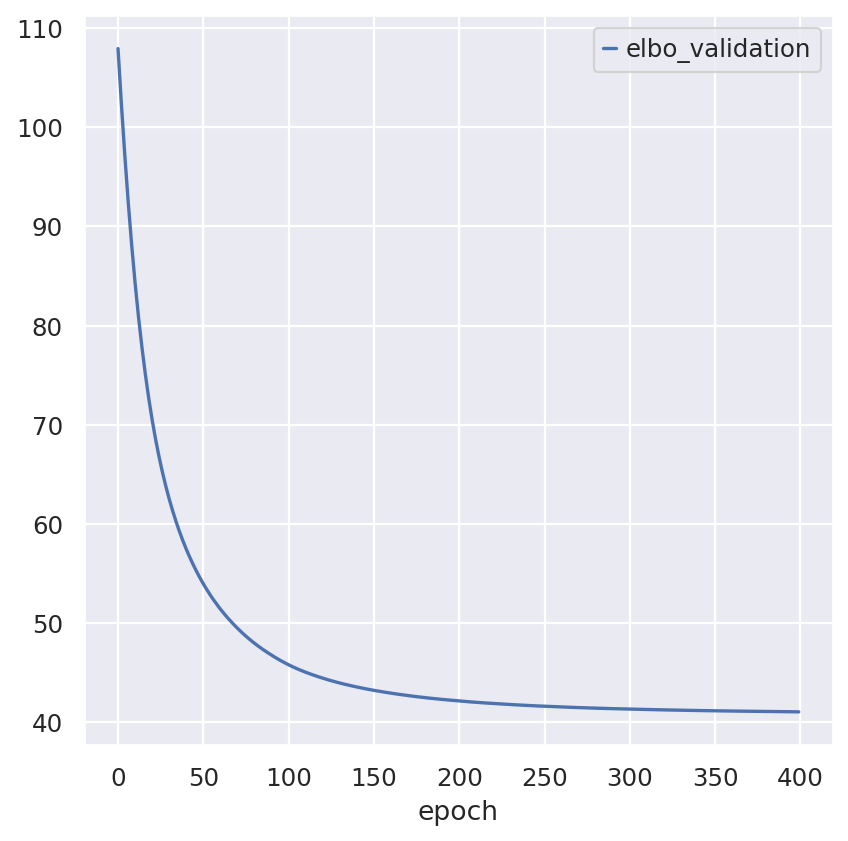

In [21]:
hgsc_model.history["elbo_validation"].plot()

### Predict and plot assigned cell types

In [22]:
predictions_hgsc = hgsc_model.predict()

/env/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


/env/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


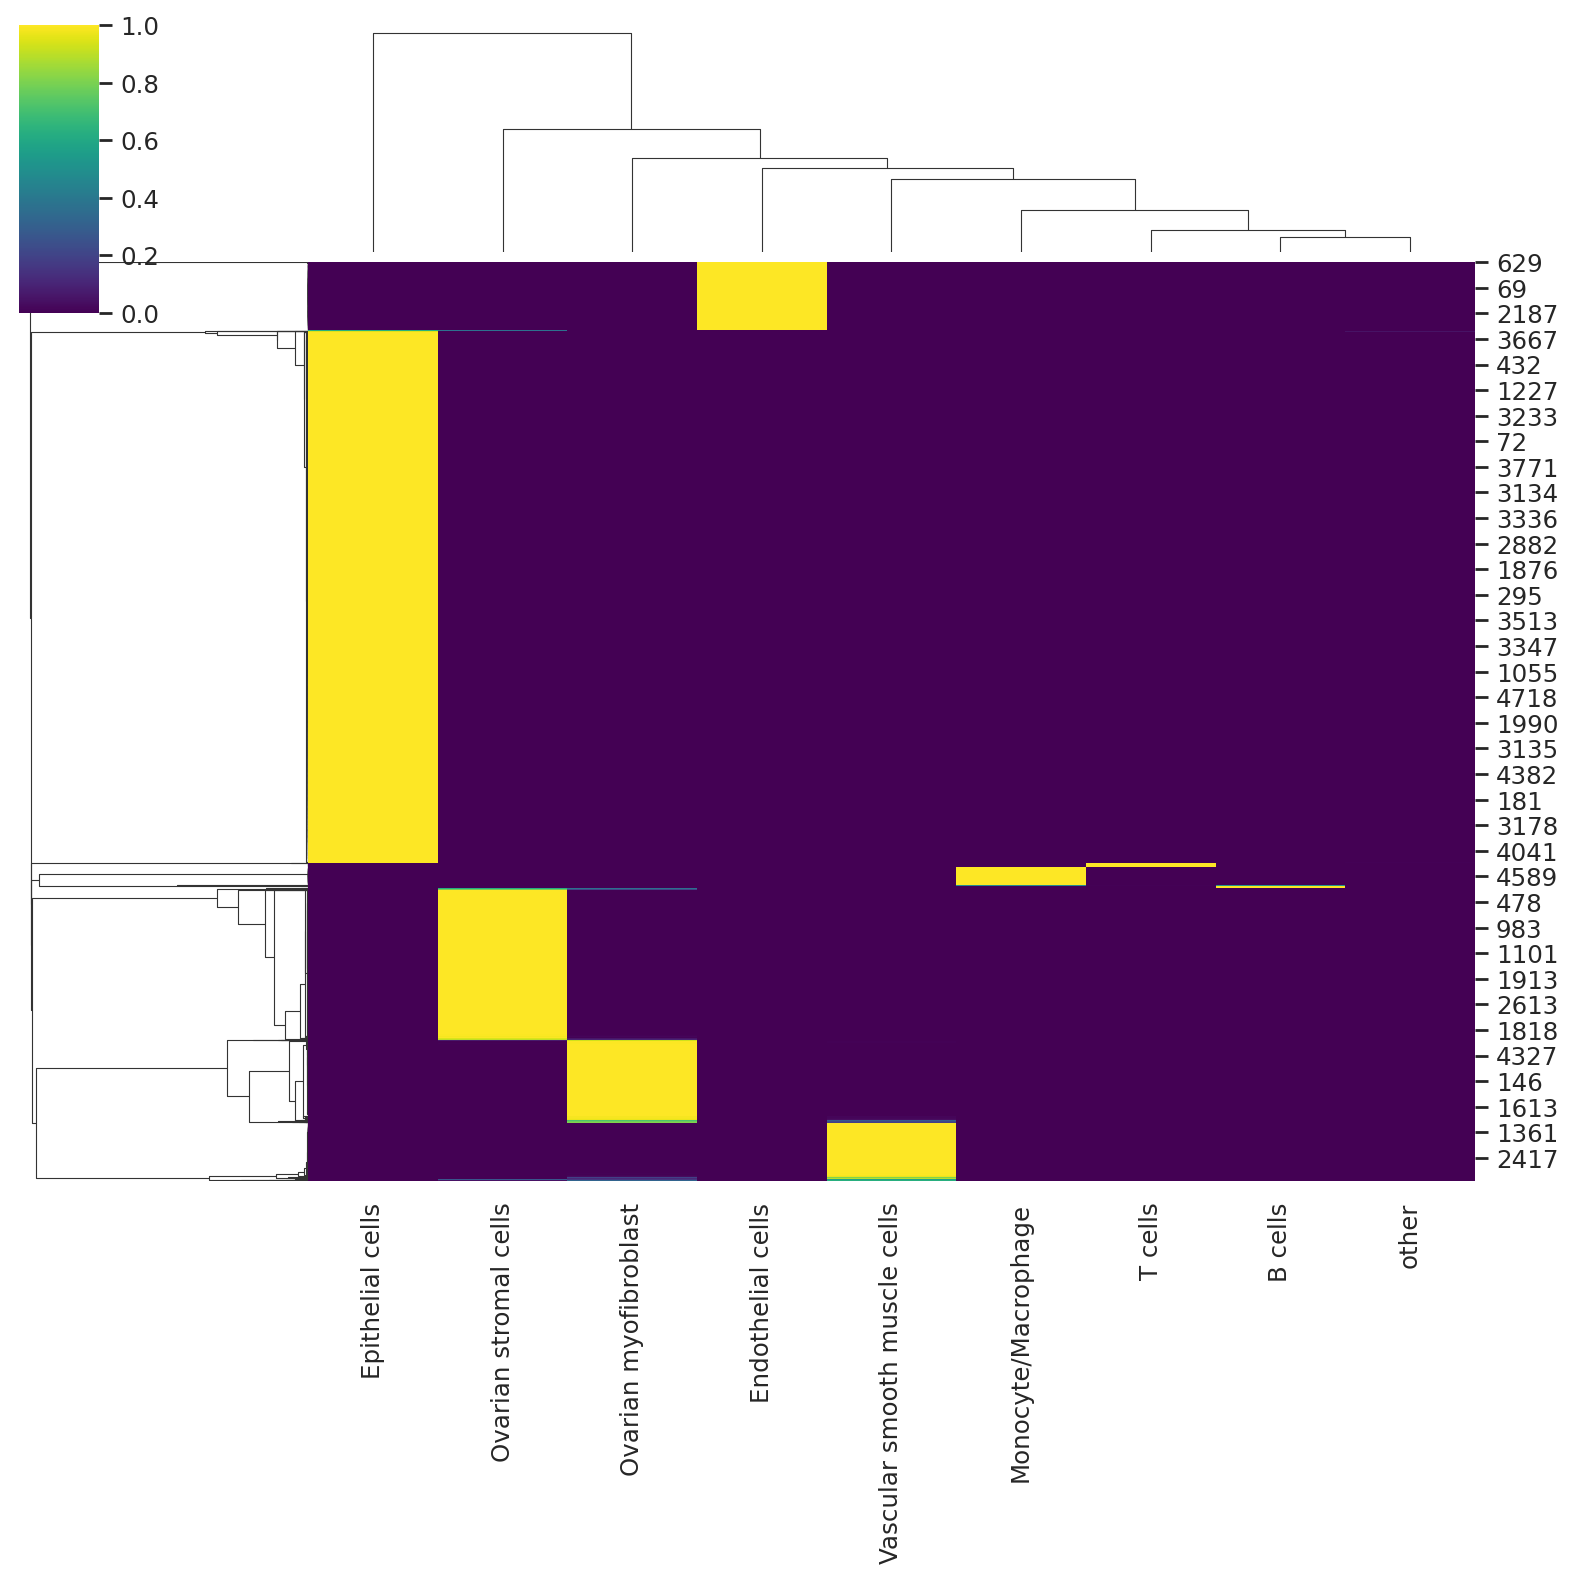

In [23]:
sns.clustermap(predictions_hgsc, cmap="viridis")

In [24]:
hgsc_bdata.obs["cellassign_predictions"] = predictions_hgsc.idxmax(axis=1).values

/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:

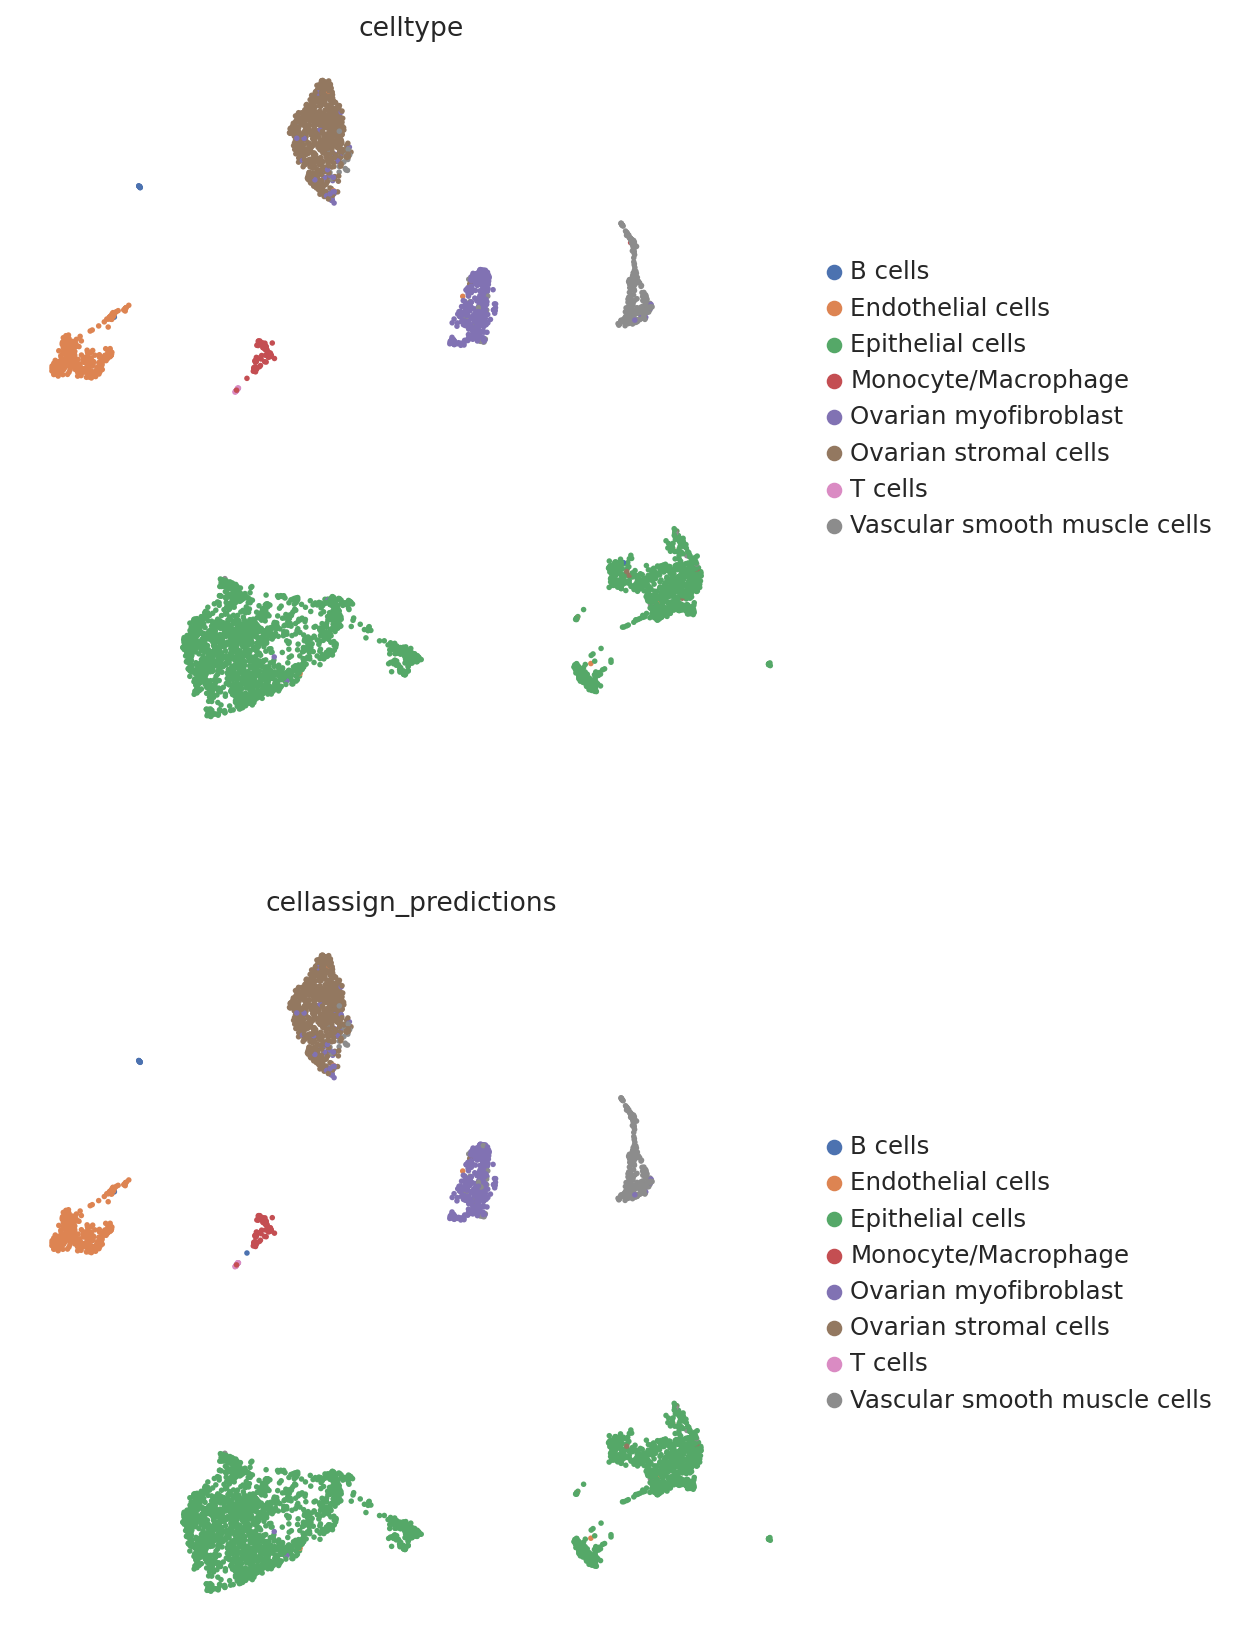

In [25]:
sc.pl.umap(
    hgsc_bdata,
    color=["celltype", "cellassign_predictions"],
    ncols=1,
    frameon=False,
)

### Model reproducibility

```
```

/tmp/ipykernel_158/1936993632.py:8: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


<Axes: xlabel='Original predictions', ylabel='cellassign_predictions'>

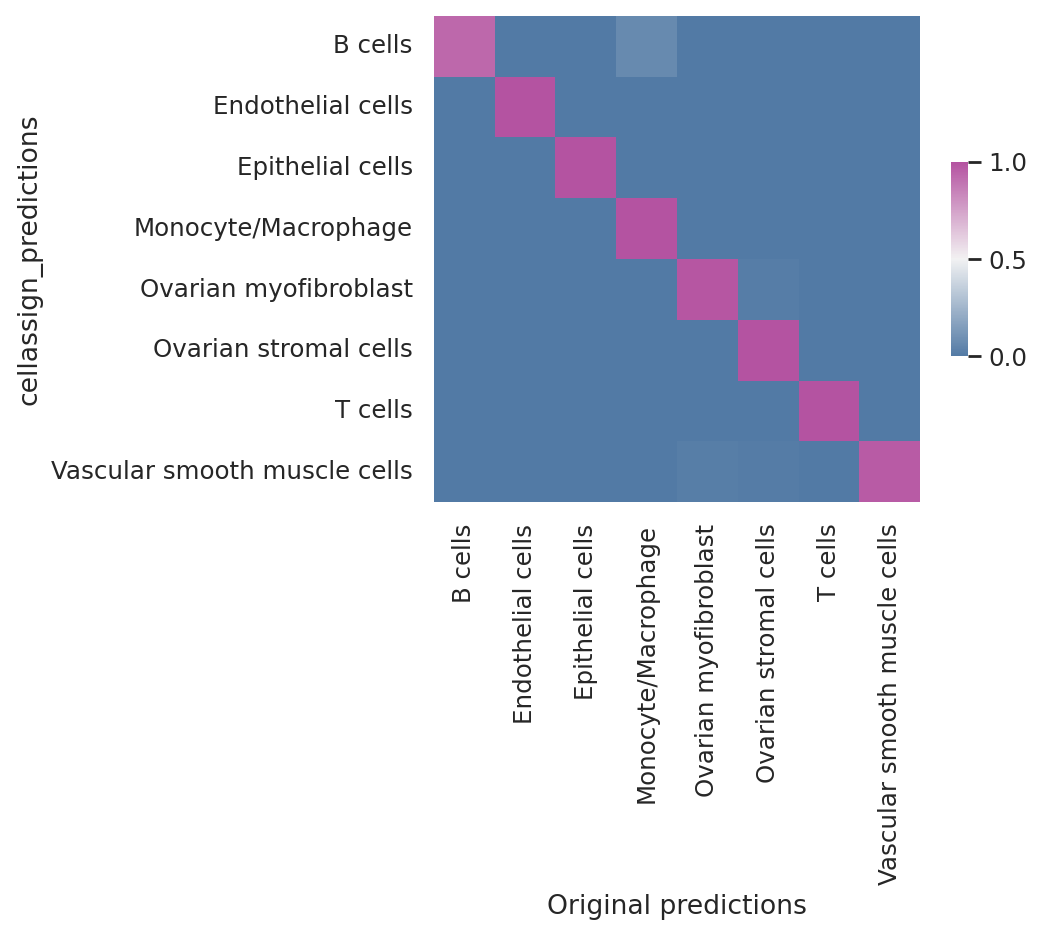

In [26]:
df = hgsc_bdata.obs
confusion_matrix = pd.crosstab(
    df["cellassign_predictions"],
    df["celltype"],
    rownames=["cellassign_predictions"],
    colnames=["Original predictions"],
)
confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(
    confusion_matrix,
    cmap=sns.diverging_palette(245, 320, s=60, as_cmap=True),
    ax=ax,
    square=True,
    cbar_kws={"shrink": 0.4, "aspect": 12},
)